<h1 style="color:#333333; font-family:Arial, sans-serif; font-size:30px; font-weight:bold; text-align:center;">Tree-based variational inference for Poisson log-normal
models</h1>

This notebook contains all the experiments performed in the paper "ref arXiv"

## Utils

Here we group all of the utils function for plotting etc.

In [1]:
import os
import matplotlib.pyplot as plt 
import matplotlib
import torch
from torch import optim
import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.5f' % x)
import seaborn as sns
import plntree.metrics.viz as metrics_viz
from plntree.models import pln_lib, PLNTree
from plntree.utils import tree_utils
from plntree.utils import seed_all
from plntree.metrics import BrayCurtis, Jaccard, UniFrac
from plntree.metrics.utils import *
from plntree.utils.jupyter_functions import *

pd.set_option('display.float_format', lambda x: '%.5f' % x)

viridis = matplotlib.colormaps.get_cmap('viridis')
magma = matplotlib.colormaps.get_cmap('magma')
blues = matplotlib.colormaps.get_cmap('Blues')

2025-02-03 16:32:00.950150: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-03 16:32:00.992679: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-03 16:32:01.198972: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-03 16:32:01.199117: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-03 16:32:01.261618: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

## Synthetic data study

### PLN-Tree generated data

#### Model choice and data generation

In [2]:
seed = 42
prefix = f'synthetic_plntree_s{seed}'

seed_all(seed)

In [3]:
# Model parameters
selected_layers = [1, -1]

# Tree parameters
K = [1, 5, 14, 35]
mu_1 = torch.tensor([0., 1, -0.2, 2, 0]) + 0.1 * torch.randn(K[selected_layers[0]])
Omega_1 = torch.tensor(artificial_loader.generate_precision_matrix(
    artificial_loader.generate_adjacency_matrix(K[selected_layers[0]], seed=seed), 
    conditioning=0.3, 
    correlation=0.4
))

identifiable = True
diag_correction = 1e-3
positive_fun = 'softplus'

n_latent_layers = 3
    
offset_method = 'constant'
offset_constant = 8.

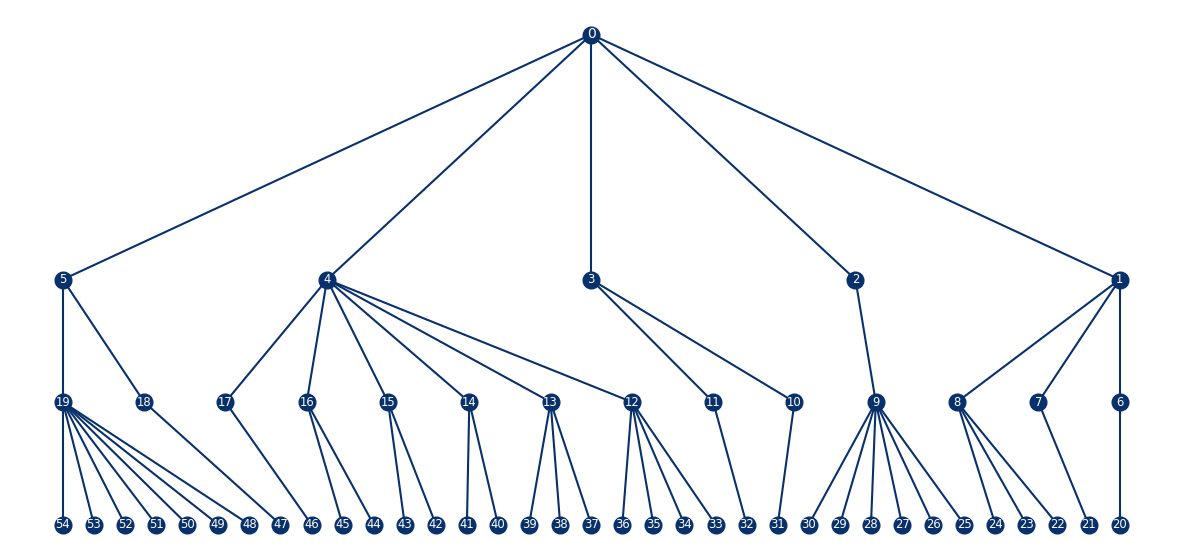

In [4]:
tree = generate_hierachical_tree(K, seed=seed)
tree.plot(legend=False, title='')
savefig('synthetic_plntree_tree_graph')

In [5]:
base = PLNTree(
        tree=tree,
        identifiable=identifiable,
        diag_smoothing_factor=diag_correction,
        positive_fun=positive_fun,
        selected_layers=selected_layers,
        offset_method=offset_method,
        n_latent_layers=n_latent_layers,
        seed=seed
    )

base.mu_fun[0].data = mu_1
base.omega_fun[1][0].weight.data *= 20
base.mu_fun[1][0].weight.data += 10
base.mu_fun[2][2].weight.data *= 20
base.mu_fun[2][2].weight.data += 5
base.offset_constant.data = torch.tensor([offset_constant])

In [6]:
n_data = 2_000
dataloader = artificial_loader.load_artificial_data(base, n_data=n_data, batch_size=512, seed=seed)

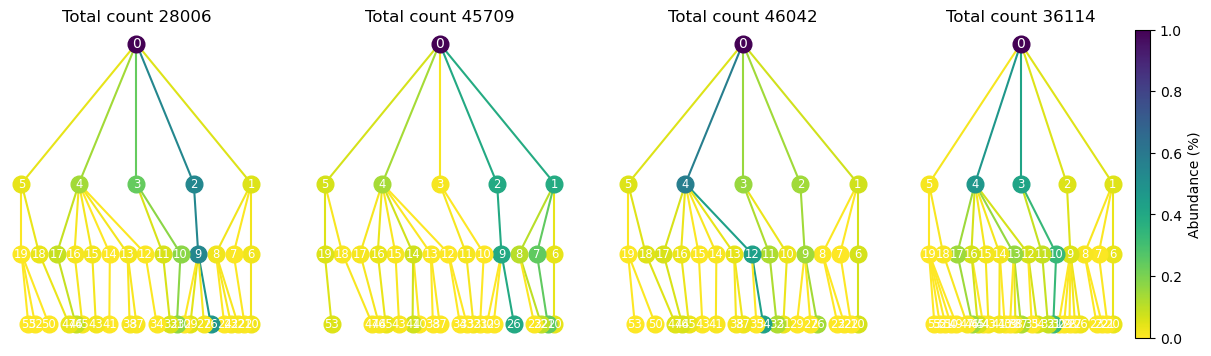

In [7]:
vizualize_samples(dataloader, tree, autofill=True, seed=seed)
savefig('synthetic_plntree_samples')

In [12]:
X_base, Z_base, O_base = dataloader_to_tensors(dataloader)
X_synthetic_plntree = X_base

In [9]:
Z_base[:, 1, :base.K[1]].mean(axis=0)

tensor([ 0.7590, -0.2268, -0.5325,  0.0000, -0.4507,  0.4524,  1.0155, -0.5115,
        -0.6064, -0.7729,  0.0384,  0.8380,  0.2367, -0.2359],
       grad_fn=<MeanBackward1>)

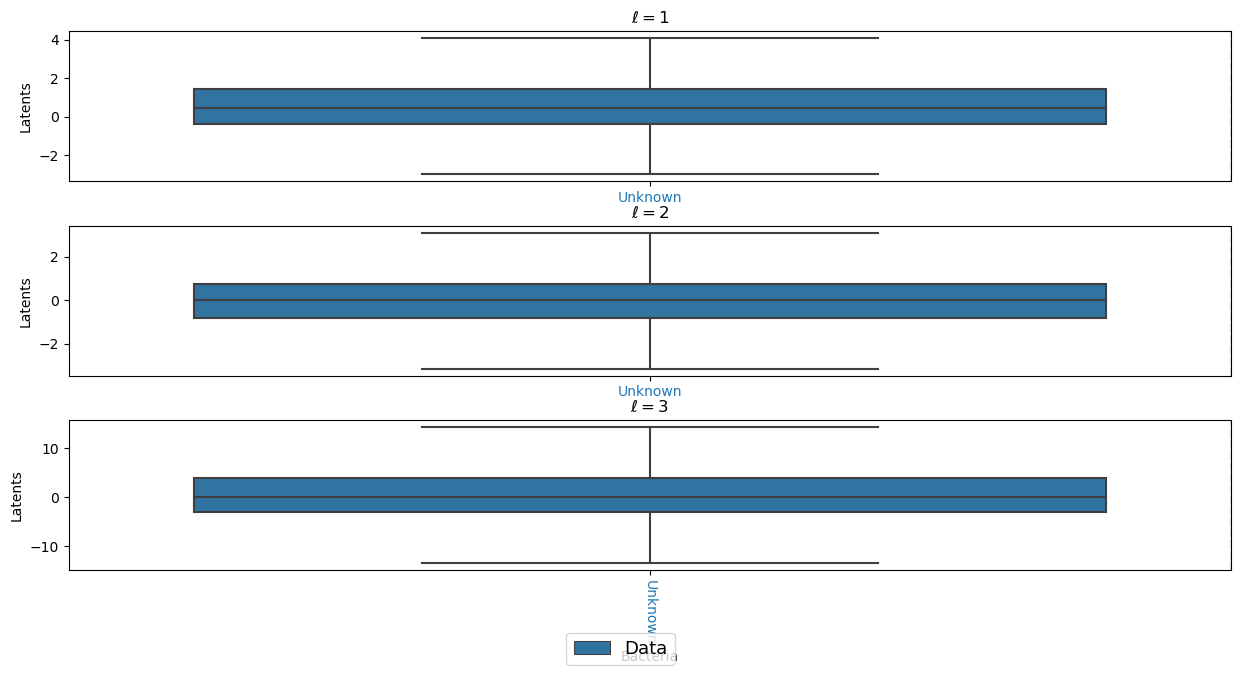

In [10]:
vizualize_entities_distributions(base, (Z_base.detach(),), ['Data'], title='Latents', figsize=(15, 7))

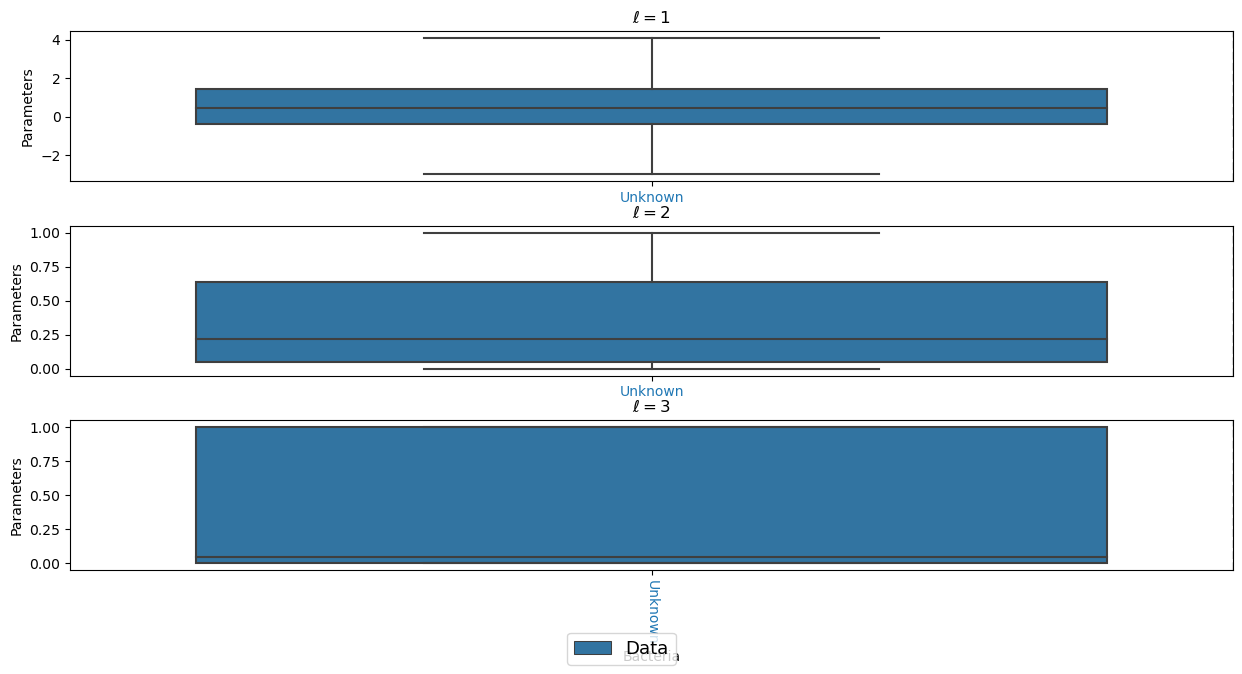

In [11]:
Z_multinomial_base = multinomial_probas(Z_base, base)
vizualize_entities_distributions(base, (Z_multinomial_base.detach(),), ['Data'], title='Parameters', figsize=(15, 7))

In [12]:
X_ref, Z_ref, O_ref = base.sample(len(X_base), seed=67)

#### Benchmark models

##### PLN

Setting the offsets as the log of the sum of endog
Fitting a Pln model with full covariance model.
Initialization ...
Initialization finished
Tolerance 1e-08 reached in 849 iterations
Setting the offsets as the log of the sum of endog
Fitting a Pln model with full covariance model.
Initialization ...
Initialization finished
Tolerance 1e-08 reached in 824 iterations
Setting the offsets as the log of the sum of endog
Fitting a Pln model with full covariance model.
Initialization ...
Initialization finished
Tolerance 1e-08 reached in 783 iterations
Likelihood: -98424.39514303207


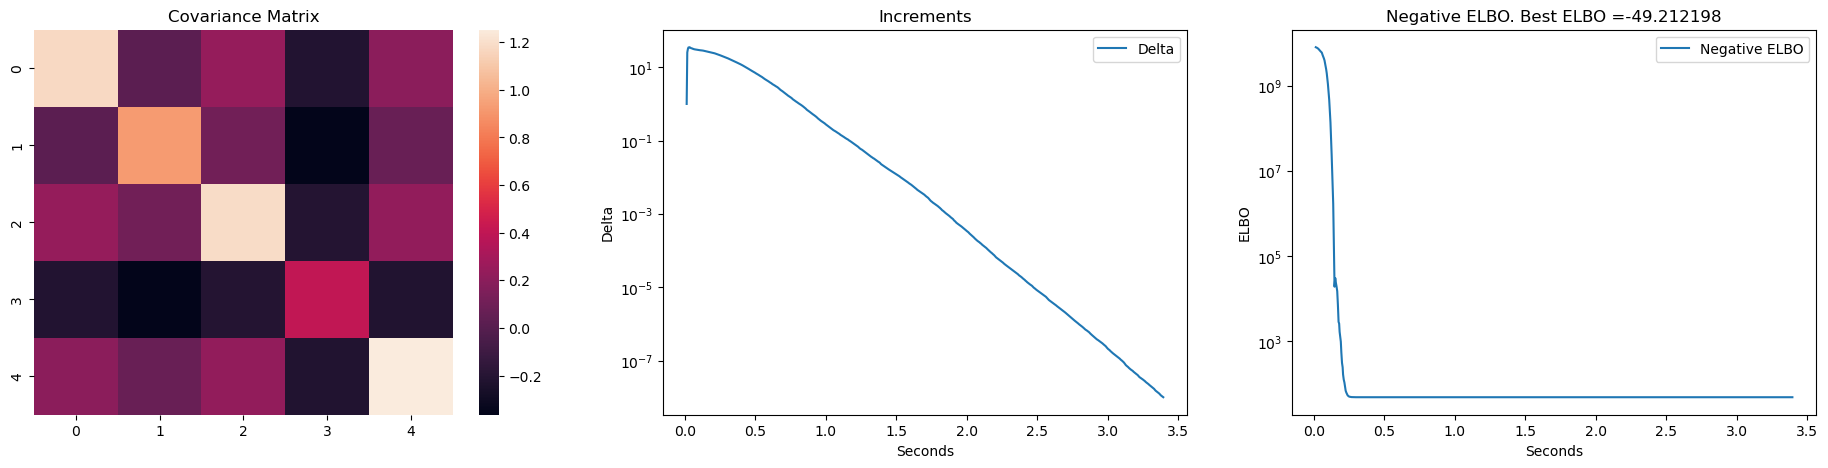

Likelihood: -242809.9739727974


Likelihood: -345662.47671580315


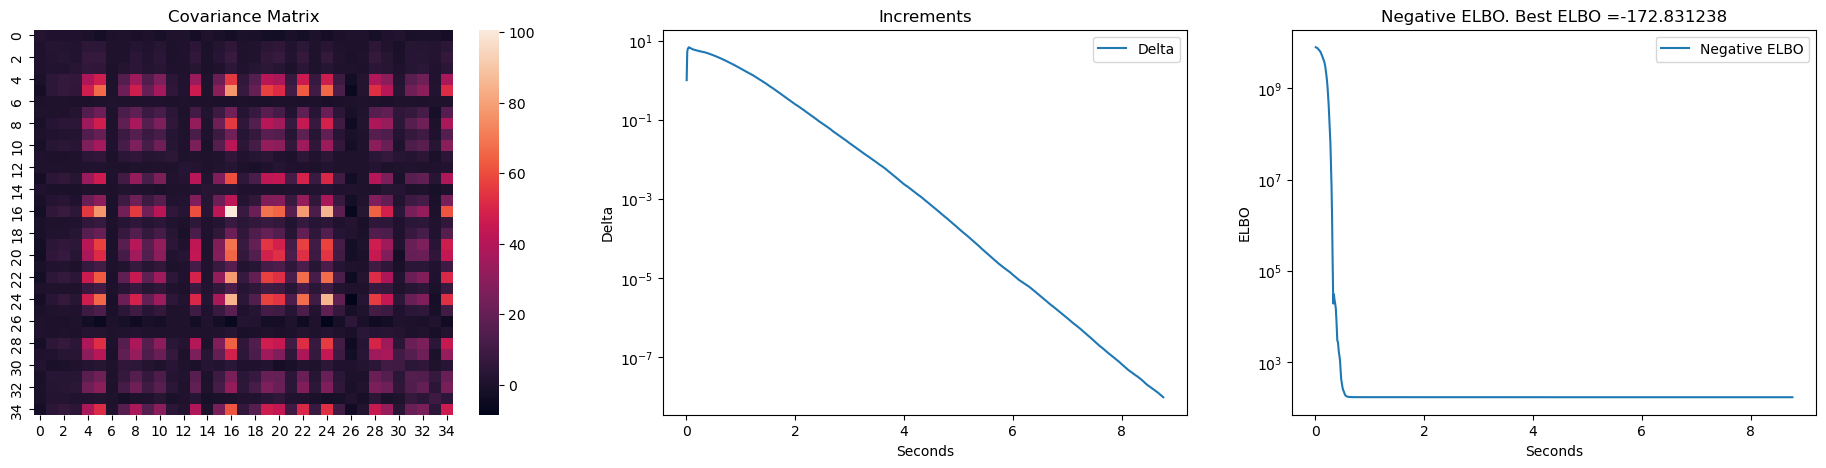

In [13]:
# PLN
pln_layers = learn_pln(X_base, base.K, seed=seed)

In [14]:
n_samples = 50_000
X_pln, Z_pln, X_pln_fill, X_pln_enc, Z_pln_enc, X_pln_enc_fill = generate_pln_data(pln_layers, n_samples, base.K, base.selected_layers, X_base, tree, seed=seed)

##### SparCC

In [15]:
# SparCC
sparCC_layers = learn_per_layer_sparCC(to_proportion(X_base, base.K), base.K)
X_sparCC, X_sparCC_fill = sample_model_layers(sparCC_layers, n_samples, base.K, base.selected_layers, tree, seed=seed)

##### SPiEC-Easi

In [16]:
# SPiEC-Easi
spiec_layers = learn_per_layer_spiec_easi(
    to_proportion(X_base, base.K), base.K, {'alpha':0.01, 'max_iter':10_000}, seed=seed
)
X_spiec, X_spiec_fill = sample_model_layers(spiec_layers, n_samples, base.K, base.selected_layers, tree, seed=seed)

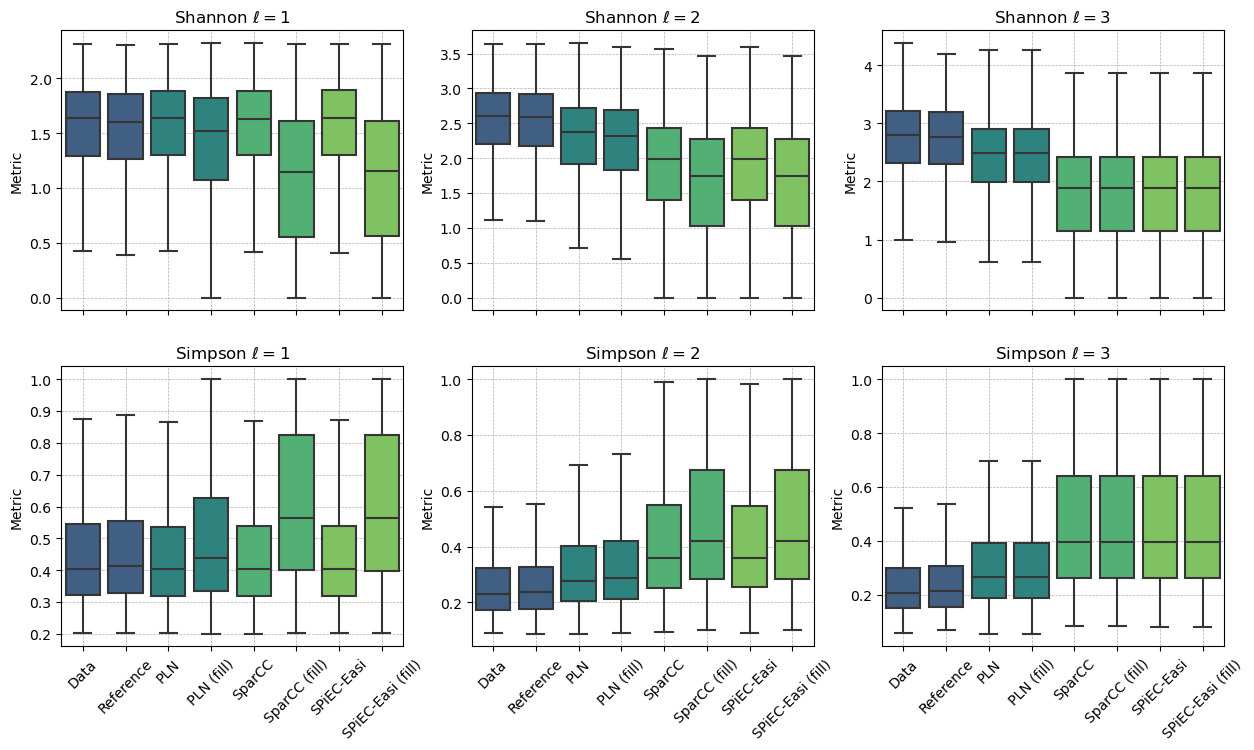

In [17]:
X_list = (X_base / X_base.sum(-1, keepdims=True), X_ref, X_pln, X_pln_fill, X_sparCC, X_sparCC_fill, X_spiec, X_spiec_fill)
groups = ['Data', 'Reference', 'PLN', 'PLN (fill)', 'SparCC', 'SparCC (fill)', 'SPiEC-Easi', 'SPiEC-Easi (fill)']
colors = [viridis(0.3), viridis(0.3), viridis(0.5), viridis(0.5), viridis(0.7), viridis(0.7), viridis(0.8), viridis(0.8)]

plot_alpha_diversity(
    X_list,
    tree,
    offset_layer=base.selected_layers[0],
    groups_name=groups,
    colors=colors,
    style='boxplot'
)

In [17]:
n_limit = 100
X_list = [X_base, X_pln_fill, X_sparCC_fill]

In [19]:
print("PERMANOVA")
res, pvalues = bootstrap_pvalues_braycurtis(
    base.K, "permanova",
    X_base, [X_ref, X_pln_fill, X_sparCC_fill], ['Ref', 'PLN', 'SparCC'],
    n_samples=100, n_repeat=10, seed=seed
)
res

l = 0          l = 1          l = 2
Ref     1.368 (1.451)  2.572 (2.848)  1.275 (0.838)
PLN     5.375 (3.765)  5.428 (2.191)  7.806 (3.474)
SparCC   13.818 (0.0)   13.818 (0.0)   13.818 (0.0)

In [18]:
def bootstrap_pvalues_braycurtis(K, method, X_base, X_list, names, n_samples=100, n_repeat=10, seed=None):
    seed_all(seed)
    df = pd.DataFrame()
    layer_pvalues = []
    for layer in range(X_base.shape[1]):
        pvalues = bootstrap_perm_pvalue(
            method, BrayCurtis(K),
            X_base, X_list, names, n_samples=n_samples, n_repeat=n_repeat, beta_args={'layer':layer}
        )
        layer_pvalues.append(pvalues)
        pvalues_mean = pvalues.mean(0)
        pvalues_std = pvalues.std(0)
        df['l = ' + str(layer)] = [
            f'{np.round(pvalues_mean[i], 3)} ({np.round(pvalues_std[i], 3)})' for i in range(len(pvalues_mean))
        ]
        df.index = names
    return df, layer_pvalues

In [23]:
print("PERMANOVA")
res, pvalues = bootstrap_pvalues_braycurtis(
    base.K, "permanova",
    X_base, [X_ref, X_pln_fill, X_sparCC_fill], ['Ref', 'PLN', 'SparCC'],
    n_samples=100, n_repeat=5, seed=seed
)
res

PERMANOVA


l = 0          l = 1          l = 2
Ref      0.528 (0.39)  0.489 (0.393)   0.44 (0.289)
PLN     0.111 (0.091)  0.179 (0.169)  0.066 (0.068)
SparCC    0.001 (0.0)    0.001 (0.0)    0.001 (0.0)

#### PLN-Tree Mean Field

##### Model Selection

In [17]:
def learn_plntree_mean_field(variational_approx_params, seed=seed, n_epoch=15_000):
    estimator = PLNTree(
        tree=tree,
        selected_layers=base.selected_layers,
        diagonal_model=base.diagonal_model,
        diag_smoothing_factor=diag_correction,
        positive_fun=positive_fun,
        offset_method=offset_method,
        identifiable=identifiable,
        variational_approx='mean_field',
        variational_approx_params=variational_approx_params,
        n_latent_layers=n_latent_layers,
        seed=seed
    )

    optimizer = optim.Adam(
        estimator.parameters(),
        lr=1e-3,
    )
    return estimator.fit(optimizer, dataloader, n_epoch=n_epoch, verbose=100, max_grad_norm=5.)

In [18]:
preprocessing = 'log'
variational_approx_params_list = [
    {'n_variational_layers': 1, 'preprocessing': [preprocessing]},
    {'n_variational_layers': 2, 'preprocessing': [preprocessing]},
    {'n_variational_layers': 3, 'preprocessing': [preprocessing]},
]

In [19]:
meanfields = []
for variational_approx_params in variational_approx_params_list:
    try:
        meanfield, meanfield_losses = load_pkl(prefix, f'mean_field_{preprocessing}-nvar-{variational_approx_params["n_variational_layers"]}')
    except:
        print('Learning PLN-Tree (MF)')
        print(variational_approx_params)
        meanfield, meanfield_losses = learn_plntree_mean_field(variational_approx_params)
        save_pkl((meanfield, meanfield_losses), prefix, f'mean_field_{preprocessing}-nvar-{variational_approx_params["n_variational_layers"]}')
    meanfields.append([meanfield, meanfield_losses])

Loading file ./experiments/saves/synthetic_plntree_s42_mean_field_log-nvar-1.pkl
Loading file ./experiments/saves/synthetic_plntree_s42_mean_field_log-nvar-2.pkl
Loading file ./experiments/saves/synthetic_plntree_s42_mean_field_log-nvar-3.pkl


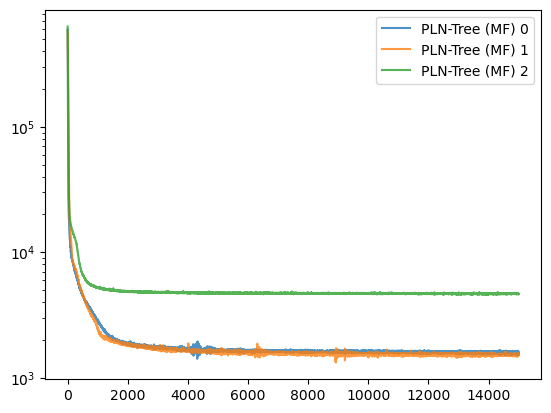

In [20]:
fig, axs = plt.subplots()
for k, (meanfield, losses) in enumerate(meanfields):
    axs.plot(losses, label=f'PLN-Tree (MF) {k}', alpha=0.8)
axs.set_yscale('log')
plt.legend()
savefig(f'{prefix}_ELBO_meanfields_selection')

In [21]:
n_samples = 15_000
meanfields_samples = {}
for key, (meanfield, losses) in enumerate(meanfields):
    X_meanfield, Z_meanfield, O_meanfield = meanfield.sample(n_samples, seed=seed)
    meanfields_samples[key] = X_meanfield

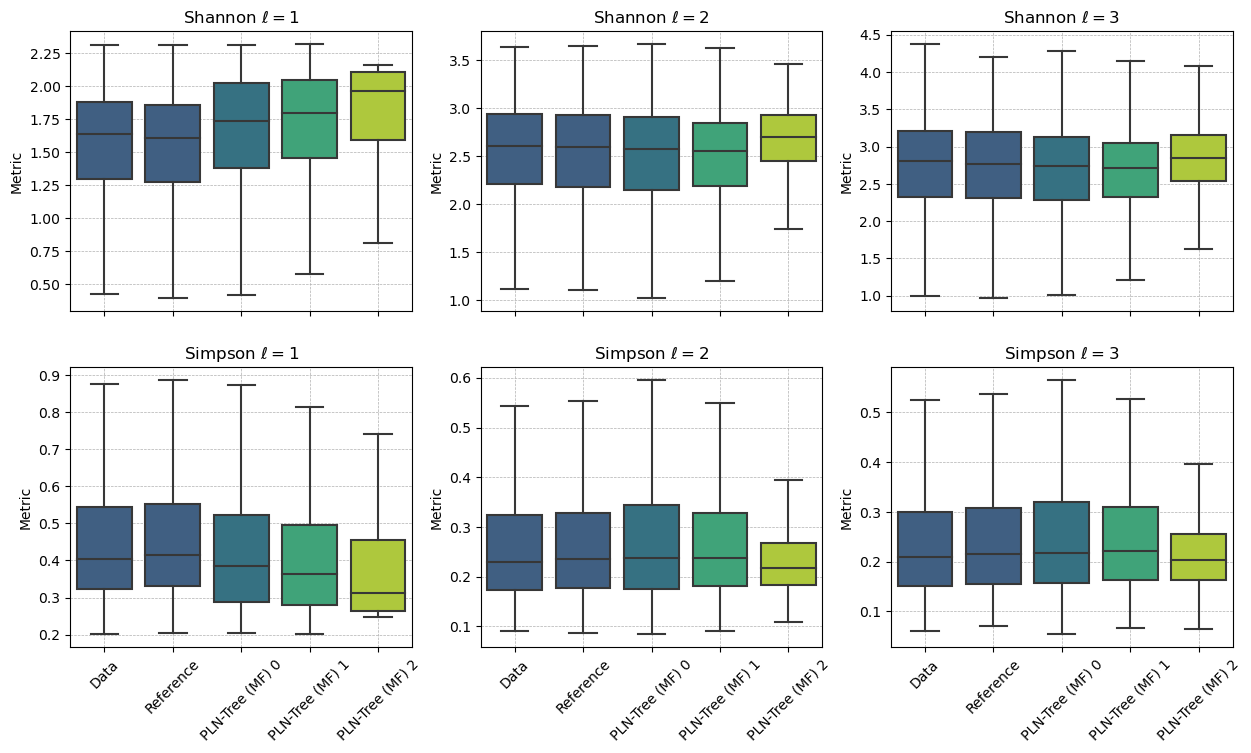

In [22]:
X_list = [X_base] + [X_ref] + [X_meanfield for key, X_meanfield in meanfields_samples.items()]
groups = ['Data'] + ['Reference'] + ['PLN-Tree (MF) ' + str(key) for key, _ in meanfields_samples.items()]
groups_colors = [viridis(0.4 + int(key)/4) for key in meanfields_samples.keys()]
colors = [viridis(0.3)] + [viridis(0.3)]  + groups_colors

plot_alpha_diversity(
    X_list,
    tree,
    offset_layer=selected_layers[0],
    groups_name=groups,
    colors=colors,
    style='boxplot',
)

In [23]:
print('Wasserstein Distance')
repeated_metric_compute(
    tree, X_base, X_list[1:], groups[1:], 
    n_split=5, distance=wasserstein_distance, offset_layer=base.selected_layers[0], order=True
)

Wasserstein Distance


In [24]:
print('Kullback-Leilbler')
repeated_metric_compute(
    tree, X_base, X_list[1:], groups[1:], 
    n_split=5, distance=kl_divergence, offset_layer=base.selected_layers[0], order=True
)

Kullback-Leilbler


In [25]:
print('Kolmogorov-Smirnov')
repeated_metric_compute(
    tree, X_base, X_list[1:], groups[1:], 
    n_split=5, distance=kolmogorov_smirnov, offset_layer=base.selected_layers[0], order=True
)

Kolmogorov-Smirnov


In [28]:
print('Total variation')
repeated_metric_compute(
    tree, X_base, X_list[1:], groups[1:], 
    n_split=5, distance=total_variation, offset_layer=base.selected_layers[0], order=True
)

Total variation


##### Selected model training

In [26]:
meanfield, meanfield_losses = meanfields[0]

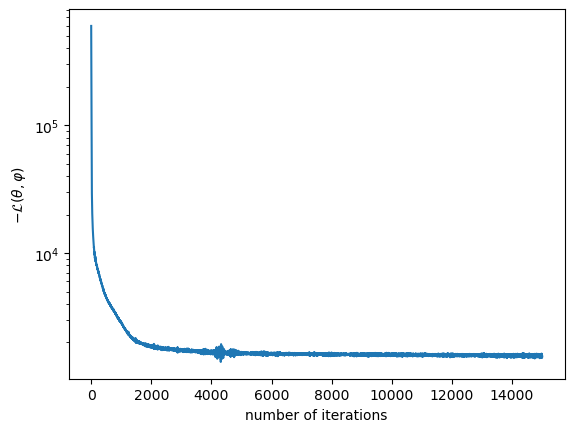

In [27]:
fig, axs = plt.subplots()
axs.plot(meanfield_losses[:])
axs.set_yscale('log')
axs.set_ylabel('$-\mathcal{L}(\\theta, \\varphi)$')
axs.set_xlabel('number of iterations')
savefig(f"synthetic_plntree_MF_ELBO")

In [22]:
n_samples = 50_000

X_meanfield, Z_meanfield, O_meanfield = meanfield.sample(n_samples, seed=seed)
Z_meanfield_enc, O_meanfield_enc = meanfield.encode(X_base, seed=seed)
X_meanfield_enc = meanfield.decode(Z_meanfield_enc, O_meanfield_enc, seed=seed)

In [32]:
def repeat_selected_model_MF(n_repeat, seed_repeat, variational_approx_params, n_epoch=10_000):
    models = []
    prefix_repeat = prefix + "_repeat_"
    curr_seed = seed_repeat
    for _ in range(n_repeat):
        seed_all(curr_seed)
        curr_seed = np.random.randint(10000)
        meanfields = []
        try:
            model, losses = load_pkl(prefix_repeat + f"s{curr_seed}", f'mean_field_{preprocessing}-nvar-{variational_approx_params["n_variational_layers"]}')
        except:
            print('Learning PLN-Tree (MF)')
            print(variational_approx_params)
            model, losses = learn_plntree_mean_field(variational_approx_params, seed=curr_seed, n_epoch=n_epoch)
            save_pkl((model, losses), prefix_repeat + f"s{curr_seed}", f'mean_field_{preprocessing}-nvar-{variational_approx_params["n_variational_layers"]}')
        models.append([model, losses])
    return models
models = repeat_selected_model_MF(5, seed_repeat=seed, variational_approx_params=variational_approx_params_list[0])

Loading file ./experiments/saves/synthetic_plntree_s42_repeat_s7270_mean_field_log-nvar-1.pkl
Loading file ./experiments/saves/synthetic_plntree_s42_repeat_s9170_mean_field_log-nvar-1.pkl
Loading file ./experiments/saves/synthetic_plntree_s42_repeat_s864_mean_field_log-nvar-1.pkl
Loading file ./experiments/saves/synthetic_plntree_s42_repeat_s9609_mean_field_log-nvar-1.pkl
Loading file ./experiments/saves/synthetic_plntree_s42_repeat_s2416_mean_field_log-nvar-1.pkl


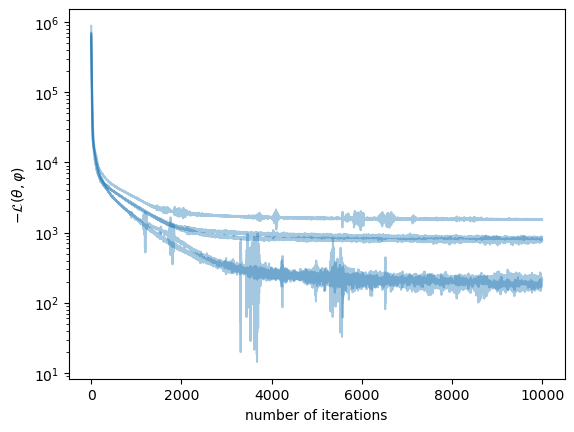

In [33]:
fig, axs = plt.subplots()
for k, (_, losses) in enumerate(models):
    losses = np.array(losses)
    losses = losses[losses > 0]
    axs.plot(losses, alpha=0.4, color='C0')
axs.set_ylabel('$-\mathcal{L}(\\theta, \\varphi)$')
axs.set_xlabel('number of iterations')
axs.set_yscale('log')
savefig(f'{prefix}_MF_ELBOs_repeated')

In [34]:
n_samples = 25_000
meanfields_samples = {}
for key, (meanfield, losses) in enumerate(models):
    X_meanfield, Z_meanfield, O_meanfield = meanfield.sample(n_samples, seed=seed)
    meanfields_samples[key] = X_meanfield

In [36]:
X_list = [X_base] + [X_ref] + [X_meanfield for key, X_meanfield in meanfields_samples.items()]
groups = ['Data'] + ['Reference'] + ['PLN-Tree (MF) ' + str(key) for key, _ in meanfields_samples.items()]
groups_colors = [viridis(0.4 + int(key)/4) for key in meanfields_samples.keys()]
colors = [viridis(0.3)] + [viridis(0.3)] + groups_colors

plot_alpha_diversity(
    X_list,
    tree,
    offset_layer=selected_layers[0],
    groups_name=groups,
    colors=colors,
    style='boxplot',
)

In [37]:
print('Wasserstein Distance')
repeated_metric_compute(
    tree, X_base, X_list[1:], groups[1:], 
    n_split=5, distance=wasserstein_distance, offset_layer=base.selected_layers[0], order=True
)

Wasserstein Distance


### PLN-Tree Backward

##### Model Selection

In [28]:
def learn_plntree(variational_approx_params, seed=seed):
    estimator = PLNTree(
        tree=tree,
        selected_layers=base.selected_layers,
        diagonal_model=base.diagonal_model,
        diag_smoothing_factor=diag_correction,
        positive_fun=positive_fun,
        offset_method=offset_method,
        identifiable=identifiable,
        variational_approx='residual_backward',
        variational_approx_params=variational_approx_params,
        n_latent_layers=n_latent_layers,
        seed=seed
    )

    optimizer = optim.Adam(
        estimator.parameters(),
        lr=1e-3,
    )
    n_epoch = 20_000
    return estimator.fit(optimizer, dataloader, n_epoch=n_epoch, verbose=100, max_grad_norm=5.)

In [29]:
preprocessing = 'log'
variational_approx_params_list = [
    {
        'embedder_type': 'GRU',
        'embedding_size': 32,
        'n_embedding_layers': 2,
        'n_embedding_neurons': 64,
        'n_after_layers': 1,
        'preprocessing': [preprocessing]
    },
    {
        'embedder_type': 'GRU',
        'embedding_size': 32,
        'n_embedding_layers': 2,
        'n_embedding_neurons': 64,
        'n_after_layers': 2,
        'preprocessing': [preprocessing]
    },
    {
        'embedder_type': 'GRU',
        'embedding_size': 32,
        'n_embedding_layers': 3,
        'n_embedding_neurons': 64,
        'n_after_layers': 1,
        'preprocessing': [preprocessing]
    },
    {
        'embedder_type': 'GRU',
        'embedding_size': 32,
        'n_embedding_layers': 3,
        'n_embedding_neurons': 64,
        'n_after_layers': 2,
        'preprocessing': [preprocessing]
    },
    {
        'embedder_type': 'GRU',
        'embedding_size': 32,
        'n_embedding_layers': 3,
        'n_embedding_neurons': 120,
        'n_after_layers': 2,
        'preprocessing': [preprocessing]
    },
]

In [30]:
plntrees = []
for k, variational_approx_params in enumerate(variational_approx_params_list):
    print('Learning PLN-Tree (backward)', k, variational_approx_params)
    try:
        plntree, plntree_losses = load_pkl(prefix, f'plntree_res_{preprocessing}-{k}')
    except:
        plntree, plntree_losses = learn_plntree(variational_approx_params)
        save_pkl((plntree, plntree_losses), prefix, f'plntree_res_{preprocessing}-{k}')
    plntrees.append([plntree, plntree_losses])

Learning PLN-Tree (backward) 0 {'embedder_type': 'GRU', 'embedding_size': 32, 'n_embedding_layers': 2, 'n_embedding_neurons': 64, 'n_after_layers': 1, 'preprocessing': ['log']}
Loading file ./experiments/saves/synthetic_plntree_s42_plntree_res_log-0.pkl
Learning PLN-Tree (backward) 1 {'embedder_type': 'GRU', 'embedding_size': 32, 'n_embedding_layers': 2, 'n_embedding_neurons': 64, 'n_after_layers': 2, 'preprocessing': ['log']}
Loading file ./experiments/saves/synthetic_plntree_s42_plntree_res_log-1.pkl
Learning PLN-Tree (backward) 2 {'embedder_type': 'GRU', 'embedding_size': 32, 'n_embedding_layers': 3, 'n_embedding_neurons': 64, 'n_after_layers': 1, 'preprocessing': ['log']}
Loading file ./experiments/saves/synthetic_plntree_s42_plntree_res_log-2.pkl
Learning PLN-Tree (backward) 3 {'embedder_type': 'GRU', 'embedding_size': 32, 'n_embedding_layers': 3, 'n_embedding_neurons': 64, 'n_after_layers': 2, 'preprocessing': ['log']}
Loading file ./experiments/saves/synthetic_plntree_s42_plntre

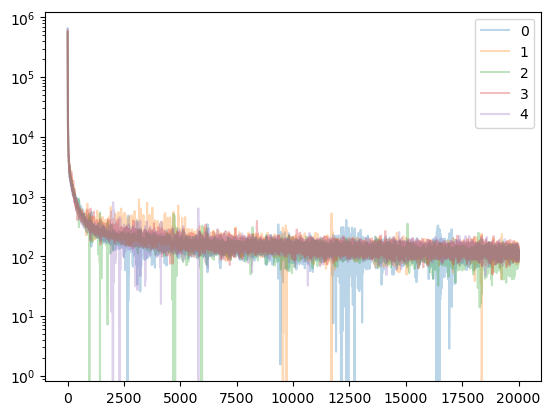

In [52]:
fig, axs = plt.subplots()
for k, (plntree, losses) in enumerate(plntrees):
    axs.plot(losses, label=f'{k}', alpha=0.3)
axs.set_yscale('log')
plt.legend()

In [30]:
n_samples = 15_000
backwards_samples = {}
for key, (estimator, losses) in enumerate(plntrees):
    X_estimator, Z_estimator, O_estimator = estimator.sample(n_samples, seed=seed)
    backwards_samples[key] = X_estimator

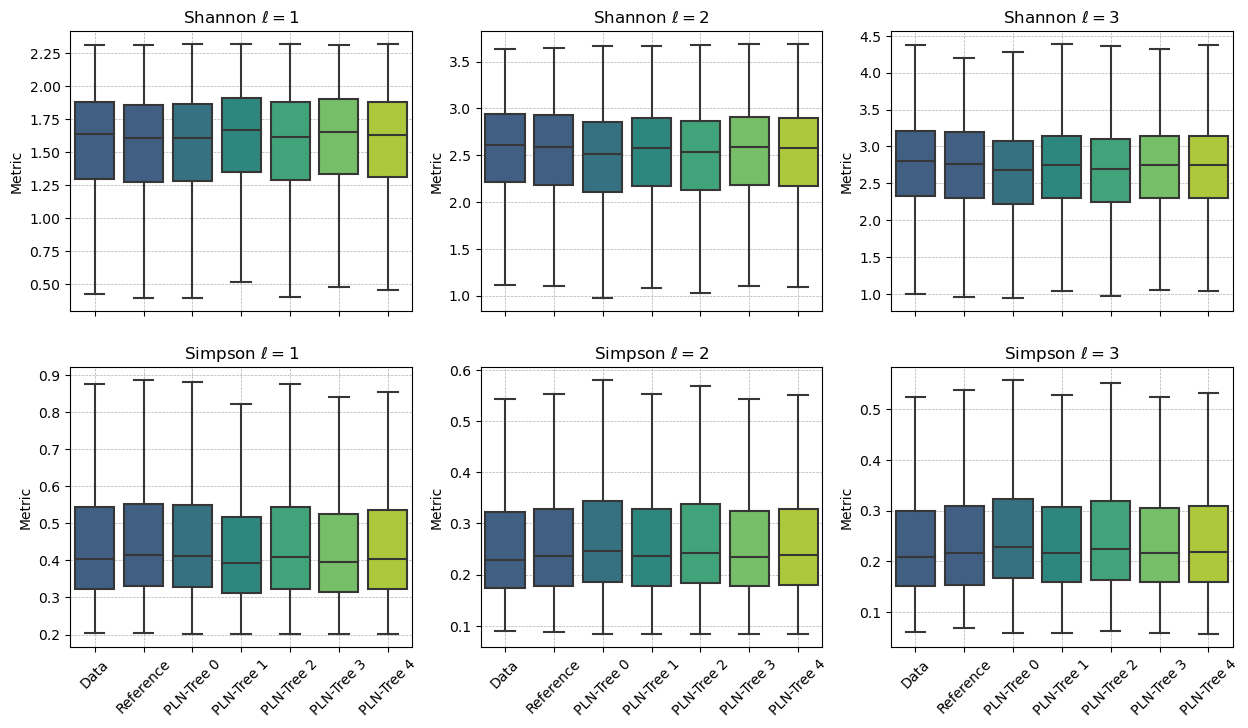

In [43]:
X_list = [X_base] + [X_ref] + [X_estimator for key, X_estimator in backwards_samples.items()]
groups = ['Data'] + ['Reference'] + ['PLN-Tree ' + str(key) for key, X_estimator in backwards_samples.items()]
groups_colors = [viridis(0.4 + int(key)/8) for key in backwards_samples.keys()]
colors = [viridis(0.3)] + [viridis(0.3)] + groups_colors

plot_alpha_diversity(
    X_list,
    tree,
    offset_layer=selected_layers[0],
    groups_name=groups,
    colors=colors,
    style='boxplot',
)

In [44]:
print('Wasserstein Distance')
repeated_metric_compute(
    tree, X_base, X_list[1:], groups[1:], 
    n_split=5, distance=wasserstein_distance, offset_layer=base.selected_layers[0], order=True
)

Wasserstein Distance


In [45]:
print('Kullback-Leilbler')
repeated_metric_compute(
    tree, X_base, X_list[1:], groups[1:], 
    n_split=5, distance=kl_divergence, offset_layer=base.selected_layers[0], order=True
)

Kullback-Leilbler


In [46]:
print('Kolmogorov-Smirnov')
repeated_metric_compute(
    tree, X_base, X_list[1:], groups[1:], 
    n_split=5, distance=kolmogorov_smirnov, offset_layer=base.selected_layers[0], order=True
)

Kolmogorov-Smirnov


In [47]:
print('Total variation')
repeated_metric_compute(
    tree, X_base, X_list[1:], groups[1:], 
    n_split=5, distance=total_variation, offset_layer=base.selected_layers[0], order=True
)

Total variation


##### Selected model training

In [31]:
plntree, plntree_losses = plntrees[4]

In [32]:
fig, axs = plt.subplots()
axs.plot(plntree_losses, alpha=0.8, color='C0')
axs.set_ylabel('$-\mathcal{L}(\\theta, \\varphi)$')
axs.set_xlabel('number of iterations')
axs.set_yscale('log')
savefig(f"synthetic_plntree_ELBO")

In [34]:
n_samples = 50_000

X_plntree, Z_plntree, O_plntree = plntree.sample(n_samples, seed=seed)

In [51]:
def repeat_selected_model_backward(n_repeat, seed_repeat, key, variational_approx_params):
    models = []
    prefix_repeat = prefix + f"_repeat_"
    curr_seed = seed_repeat
    for _ in range(n_repeat):
        seed_all(curr_seed)
        curr_seed = np.random.randint(10000)
        print('Learning PLN-Tree (backward)', key, variational_approx_params)
        try:
            model, losses = load_pkl(prefix_repeat + f"s{curr_seed}", f'plntree_res_{preprocessing}-{k}')
        except:
            model, losses = learn_plntree(variational_approx_params, seed=curr_seed)
            save_pkl((model, losses), prefix_repeat + f"s{curr_seed}", f'plntree_res_{preprocessing}-{k}')
        models.append([model, losses])
    return models
models = repeat_selected_model_backward(5, seed_repeat=seed, key=4, variational_approx_params=variational_approx_params_list[4])

Learning PLN-Tree (backward) 4 {'embedder_type': 'GRU', 'embedding_size': 32, 'n_embedding_layers': 3, 'n_embedding_neurons': 120, 'n_after_layers': 2, 'preprocessing': ['log']}
Loading file ./experiments/saves/synthetic_plntree_s42_repeat_s7270_plntree_res_log-4.pkl
Learning PLN-Tree (backward) 4 {'embedder_type': 'GRU', 'embedding_size': 32, 'n_embedding_layers': 3, 'n_embedding_neurons': 120, 'n_after_layers': 2, 'preprocessing': ['log']}
Loading file ./experiments/saves/synthetic_plntree_s42_repeat_s9170_plntree_res_log-4.pkl
Learning PLN-Tree (backward) 4 {'embedder_type': 'GRU', 'embedding_size': 32, 'n_embedding_layers': 3, 'n_embedding_neurons': 120, 'n_after_layers': 2, 'preprocessing': ['log']}
Loading file ./experiments/saves/synthetic_plntree_s42_repeat_s864_plntree_res_log-4.pkl
Learning PLN-Tree (backward) 4 {'embedder_type': 'GRU', 'embedding_size': 32, 'n_embedding_layers': 3, 'n_embedding_neurons': 120, 'n_after_layers': 2, 'preprocessing': ['log']}
Loading file ./expe

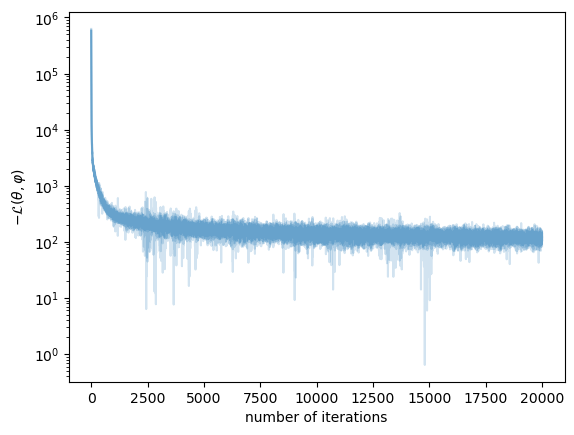

In [52]:
fig, axs = plt.subplots()
for (model, losses) in models:
    losses = np.array(losses)
    losses = losses[losses > 0]
    axs.plot(losses, alpha=0.2, color='C0')
axs.set_ylabel('$-\mathcal{L}(\\theta, \\varphi)$')
axs.set_xlabel('number of iterations')
axs.set_yscale('log')
savefig(f'{prefix}_backward_ELBOs_repeated')

### Benchmark

#### Generative benchmark

In [35]:
X_list = [X_base, X_ref, X_plntree, X_meanfield, X_pln_fill, X_sparCC_fill, X_spiec_fill]
groups = ['Data', 'Reference', 'PLN-Tree (backward)', 'PLN-Tree (MF)', 'PLN (fill)', 'SparCC (fill)', 'SPiEC-Easi (fill)']
colors = [viridis(0.3), viridis(0.3), viridis(0.5), viridis(0.6), viridis(0.7), viridis(0.8), viridis(0.9)]

plot_alpha_diversity(
    X_list,
    tree,
    offset_layer=base.selected_layers[0],
    groups_name=groups,
    colors=colors,
    style='boxplot',
    saveName=f'synthetic_plntree_generations'
)

In [35]:
print('Wasserstein Distance')
repeated_metric_compute(
    tree, X_base, X_list[1:], groups[1:], 
    n_split=25, distance=wasserstein_distance, offset_layer=base.selected_layers[0]
)

Wasserstein Distance


In [36]:
print('KL divergence')
repeated_metric_compute(
    tree, X_base, X_list[1:], groups[1:], 
    n_split=25, distance=kl_divergence, offset_layer=base.selected_layers[0]
)

KL divergence


In [37]:
print('Total variation')
repeated_metric_compute(
    tree, X_base, X_list[1:], groups[1:], 
    n_split=25, distance=total_variation, offset_layer=base.selected_layers[0]
)

Total variation


In [38]:
print('Kolmogorov-Smirnov')
repeated_metric_compute(
    tree, X_base, X_list[1:], groups[1:], 
    n_split=25, distance=kolmogorov_smirnov, offset_layer=base.selected_layers[0]
)

Kolmogorov-Smirnov


In [37]:
print("PERMANOVA")
try:
    permanova_mean, permanova_pvalues_layers = load_pkl(prefix, 'pvalues_PERMANOVA')
except:
    permanova_mean, permanova_pvalues_layers = bootstrap_pvalues_braycurtis(
        base.K, "permanova",
        X_base, X_list[1:-1], groups[1:-1],
        n_samples=100, n_repeat=50, seed=seed, replacement=True
    )
    save_pkl((permanova_mean, permanova_pvalues_layers), prefix, 'pvalues_PERMANOVA')
permanova_mean

PERMANOVA
Loading file ./experiments/saves/synthetic_plntree_s42_pvalues_PERMANOVA.pkl


l = 0          l = 1          l = 2
Reference             0.436 (0.27)  0.382 (0.322)  0.378 (0.296)
PLN-Tree (backward)  0.425 (0.291)  0.455 (0.279)  0.421 (0.255)
PLN-Tree (MF)        0.286 (0.336)   0.04 (0.093)  0.028 (0.068)
PLN (fill)           0.188 (0.175)  0.073 (0.079)  0.033 (0.053)
SparCC (fill)        0.003 (0.006)    0.001 (0.0)    0.001 (0.0)

In [40]:
print("PERMDISP")
try:
    permdisp_mean, permdisp_pvalues_layers = load_pkl(prefix, 'pvalues_PERMDISP')
except:
    permdisp_mean, permdisp_pvalues_layers = bootstrap_pvalues_braycurtis(
        base.K, "permdisp",
        X_base, X_list[1:-1], groups[1:-1],
        n_samples=100, n_repeat=50, seed=seed, replacement=True
    )
    save_pkl((permdisp_mean, permdisp_pvalues_layers), prefix, 'pvalues_PERMDISP')
permdisp_mean

PERMDISP
Loading file ./experiments/saves/synthetic_plntree_s42_pvalues_PERMDISP.pkl
Saving in file ./experiments/saves/synthetic_plntree_s42_pvalues_PERMDISP.pkl


l = 0          l = 1          l = 2
Reference            0.509 (0.279)  0.562 (0.277)  0.457 (0.245)
PLN-Tree (backward)  0.449 (0.309)   0.428 (0.26)  0.412 (0.272)
PLN-Tree (MF)        0.001 (0.001)  0.005 (0.011)  0.008 (0.019)
PLN (fill)           0.006 (0.012)  0.004 (0.011)  0.003 (0.005)
SparCC (fill)          0.001 (0.0)    0.001 (0.0)    0.001 (0.0)

In [49]:
permanova_pvalues_layers[0].apply(lambda x: x < 0.05).mean(0)

Reference             0.02000
PLN-Tree (backward)   0.08000
PLN-Tree (MF)         0.36000
PLN (fill)            0.20000
SparCC (fill)         1.00000
dtype: float64

In [50]:
permdisp_pvalues_layers[1].apply(lambda x: x < 0.05).mean(0)

Reference             0.02000
PLN-Tree (backward)   0.04000
PLN-Tree (MF)         1.00000
PLN (fill)            0.98000
SparCC (fill)         1.00000
dtype: float64

In [42]:
permanova_pvalues_layers[-1].apply(lambda x: x < 0.05).mean(0)

Reference             0.08000
PLN-Tree (backward)   0.08000
PLN-Tree (MF)         0.88000
PLN (fill)            0.82000
SparCC (fill)         1.00000
dtype: float64

In [48]:
permdisp_pvalues_layers[-1].apply(lambda x: x < 0.05).mean(0)

Reference             0.06000
PLN-Tree (backward)   0.06000
PLN-Tree (MF)         0.96000
PLN (fill)            1.00000
SparCC (fill)         1.00000
dtype: float64

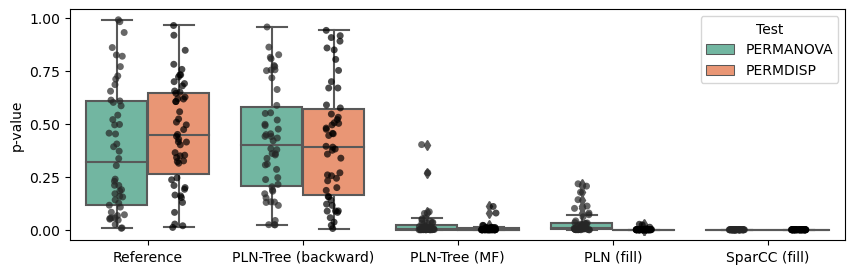

In [47]:
layer = 2
plot_test_pvalues(
    [permanova_pvalues_layers[layer], permdisp_pvalues_layers[layer]], 
    ['PERMANOVA', 'PERMDISP'], logscale=False, figsize=(10, 3)
)
savefig(f'{prefix}_pvalues_distrib_layer{layer+selected_layers[0]}')

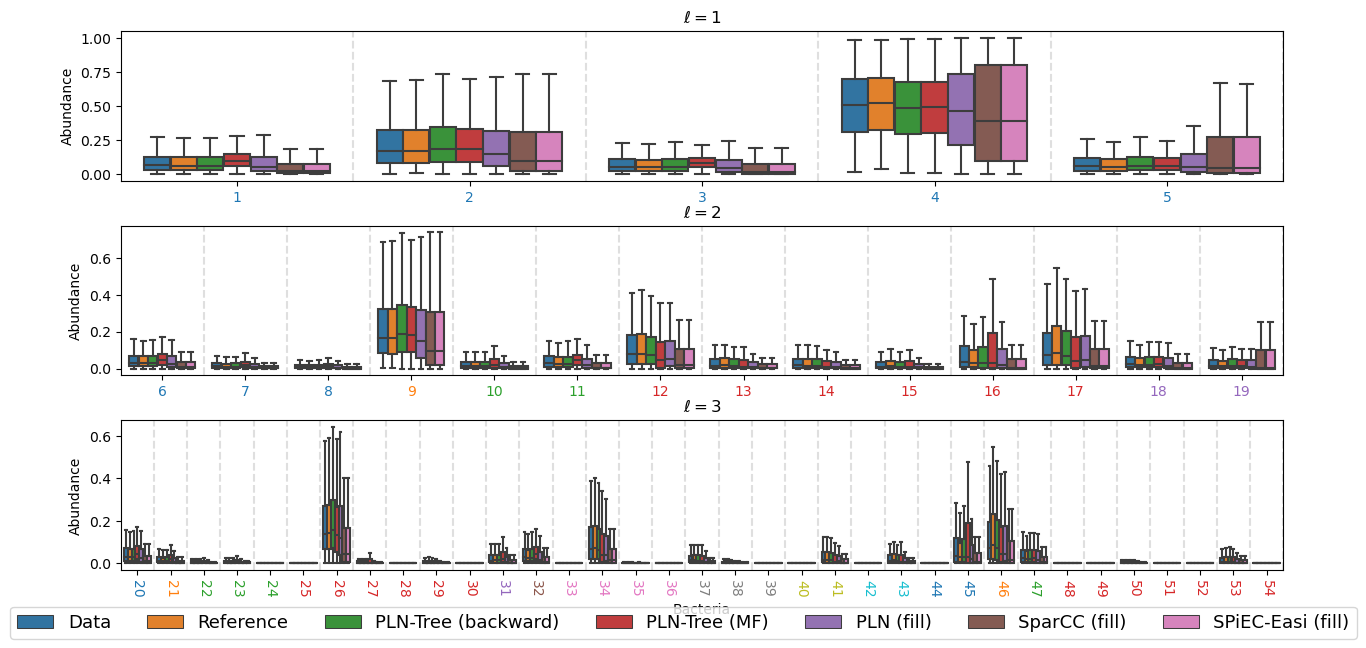

In [39]:
X_comp = [to_proportion(X_, base.K) for X_ in X_list]
vizualize_entities_distributions(base, X_comp, groups, title='Abundance', figsize=(15, 7))

In [40]:
print('Distribution of samples distance: Wasserstein')
compute_distribution_distance(to_proportion(X_base, base.K), X_comp, 25, groups, base.K, distance=emd)

Distribution of samples distance: Wasserstein


#### Identifiability

In [67]:
Z_plntree_offset = add_offset(Z_plntree, O_plntree)
Z_base_offset = add_offset(Z_base, O_base)

Z_base_multinomial = multinomial_probas(Z_base, base)
Z_plntree_multinomial = multinomial_probas(Z_plntree, base)

zooms = [
    [(-3, 3), (-12, 12), (-50, 50)], # X zooms
    [(-3, 3), (-1.5, 1.5), (-1.5, 1.5)], # sigma(Z) zooms
    [(-3, 3), (-10, 10), (-38, 35)] # Z zooms
]

import numpy as np
import matplotlib.pyplot as plt

# Compute the kernel density estimate for each distribution
from scipy.stats import gaussian_kde
def countour(data, ax, scale_min, scale_max, label, n_levels=5, n_points=100, color='C0'):

    # Create a meshgrid for the contour plot
    x = np.linspace(scale_min, scale_max, n_points)
    y = np.linspace(scale_min, scale_max, n_points)
    X, Y = np.meshgrid(x, y)
    
    kde_list = []
    kde = gaussian_kde(data.T)
    Z = kde(np.vstack([X.ravel(), Y.ravel()])).reshape(X.shape)
    ax.contour(X, Y, Z, alpha=0.8, levels=n_levels, cmap=color, label=label)
    ax.grid(False)

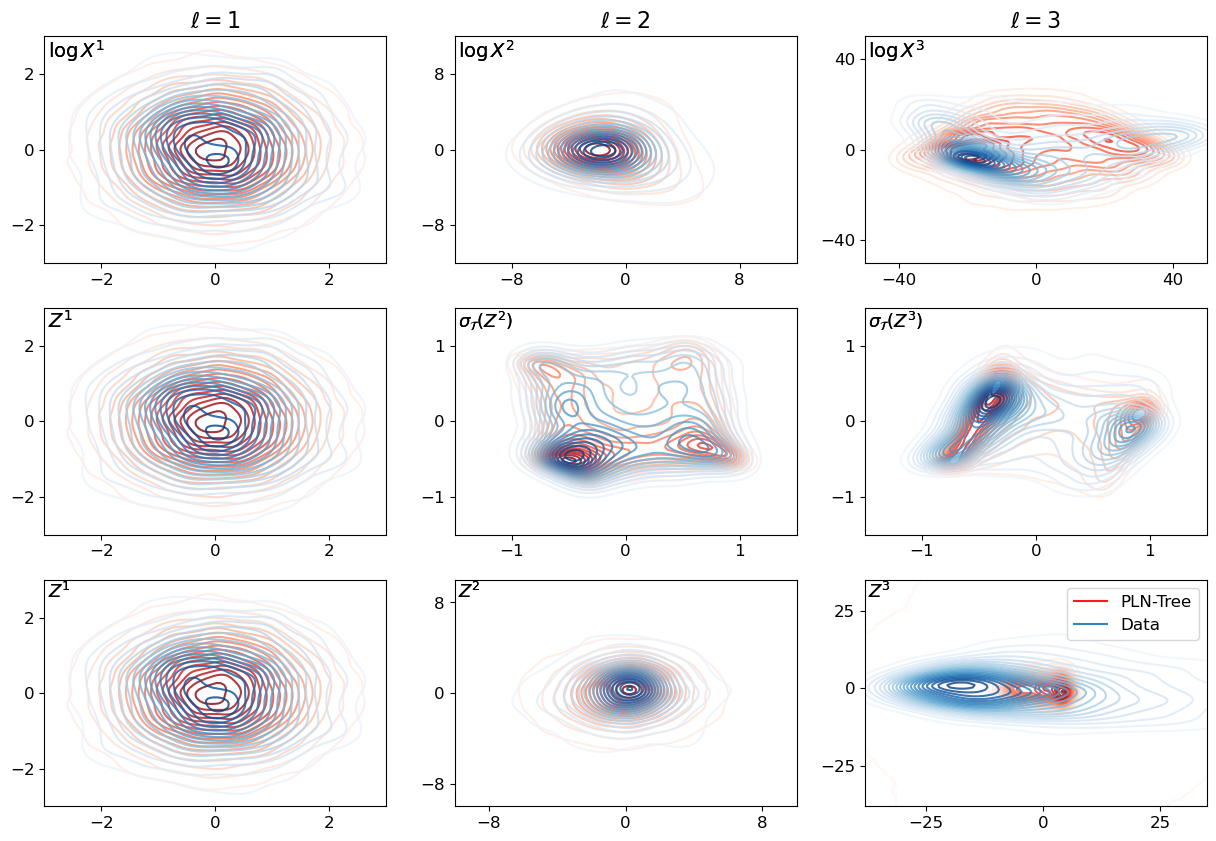

In [68]:
from sklearn.decomposition import PCA
import matplotlib.lines as mlines

def identifiability_plot(X_list, Z_soft_list, Z_list, groups, colors, chart_color, zooms):
    fig, axs = plt.subplots(3, len(base.K), figsize=(15, 10))

    for group, color, X, Z_soft, Z in zip(groups, colors, X_list, Z_soft_list, Z_list):
        for layer, mask in enumerate(base.layer_masks):
            pca = PCA(n_components=2)
            n_levels = 20
            X_pca = pca.fit_transform(torch.log(X[:, layer, mask] + 1e-6).numpy())
            Z_soft_pca = pca.fit_transform(Z_soft[:, layer, mask].numpy())
            Z_pca = pca.fit_transform(Z[:, layer, mask].numpy())
            countour(X_pca, axs[0][layer], scale_min=zooms[0][layer][0], scale_max=zooms[0][layer][1], n_levels=n_levels, n_points=100, color=color, label=group)
            countour(Z_soft_pca, axs[1][layer], scale_min=zooms[1][layer][0], scale_max=zooms[1][layer][1], n_levels=n_levels, n_points=100, color=color, label=group)
            countour(Z_pca, axs[2][layer], scale_min=zooms[2][layer][0], scale_max=zooms[2][layer][1], n_levels=n_levels, n_points=100, color=color, label=group)
            p_layer = layer + base.selected_layers[0]
            plt.text(.01, .99, f'$\log X^{p_layer}$', ha='left', va='top', transform=axs[0][layer].transAxes, fontsize=14)
            if layer == 0:
                plt.text(.01, .99, f'$Z^{p_layer}$', ha='left', va='top', transform=axs[1][layer].transAxes, fontsize=14)
            else:
                plt.text(.01, .99, '$\sigma_{\mathcal{T}}($' + f'$Z^{p_layer})$', ha='left', va='top', transform=axs[1][layer].transAxes, fontsize=13)
            plt.text(.01, .99, f'$Z^{p_layer}$', ha='left', va='top', transform=axs[2][layer].transAxes, fontsize=13)
            axs[0][layer].set_title('$\ell =$' + str(p_layer), fontsize=16)
            for ax in axs:
                ax[layer].xaxis.set_major_locator(plt.MaxNLocator(3))
                ax[layer].yaxis.set_major_locator(plt.MaxNLocator(3))
                ax[layer].tick_params(labelsize=12)
    legend_handles = [
        mlines.Line2D([], [], color=color, alpha=0.9, label=group)
        for color, group in zip(chart_color, groups)
    ]
    legend = plt.legend(handles=legend_handles, fontsize="12")

identifiability_plot(
    (X_plntree, X_base), 
    (Z_plntree_multinomial.detach(), Z_base_multinomial.detach()), 
    (Z_plntree_offset.detach(), Z_base_offset.detach()), 
    ['PLN-Tree', 'Data'], ['Reds', 'Blues'], ['red', 'C0'], zooms)
savefig(f"synthetic_plntree_identifiability_empirical")

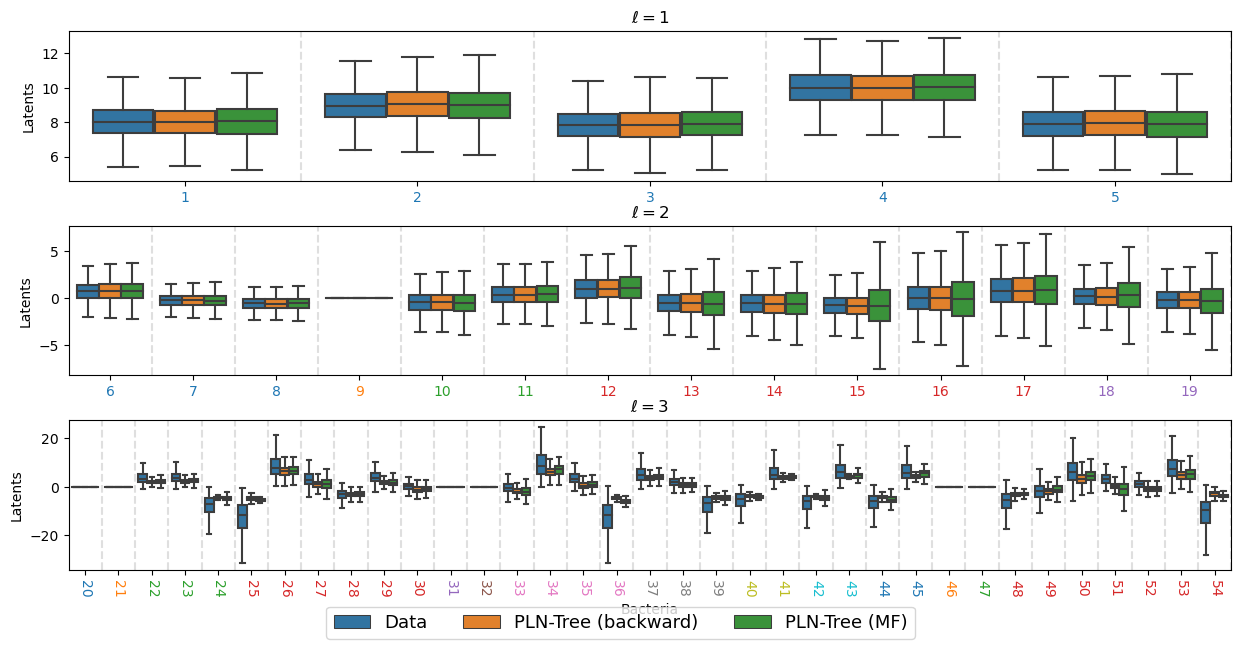

In [69]:
Z_plntree_offset = add_offset(Z_plntree, O_plntree)
Z_meanfield_offset = add_offset(Z_meanfield, O_meanfield)
Z_base_offset = add_offset(Z_base, O_base)

Z_list = (Z_base_offset.detach(), Z_plntree_offset.detach(), Z_meanfield_offset.detach())
groups = ['Data', 'PLN-Tree (backward)', 'PLN-Tree (MF)']
vizualize_entities_distributions(base, Z_list, groups, title='Latents', figsize=(15, 7))

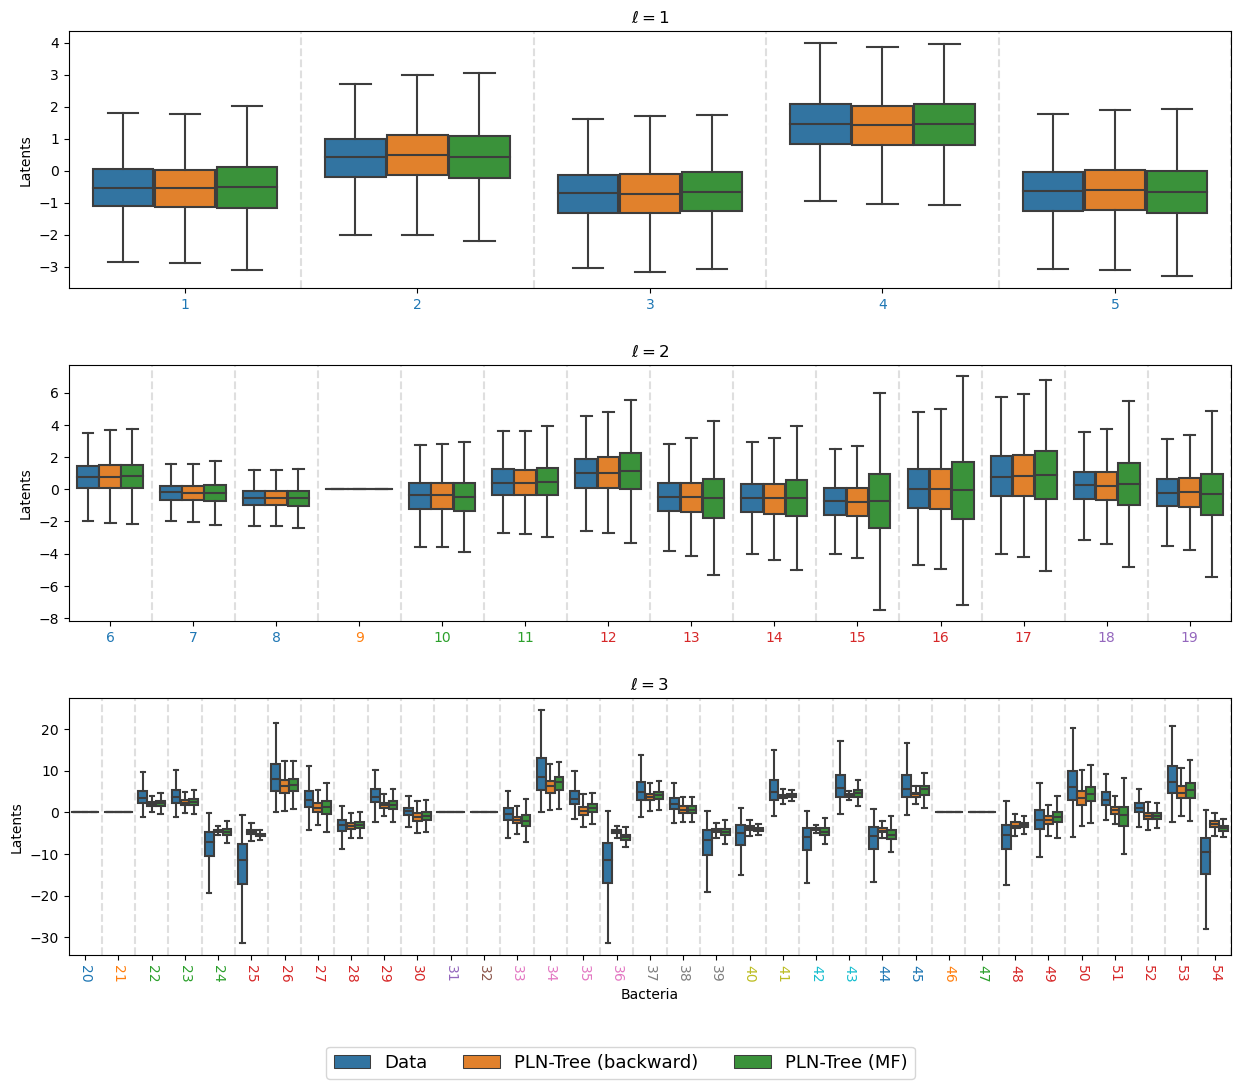

In [70]:
from plntree.utils.model_utils import Vect1OrthogonalProjectorHierarchical

Z_plntree_offset = add_offset(Z_plntree, O_plntree)
Z_meanfield_offset = add_offset(Z_meanfield, O_meanfield)
Z_base_offset = add_offset(Z_base, O_base)

Z_plntree_offset_identifiable = identifiable_projector(base, Z_plntree_offset)
Z_meanfield_offset_identifiable = identifiable_projector(base, Z_meanfield_offset)
Z_base_offset_identifiable = identifiable_projector(base, Z_base_offset)
    
Z_list = (Z_base_offset_identifiable.detach(), Z_plntree_offset_identifiable.detach(), Z_meanfield_offset_identifiable.detach())
groups = ['Data', 'PLN-Tree (backward)', 'PLN-Tree (MF)']
vizualize_entities_distributions(base, Z_list, groups, title='Latents', figsize=(15, 12))

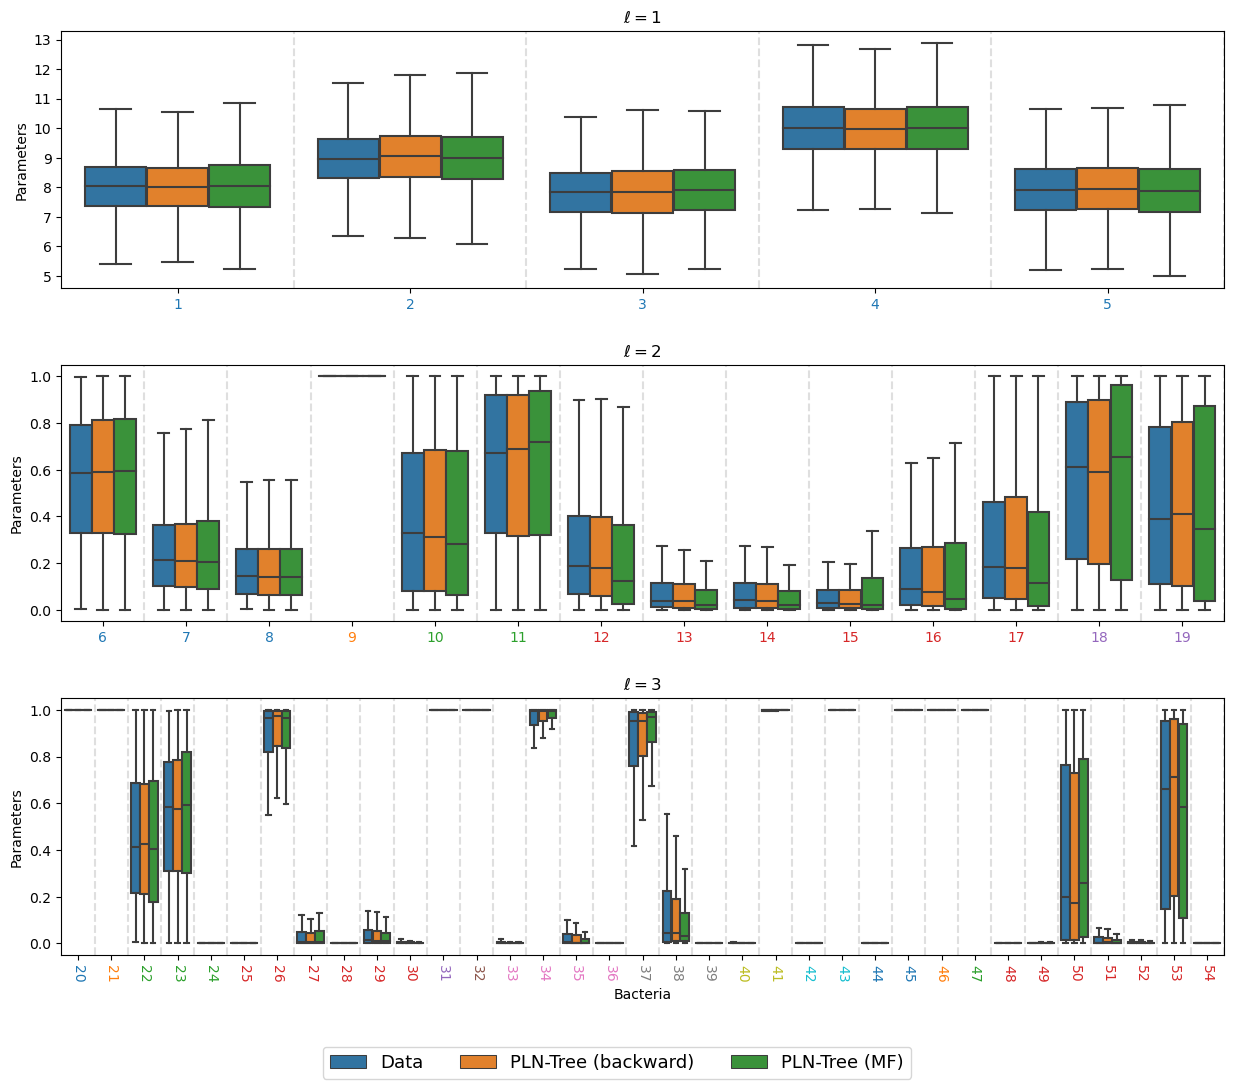

In [71]:
Z_plntree_offset = add_offset(Z_plntree, O_plntree)
Z_meanfield_offset = add_offset(Z_meanfield, O_meanfield)
Z_base_offset = add_offset(Z_base, O_base)

Z_plntree_multinomial = multinomial_probas(Z_plntree_offset, base)
Z_meanfield_multinomial = multinomial_probas(Z_meanfield_offset, base)
Z_base_multinomial = multinomial_probas(Z_base_offset, base)

Z_list = (Z_base_multinomial.detach(), Z_plntree_multinomial.detach(), Z_meanfield_multinomial.detach())
groups = ['Data', 'PLN-Tree (backward)', 'PLN-Tree (MF)']
vizualize_entities_distributions(base, Z_list, groups, title='Parameters', figsize=(15, 12))

#### Encoding benchmark

In [72]:
X_test, Z_test, O_test = base.sample(1000, seed=seed)

Z_meanfield_enc, O_meanfield_enc = meanfield.encode(X_test, seed=seed)
X_meanfield_enc = meanfield.decode(Z_meanfield_enc, O_meanfield_enc, seed=seed)

Z_plntree_enc, O_plntree_enc = plntree.encode(X_test, seed=seed)
X_plntree_enc = plntree.decode(Z_plntree_enc, O_plntree_enc, seed=seed)

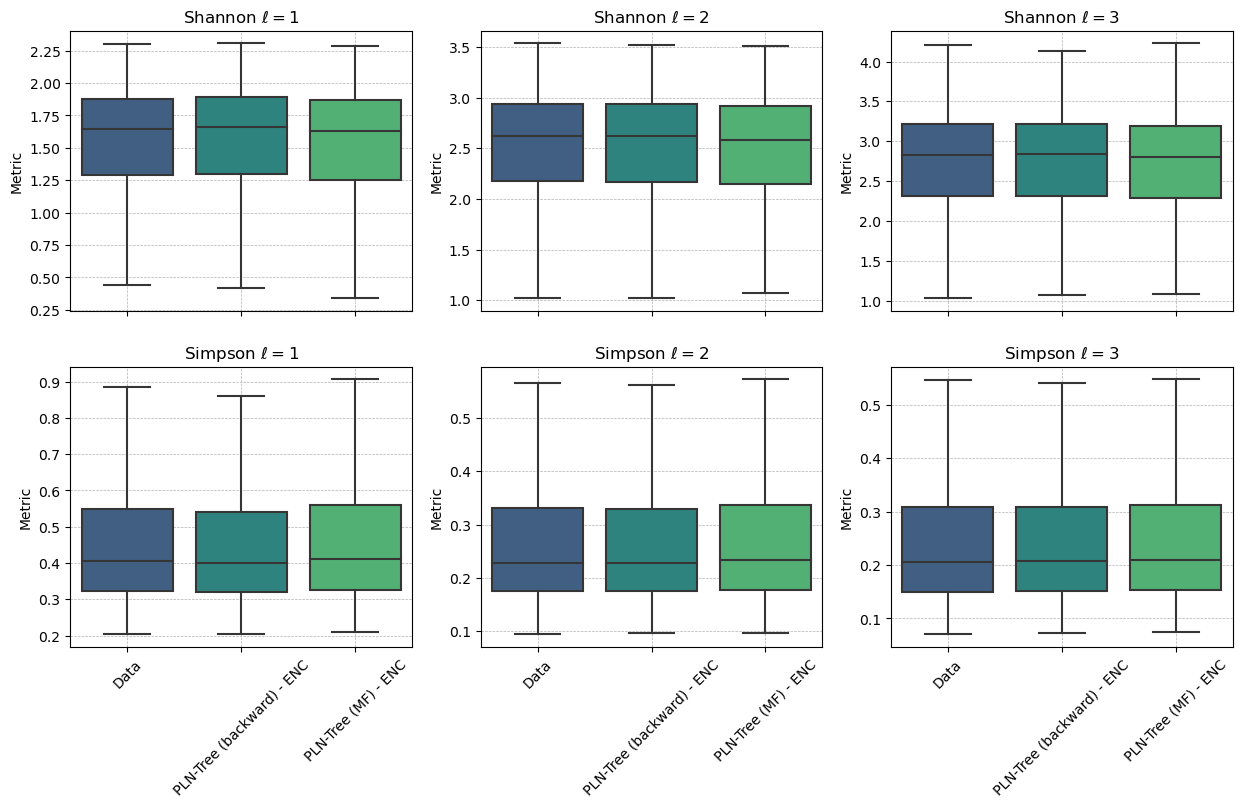

In [73]:
X_list = (X_test, X_plntree_enc, X_meanfield_enc)
groups = ['Data', 'PLN-Tree (backward) - ENC', 'PLN-Tree (MF) - ENC']
colors = [viridis(0.3), viridis(0.5), viridis(0.7)]

plot_alpha_diversity(
    X_list,
    tree,
    offset_layer=base.selected_layers[0],
    groups_name=groups,
    colors=colors,
    style='boxplot',
    saveName=f'synthetic_plntree_encodings'
)

In [74]:
print('Wasserstein Distance')
compute_alpha_distance(X_list, tree, groups, offset_layer=base.selected_layers[0], distance=wasserstein_distance)

Wasserstein Distance


In [75]:
X_comp = (X_plntree_enc, X_meanfield_enc)
groups = ['PLN-Tree (backward)', 'PLN-Tree (MF)']
for group, X_c in zip(groups, X_comp):
    print(f'Correlation against {group}:')
    correlations = correlation(X_test, X_c, base)
    for layer, corr in enumerate(correlations):
        print(f'  * layer = {layer+base.selected_layers[0]}:', corr.mean().item(), '±', corr.std().item())

Correlation against PLN-Tree (backward):
  * layer = 1: 0.9995470525828432 ± 0.0017746403921946273
  * layer = 2: 0.9935099115215095 ± 0.05027722379717116
  * layer = 3: 0.9966018743849904 ± 0.020411299061561423
Correlation against PLN-Tree (MF):
  * layer = 1: 0.9986356980575213 ± 0.0035844098990182034
  * layer = 2: 0.9927169536741873 ± 0.07163597275331371
  * layer = 3: 0.9948214416205053 ± 0.05098818415155021


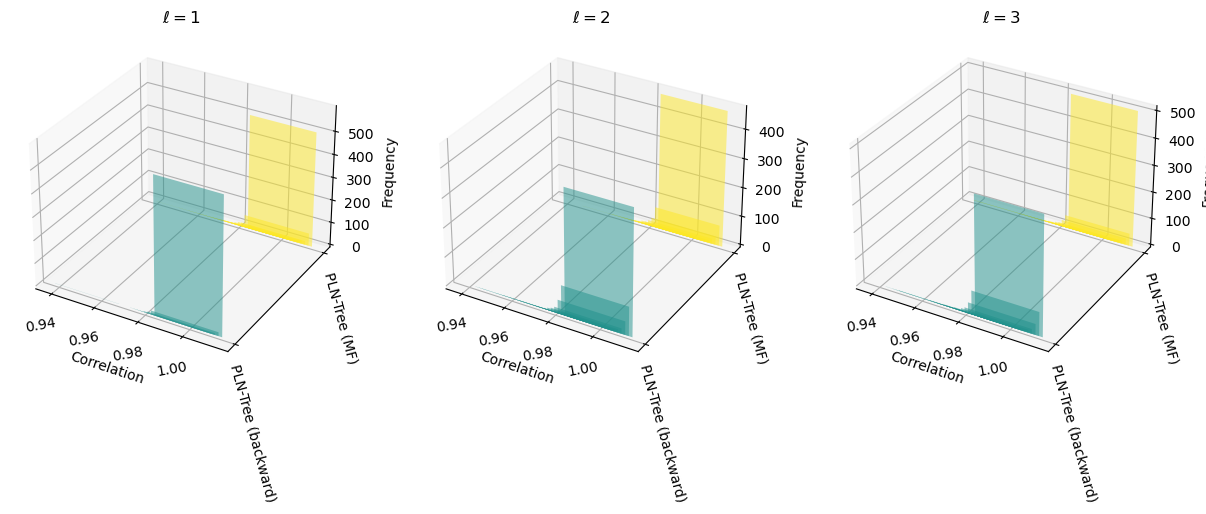

In [76]:
correlation_3d_plot(X_test, X_comp, groups, base, saveName='')

In [77]:
for group, X_c in zip(groups, X_comp):
    m = mae_tree(to_proportion(X_test, base.K), to_proportion(X_c, base.K), base.K)
    print(f'MAE against {group}:', m.mean(), f'(± {m.std()})')

MAE against PLN-Tree (backward): tensor(0.0040) (± nan)
MAE against PLN-Tree (MF): tensor(0.0048) (± nan)


<h2 style="color:#333333; font-family:Arial, sans-serif; font-size:24px; font-weight:bold; margin-top:24px; margin-bottom:12px;">Markovian Dirichlet propagation data</h2>

### Model choice and data generation

In [13]:
seed = 1
prefix = f'synthetic_markovdirichlet_s{seed}'

seed_all(seed)

In [14]:
K = [1, 6, 17, 40]

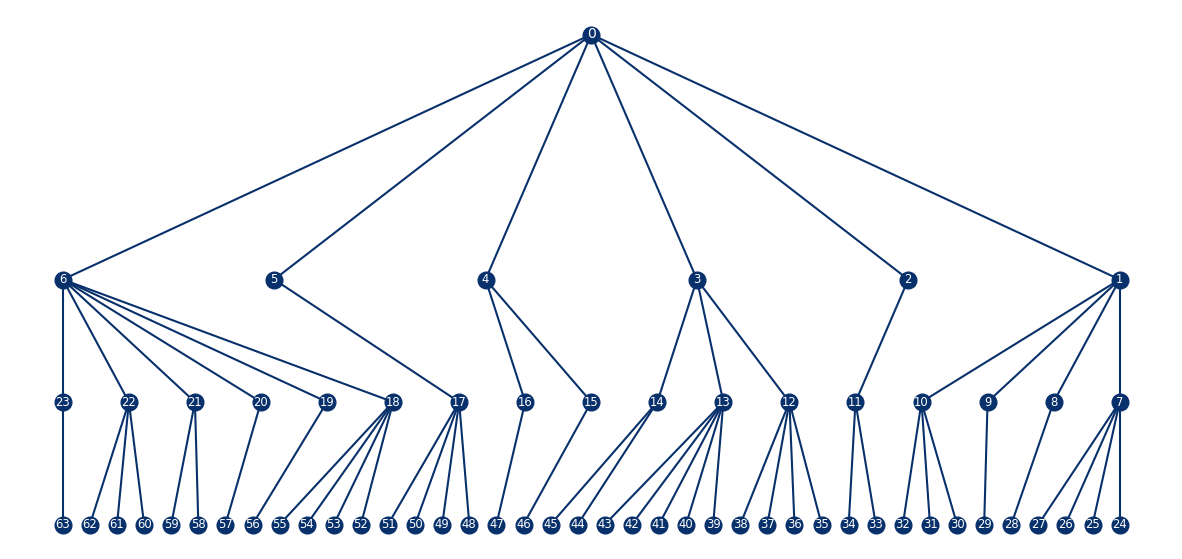

In [15]:
tree = generate_hierachical_tree(K, seed=seed)
tree.plot(legend=False, title='')

selected_layers = [1, -1]
K =  list(tree.getLayersWidth().values())[selected_layers[0]:]

savefig('synthetic_dirichlet_tree_graph')

In [16]:
G = artificial_loader.generate_adjacency_matrix(K[0], method='erdos_renyi')
Omega = artificial_loader.generate_precision_matrix(G, conditioning=0.1, correlation=0.7) * 5
mu = [-0.2, 0., -0.1, 0.2, 0.3, 0.1]
offset_total_count = 20_000
offset_probs = 0.6
    
alpha_structures = None
    
n_samples = 2_000
n_samples_test = 1_000
X = artificial_loader.generate_markov_dirichlet_hierarchical_data(
    n_samples+n_samples_test, tree, selected_layers, Omega, mu, offset_total_count, offset_probs, alpha_structures,
    seed=seed
)
X_base = X[:n_samples]
X_test = X[n_samples:n_samples+n_samples_test]
X_synthetic_markovdirichlet = X_base

In [6]:
from torch.utils.data import DataLoader, TensorDataset

batch_size = 512
seed_all(seed)
dataset = TensorDataset(X_base, X_base)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

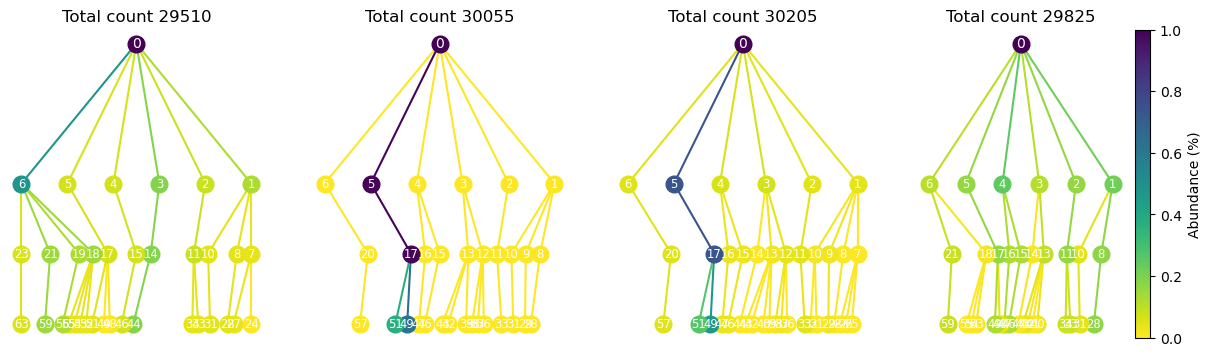

In [7]:
vizualize_samples(dataloader, tree, autofill=True, seed=seed)
savefig('synthetic_dirichlet_samples')

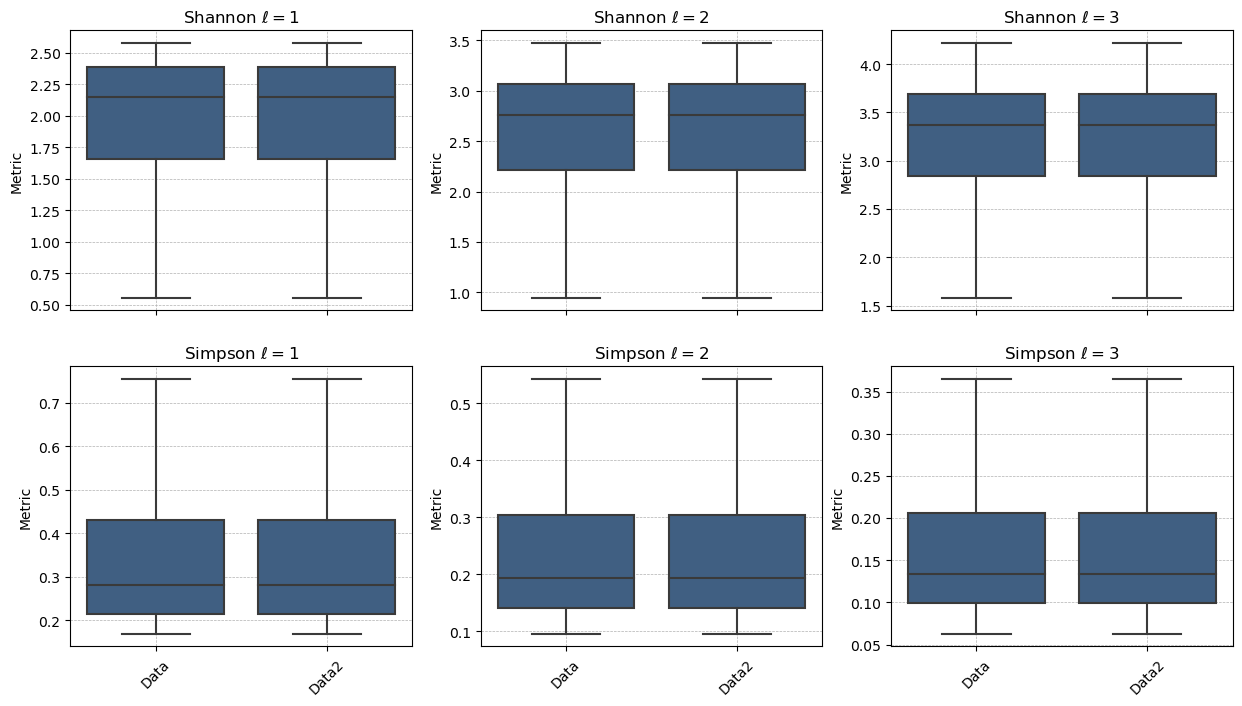

In [8]:
X_list = (X_base, X_base)
groups = ['Data', 'Data2']
colors = [viridis(0.3), viridis(0.3)]

plot_alpha_diversity(
    X_list,
    tree,
    offset_layer=selected_layers[0],
    groups_name=groups,
    colors=colors,
    style='boxplot'
)

### Benchmark models

#### PLN

Setting the offsets as the log of the sum of endog
Fitting a Pln model with full covariance model.
Initialization ...
Initialization finished
Tolerance 1e-08 reached in 843 iterations
Setting the offsets as the log of the sum of endog
Fitting a Pln model with full covariance model.
Initialization ...
Initialization finished
Tolerance 1e-08 reached in 807 iterations
Setting the offsets as the log of the sum of endog
Fitting a Pln model with full covariance model.
Initialization ...
Initialization finished
Tolerance 1e-08 reached in 779 iterations
Likelihood: -112693.31843960285


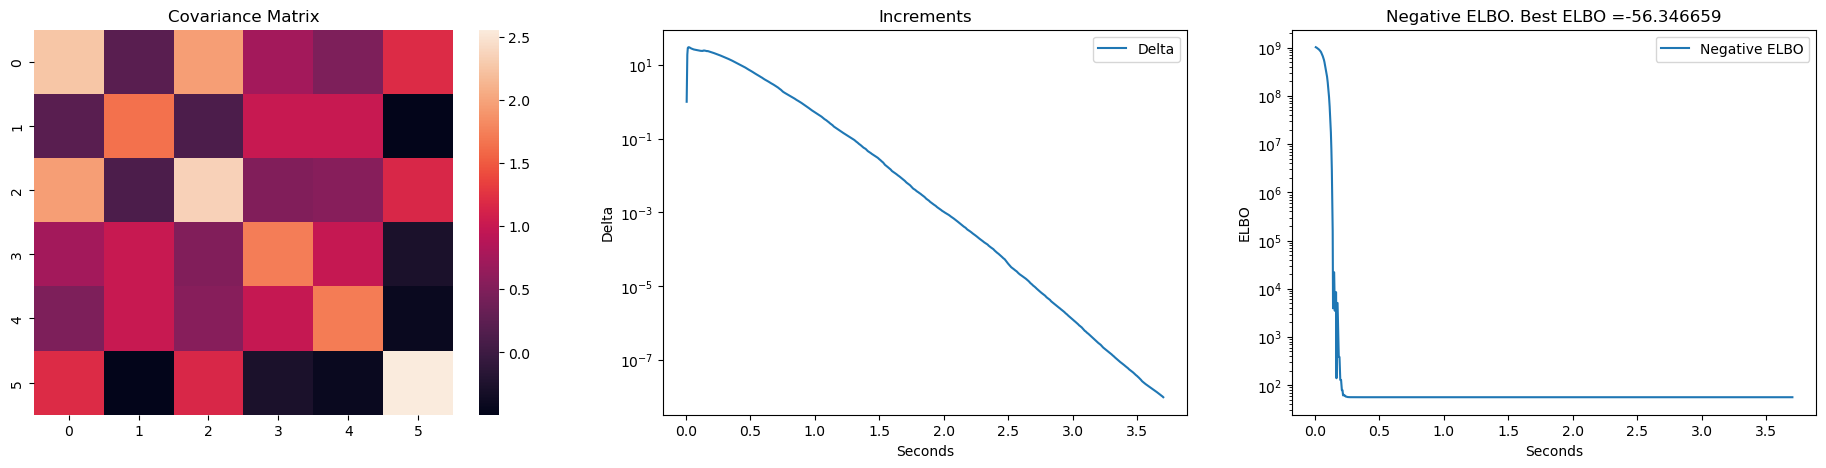

Likelihood: -208010.54610586166


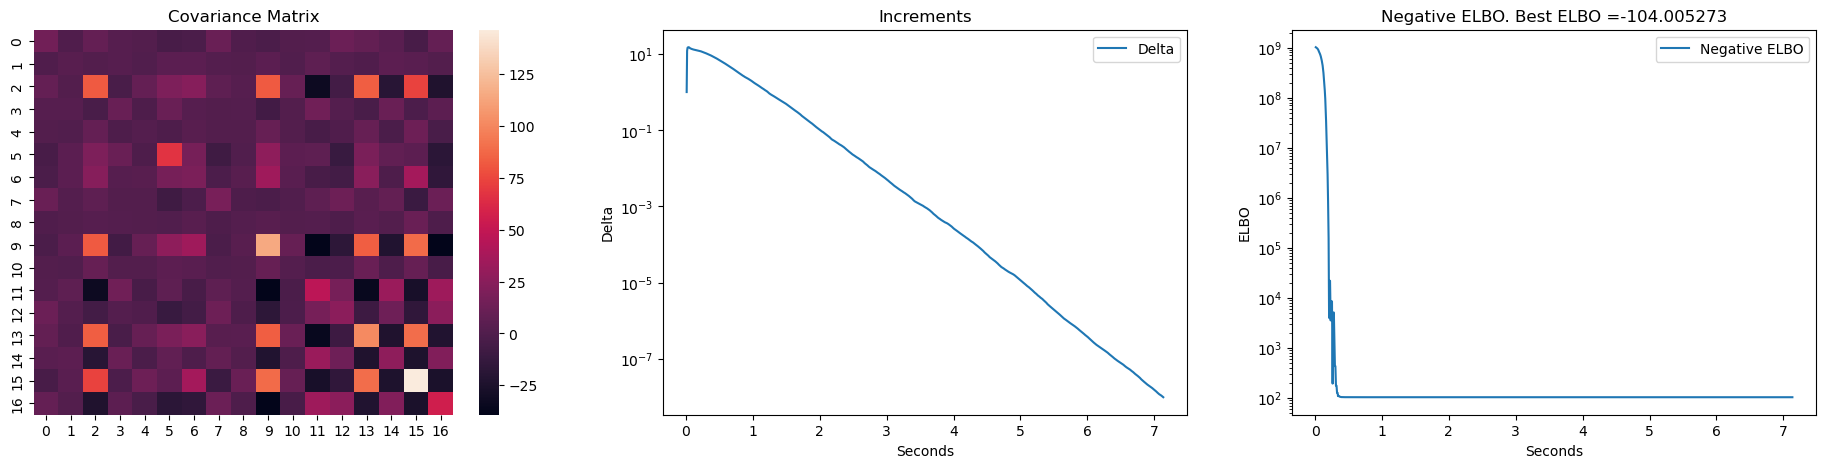

Likelihood: -336611.2490928173


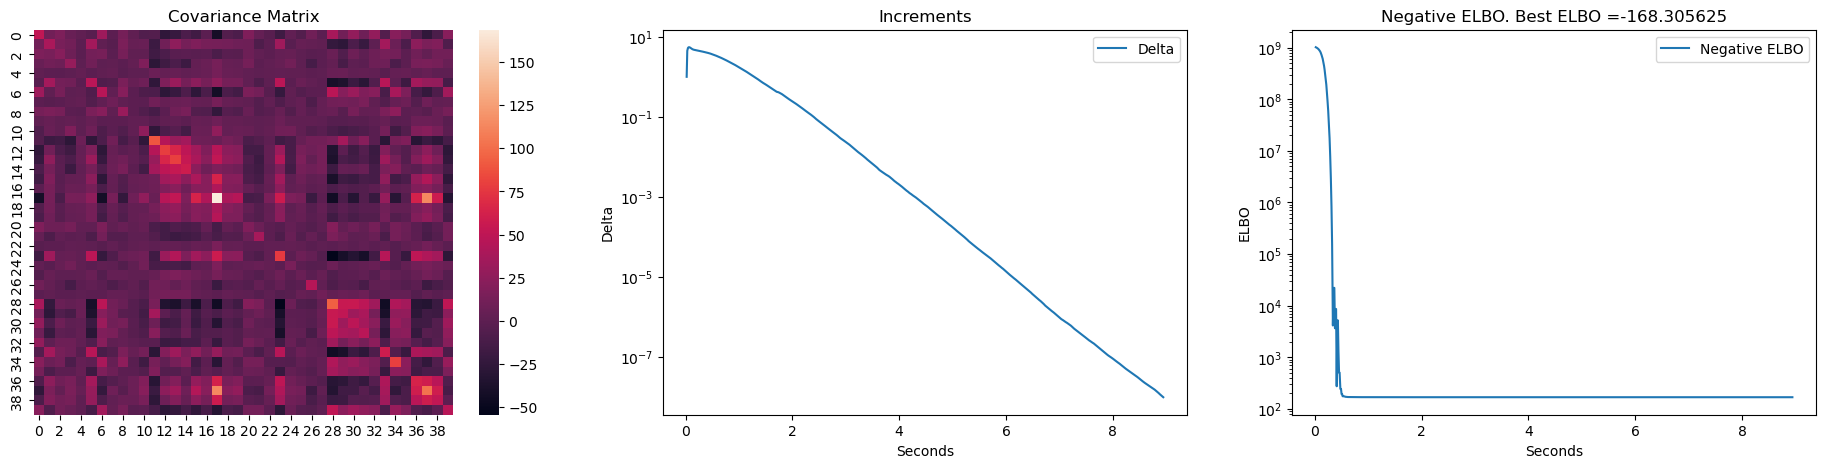

In [9]:
pln_layers = learn_pln(X_base, K, seed=seed)

In [10]:
n_samples = 50_000
X_pln, Z_pln, X_pln_fill, X_pln_enc, Z_pln_enc, X_pln_enc_fill = generate_pln_data(pln_layers, n_samples, K, selected_layers, X_base, tree, seed=seed)

Can not compute Poisson with parameters [47.78142436]
Values will be shifted to 43 to avoid overflow (only the offset is affected).
Can not compute Poisson with parameters [47.23648061]
Values will be shifted to 43 to avoid overflow (only the offset is affected).
Can not compute Poisson with parameters [45.93672231]
Values will be shifted to 43 to avoid overflow (only the offset is affected).


##### SparCC

In [11]:
# SparCC
sparCC_layers = learn_per_layer_sparCC(to_proportion(X_base, K), K)
X_sparCC, X_sparCC_fill = sample_model_layers(sparCC_layers, n_samples, K, selected_layers, tree, seed=seed)

##### SPiEC-Easi

In [12]:
# SPiEC-Easi
spiec_layers = learn_per_layer_spiec_easi(
    to_proportion(X_base, K), K, {'alpha':0.07, 'max_iter':10_000, 'mode':'cd'}, seed=seed
)
X_spiec, X_spiec_fill = sample_model_layers(spiec_layers, n_samples, K, selected_layers, tree, seed=seed)

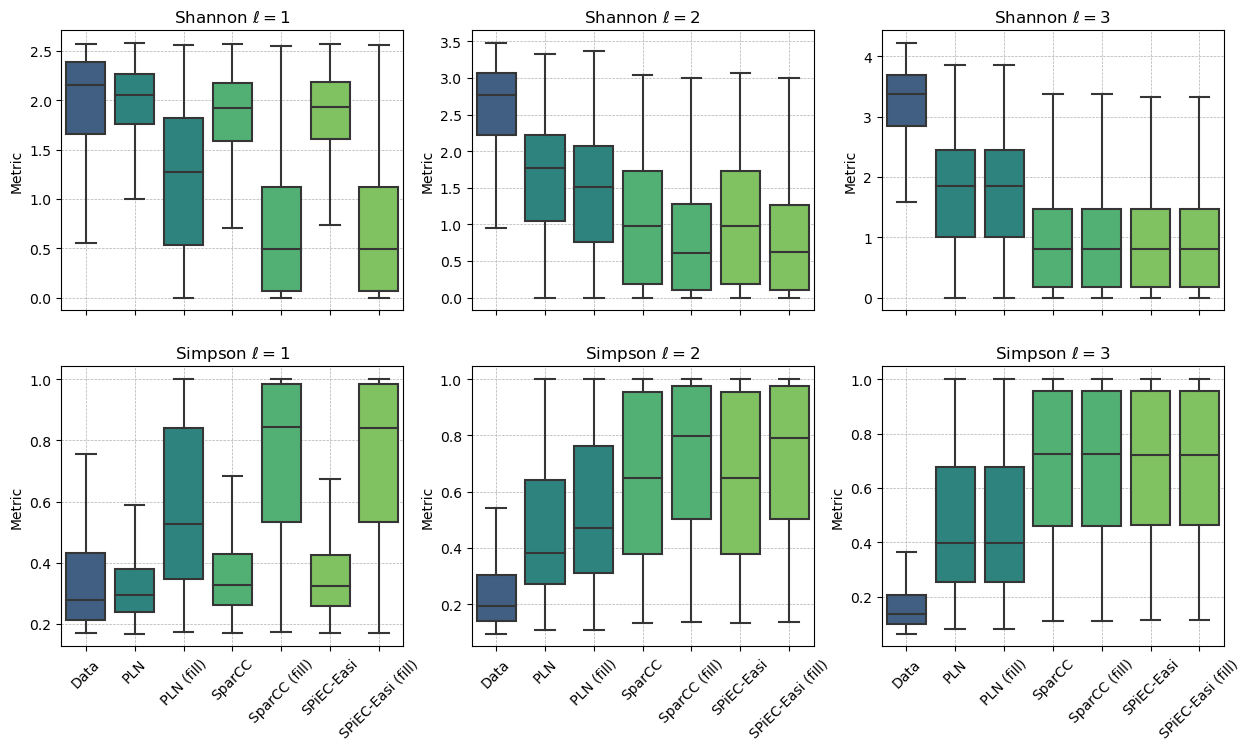

In [24]:
X_list = (X_base, X_pln, X_pln_fill, X_sparCC, X_sparCC_fill, X_spiec, X_spiec_fill)
groups = ['Data', 'PLN', 'PLN (fill)', 'SparCC', 'SparCC (fill)', 'SPiEC-Easi', 'SPiEC-Easi (fill)']
colors = [viridis(0.3), viridis(0.5), viridis(0.5), viridis(0.7), viridis(0.7), viridis(0.8), viridis(0.8)]

plot_alpha_diversity(
    X_list,
    tree,
    offset_layer=selected_layers[0],
    groups_name=groups,
    colors=colors,
    style='boxplot'
)

#### PLN-Tree Mean Field

##### Model selection

In [13]:
preprocessing = 'log'
def learn_plntree_mean_field(n_latent_layers, variational_approx_params):
    estimator = PLNTree(
        tree=tree,
        selected_layers=selected_layers,
        diag_smoothing_factor=1e-4,
        positive_fun='softplus',
        offset_method='constant',
        identifiable=True,
        variational_approx='mean_field',
        variational_approx_params=variational_approx_params,
        n_latent_layers=n_latent_layers,
        seed=seed
    )

    optimizer = optim.Adam(
        estimator.parameters(),
        lr=1e-3,
    )
    n_epoch = 15_000
    return estimator.fit(optimizer, dataloader, n_epoch=n_epoch, verbose=100, max_grad_norm=5.)

In [14]:
variational_approx_params_list = [
    (1, {'n_variational_layers': 1, 'preprocessing': [preprocessing]}),
    (1, {'n_variational_layers': 2, 'preprocessing': [preprocessing]}),
    (2, {'n_variational_layers': 1, 'preprocessing': [preprocessing]}),
    (2, {'n_variational_layers': 2, 'preprocessing': [preprocessing]}),
    (3, {'n_variational_layers': 1, 'preprocessing': [preprocessing]}),
    (3, {'n_variational_layers': 2, 'preprocessing': [preprocessing]}),
]

In [15]:
meanfields = []
for n_latent_layers, variational_approx_params in variational_approx_params_list:
    try:
        meanfield, meanfield_losses = load_pkl(prefix, f'mean_field-{preprocessing}_nlatent-{n_latent_layers}-nvar-{variational_approx_params["n_variational_layers"]}')
    except:
        print('Learning PLN-Tree (MF)')
        print(variational_approx_params)
        meanfield, meanfield_losses = learn_plntree_mean_field(n_latent_layers, variational_approx_params)
        save_pkl((meanfield, meanfield_losses), prefix, f'mean_field-{preprocessing}_nlatent-{n_latent_layers}-nvar-{variational_approx_params["n_variational_layers"]}')
    meanfields.append([meanfield, meanfield_losses])

Loading file ./experiments/saves/synthetic_markovdirichlet_s1_mean_field-log_nlatent-1-nvar-1.pkl
Loading file ./experiments/saves/synthetic_markovdirichlet_s1_mean_field-log_nlatent-1-nvar-2.pkl
Loading file ./experiments/saves/synthetic_markovdirichlet_s1_mean_field-log_nlatent-2-nvar-1.pkl
Loading file ./experiments/saves/synthetic_markovdirichlet_s1_mean_field-log_nlatent-2-nvar-2.pkl
Loading file ./experiments/saves/synthetic_markovdirichlet_s1_mean_field-log_nlatent-3-nvar-1.pkl
Loading file ./experiments/saves/synthetic_markovdirichlet_s1_mean_field-log_nlatent-3-nvar-2.pkl


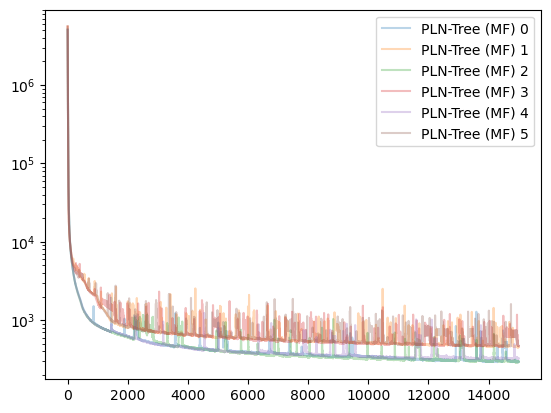

In [28]:
fig, axs = plt.subplots()
for k, (meanfield, losses) in enumerate(meanfields):
    axs.plot(losses, label=f'PLN-Tree (MF) {k}', alpha=0.3)
axs.set_yscale('log')
plt.legend()
savefig(f'{prefix}_ELBO_meanfields_selection')

In [29]:
n_samples = 15_000
meanfields_samples = {}
for key, (meanfield, losses) in enumerate(meanfields):
    X_meanfield, Z_meanfield, O_meanfield = meanfield.sample(n_samples, seed=seed)
    meanfields_samples[key] = X_meanfield

Generated batch size: 14987
Generated batch size: 14987
Generated batch size: 14987


In [30]:
X_list = [X_base] + list(meanfields_samples.values())
groups = ['Data'] + [f'MF {k}' for k in range(len(meanfields))]
colors = [viridis(0.3)] + [viridis(0.3 + (k+1)/9) for k in range(len(meanfields))]

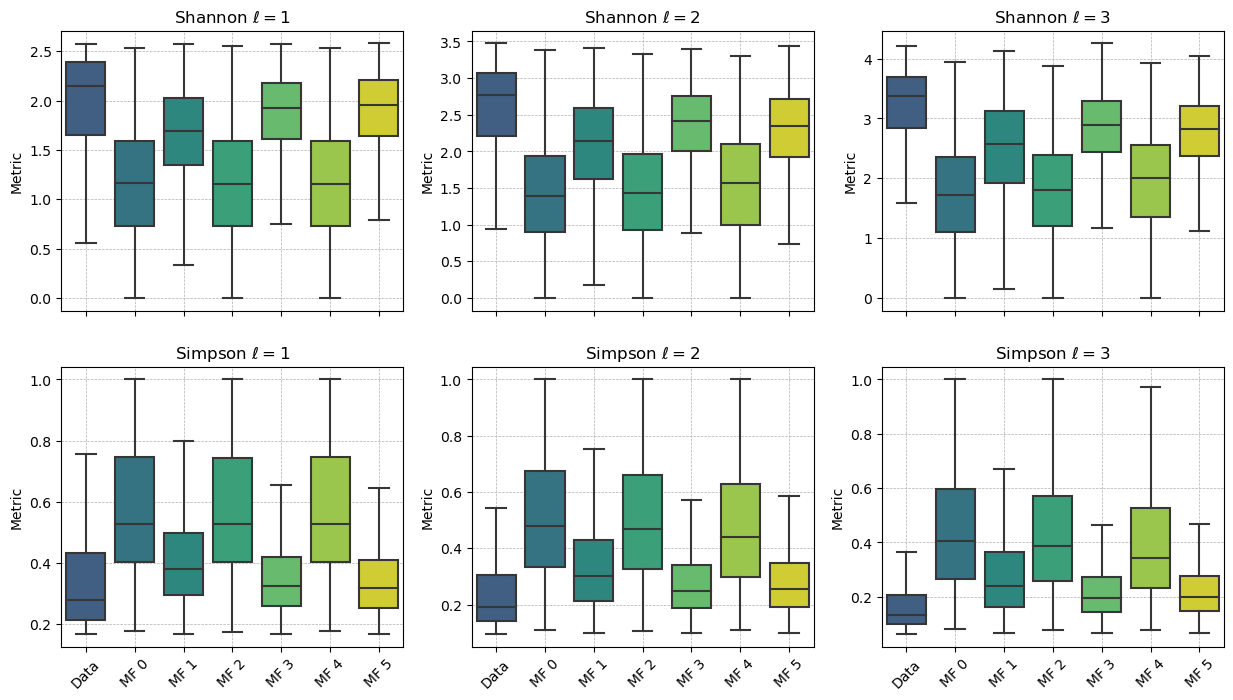

In [31]:
plot_alpha_diversity(
    X_list,
    tree,
    offset_layer=selected_layers[0],
    groups_name=groups,
    colors=colors,
    style='boxplot',
)

In [32]:
print('Wasserstein Distance')
repeated_metric_compute(
    tree, X_base, X_list[1:], groups[1:], 
    n_split=5, distance=wasserstein_distance, offset_layer=selected_layers[0], order=True
)

Wasserstein Distance


In [33]:
print('Kullback-Leilber')
repeated_metric_compute(
    tree, X_base, X_list[1:], groups[1:], 
    n_split=5, distance=kl_divergence, offset_layer=selected_layers[0], order=True
)

Kullback-Leilber


In [34]:
print('Kolmogorov-Smirnov')
repeated_metric_compute(
    tree, X_base, X_list[1:], groups[1:], 
    n_split=5, distance=kolmogorov_smirnov, offset_layer=selected_layers[0], order=True
)

Kolmogorov-Smirnov


In [35]:
print('Total variation')
repeated_metric_compute(
    tree, X_base, X_list[1:], groups[1:], 
    n_split=5, distance=total_variation, offset_layer=selected_layers[0], order=True
)

Total variation


##### Selected model training

In [16]:
meanfield, meanfield_losses = meanfields[3]

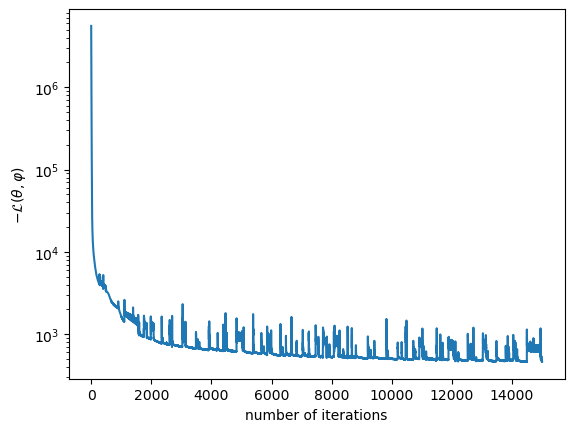

In [17]:
fig, axs = plt.subplots()
axs.plot(meanfield_losses[:])
axs.set_yscale('log')
axs.set_ylabel('$-\mathcal{L}(\\theta, \\varphi)$')
axs.set_xlabel('number of iterations')
savefig(f"synthetic_dirichlet_MF_ELBO")

In [18]:
n_samples = 50_000

X_meanfield, Z_meanfield, O_meanfield = meanfield.sample(n_samples, seed=seed)
Z_meanfield_enc, O_meanfield_enc = meanfield.encode(X_base, seed=seed)
X_meanfield_enc = meanfield.decode(Z_meanfield_enc, O_meanfield_enc, seed=seed)

### Trained models

##### Model selection

In [19]:
preprocessing = 'log'
def learn_plntree(n_latent_layers, variational_approx_params):
    estimator = PLNTree(
        tree=tree,
        selected_layers=selected_layers,
        diag_smoothing_factor=1e-4,
        positive_fun='softplus',
        offset_method='constant',
        identifiable=True,
        variational_approx='residual_backward',
        variational_approx_params=variational_approx_params,
        n_latent_layers=n_latent_layers,
        seed=seed
    )

    optimizer = optim.Adam(
        estimator.parameters(),
        lr=1e-3,
    )
    n_epoch = 15_000
    return estimator.fit(optimizer, dataloader, n_epoch=n_epoch, verbose=100, max_grad_norm=5.)

In [20]:
def embedder_params(embedder_type='GRU', embedding_size=16, n_embedding_layers=2, n_embedding_neurons=32, n_after_layers=2):
    params = {
        'embedder_type': embedder_type,
        'embedding_size': embedding_size,
        'n_embedding_layers': n_embedding_layers,
        'n_embedding_neurons': n_embedding_neurons,
        'n_after_layers': n_after_layers,
        'preprocessing': [preprocessing]
    }
    name = f'{preprocessing}-Emb{embedder_type}-{n_embedding_layers}x{n_embedding_neurons}to{embedding_size}-{n_after_layers}'
    return name, params

embedder_params_list = [
    embedder_params(
        embedder_type='GRU', 
        embedding_size=16, 
        n_embedding_layers=2, 
        n_embedding_neurons=32, 
        n_after_layers=2
    ),
    embedder_params(
        embedder_type='GRU', 
        embedding_size=32, 
        n_embedding_layers=2, 
        n_embedding_neurons=32, 
        n_after_layers=2
    ),
    embedder_params(
        embedder_type='GRU', 
        embedding_size=32, 
        n_embedding_layers=3, 
        n_embedding_neurons=32, 
        n_after_layers=2
    ),
    embedder_params(
        embedder_type='GRU', 
        embedding_size=32, 
        n_embedding_layers=2, 
        n_embedding_neurons=64, 
        n_after_layers=2
    ),
    embedder_params(
        embedder_type='GRU', 
        embedding_size=32, 
        n_embedding_layers=3, 
        n_embedding_neurons=64, 
        n_after_layers=2
    ),
    embedder_params(
        embedder_type='GRU', 
        embedding_size=32, 
        n_embedding_layers=3, 
        n_embedding_neurons=64, 
        n_after_layers=2
    ),
    embedder_params(
        embedder_type='GRU', 
        embedding_size=60, 
        n_embedding_layers=2, 
        n_embedding_neurons=64, 
        n_after_layers=2
    ),
    embedder_params(
        embedder_type='GRU', 
        embedding_size=60, 
        n_embedding_layers=3, 
        n_embedding_neurons=64, 
        n_after_layers=2
    ),
    embedder_params(
        embedder_type='GRU', 
        embedding_size=60, 
        n_embedding_layers=3, 
        n_embedding_neurons=120, 
        n_after_layers=2
    ),
]

latent_prior_sizes = [1, 2]

variational_approx_params_dict = {}
for n_latent_layers in latent_prior_sizes:
    for name, embedder_params in embedder_params_list:
        variational_approx_params_dict[f'{n_latent_layers}-{name}'] = (n_latent_layers, embedder_params)

In [21]:
backwards = {}
i = 0
for k, (n_latent_layers, variational_approx_params) in variational_approx_params_dict.items():
    i += 1
    try:
        backward, backward_losses = load_pkl(prefix, f'backward_{k}')
    except:
        print('Learning PLN-Tree (MF), n latents', n_latent_layers, '| model', i, '/', len(variational_approx_params_dict))
        print(variational_approx_params)
        backward, backward_losses = learn_plntree(n_latent_layers, variational_approx_params)
        save_pkl((backward, backward_losses), prefix, f'backward_{k}')
    backwards[k] = [backward, backward_losses]

Loading file ./experiments/saves/synthetic_markovdirichlet_s1_backward_1-log-EmbGRU-2x32to16-2.pkl
Loading file ./experiments/saves/synthetic_markovdirichlet_s1_backward_1-log-EmbGRU-2x32to32-2.pkl
Loading file ./experiments/saves/synthetic_markovdirichlet_s1_backward_1-log-EmbGRU-3x32to32-2.pkl
Loading file ./experiments/saves/synthetic_markovdirichlet_s1_backward_1-log-EmbGRU-2x64to32-2.pkl
Loading file ./experiments/saves/synthetic_markovdirichlet_s1_backward_1-log-EmbGRU-3x64to32-2.pkl
Loading file ./experiments/saves/synthetic_markovdirichlet_s1_backward_1-log-EmbGRU-2x64to60-2.pkl
Loading file ./experiments/saves/synthetic_markovdirichlet_s1_backward_1-log-EmbGRU-3x64to60-2.pkl
Loading file ./experiments/saves/synthetic_markovdirichlet_s1_backward_1-log-EmbGRU-3x120to60-2.pkl
Loading file ./experiments/saves/synthetic_markovdirichlet_s1_backward_2-log-EmbGRU-2x32to16-2.pkl
Loading file ./experiments/saves/synthetic_markovdirichlet_s1_backward_2-log-EmbGRU-2x32to32-2.pkl
Loading f

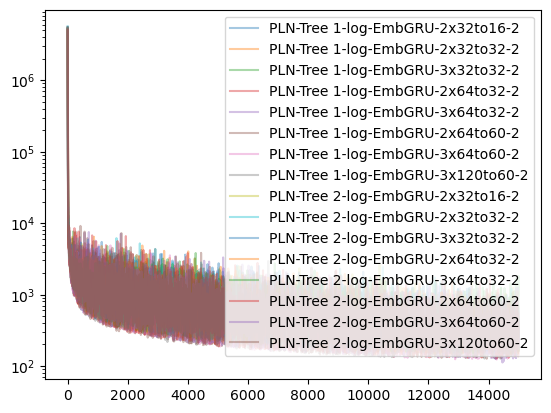

In [42]:
fig, axs = plt.subplots()
for k, (backward, losses) in backwards.items():
    axs.plot(losses, label=f'PLN-Tree {k}', alpha=0.4)
axs.set_yscale('log')
plt.legend()
savefig(f'{prefix}_ELBO_backwards_selection')

In [43]:
n_samples = 15_000
backwards_samples = {}
for key, (backward, losses) in backwards.items():
    X_plntree, Z_plntree, O_plntree = backward.sample(n_samples, seed=seed)
    backwards_samples[key] = X_plntree

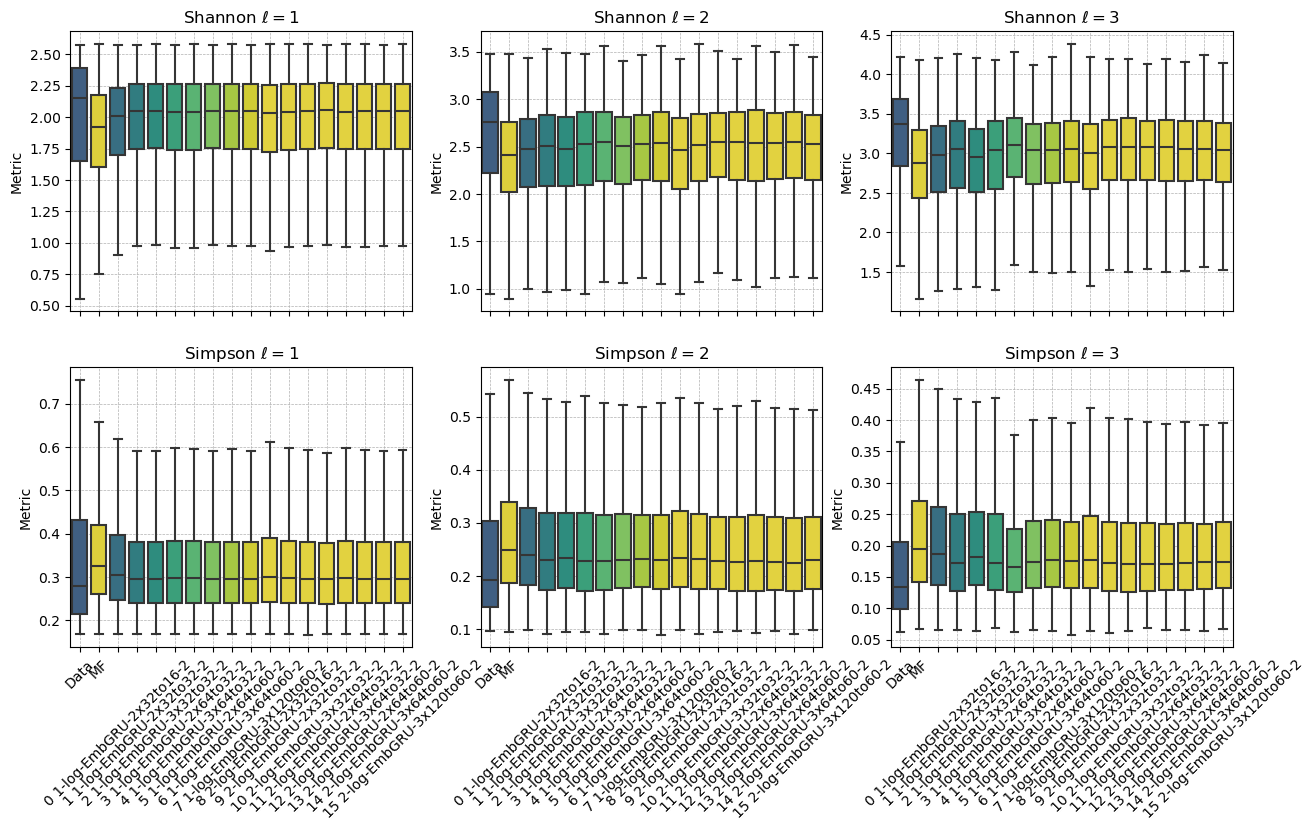

In [44]:
X_list = [X_base] + [X_meanfield] + list(backwards_samples.values())
groups = ['Data'] + ['MF'] + [f'{k} {key}' for k, key in enumerate(backwards.keys())]
colors = [viridis(0.3)] + [viridis(0.99)] + [viridis(0.3 + (k+1)/12) for k in range(len(backwards))]
plot_alpha_diversity(
    X_list,
    tree,
    offset_layer=selected_layers[0],
    groups_name=groups,
    colors=colors,
    style='boxplot',
)

In [45]:
print('Wasserstein Distance')
repeated_metric_compute(
    tree, X_base, X_list[1:], groups[1:], 
    n_split=5, distance=wasserstein_distance, offset_layer=selected_layers[0], order=True
)

Wasserstein Distance


In [46]:
print('Kullback-Leilbler')
repeated_metric_compute(
    tree, X_base, X_list[1:], groups[1:], 
    n_split=5, distance=kl_divergence, offset_layer=selected_layers[0], order=True
)

Kullback-Leilbler


In [47]:
print('Kolmogorov-Smirnov')
repeated_metric_compute(
    tree, X_base, X_list[1:], groups[1:], 
    n_split=5, distance=kolmogorov_smirnov, offset_layer=selected_layers[0], order=True
)

Kolmogorov-Smirnov


In [48]:
print('Total Variation')
repeated_metric_compute(
    tree, X_base, X_list[1:], groups[1:], 
    n_split=5, distance=total_variation, offset_layer=selected_layers[0], order=True
)

Total Variation


##### Selected model training

In [22]:
#plntree, plntree_losses = backwards['1-EmbGRU-3x120to60-2']
plntree, plntree_losses = backwards['2-log-EmbGRU-3x32to32-2']

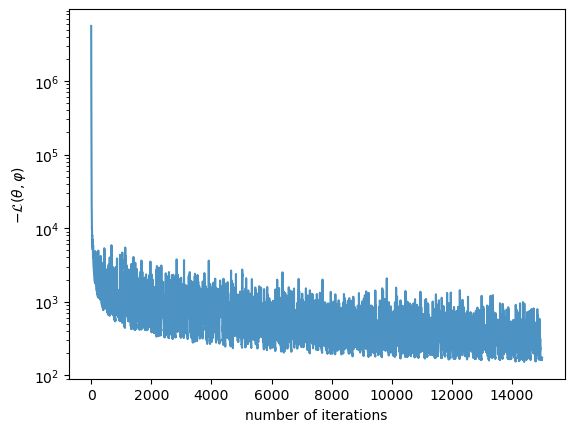

In [23]:
fig, axs = plt.subplots()
axs.plot(plntree_losses, alpha=0.8, color='C0')
axs.set_yscale('log')
axs.set_ylabel('$-\mathcal{L}(\\theta, \\varphi)$')
axs.set_xlabel('number of iterations')
savefig(f"synthetic_dirichlet_ELBO")

In [24]:
n_samples = 50_000

X_plntree, Z_plntree, O_plntree = plntree.sample(n_samples, seed=seed)

### Benchmark

#### Generative benchmark

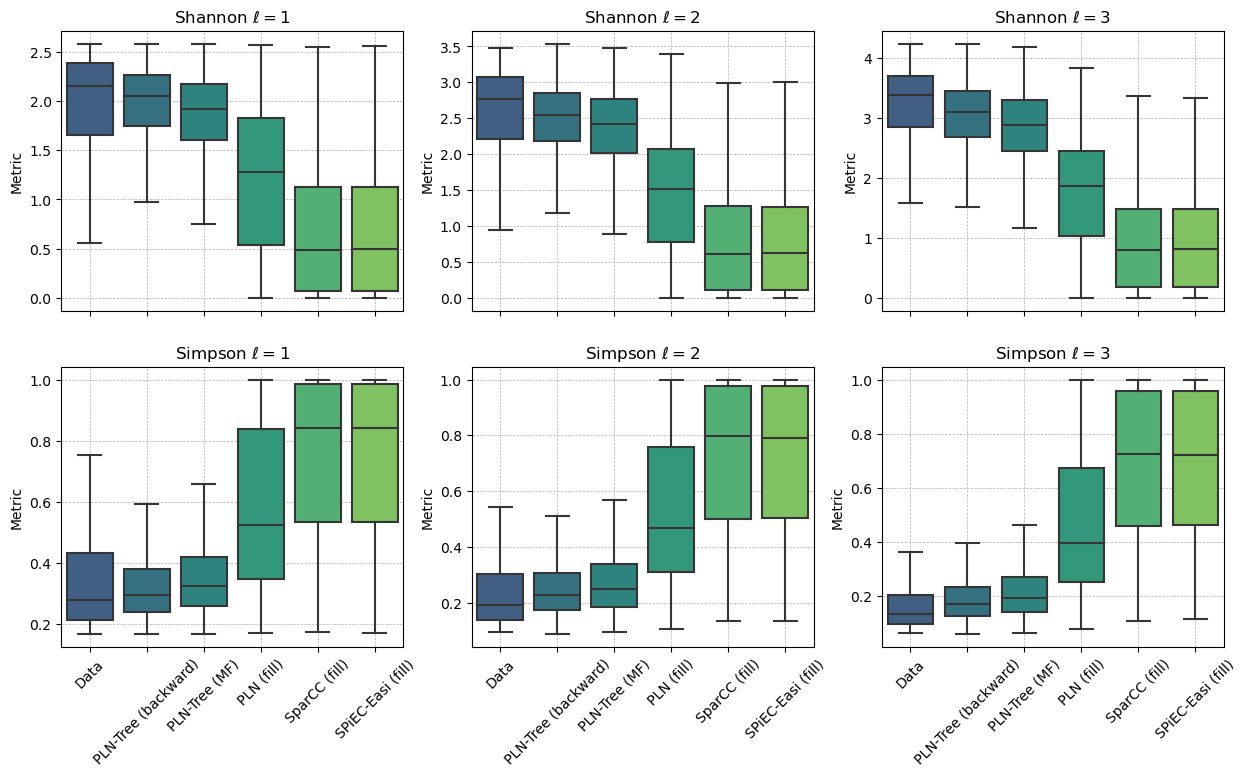

In [25]:
X_list = (X_base, X_plntree, X_meanfield, X_pln_fill, X_sparCC_fill, X_spiec_fill)
groups = ['Data', 'PLN-Tree (backward)', 'PLN-Tree (MF)', 'PLN (fill)', 'SparCC (fill)', 'SPiEC-Easi (fill)']
colors = [viridis(0.3), viridis(0.4), viridis(0.5), viridis(0.6), viridis(0.7), viridis(0.8)]

plot_alpha_diversity(
    X_list,
    tree,
    offset_layer=selected_layers[0],
    groups_name=groups,
    colors=colors,
    style='boxplot',
    saveName=f'synthetic_dirichlet_alpha_diversities'
)

In [53]:
X_comp = [X_plntree, X_meanfield, X_pln_fill, X_sparCC_fill, X_spiec_fill]
comp_names = ['PLN-Tree (backward)', 'PLN-Tree (MF)', 'PLN (fill)', 'SparCC (fill)', 'SPiEC-Easi (fill)']

print('Distribution of samples distance: Wasserstein')
compute_distribution_distance(to_proportion(X_base, K), [to_proportion(X_c, K) for X_c in X_comp], 25, comp_names, K, distance=emd)

Distribution of samples distance: Wasserstein


In [54]:
print('Wasserstein Distance')
repeated_metric_compute(
    tree, X_base, X_comp, comp_names, 
    n_split=25, distance=wasserstein_distance, offset_layer=selected_layers[0]
)

Wasserstein Distance


In [55]:
print('Kolmogorov Smirnov')
repeated_metric_compute(
    tree, X_base, X_comp, comp_names, 
    n_split=25, distance=kolmogorov_smirnov, offset_layer=selected_layers[0]
)

Kolmogorov Smirnov


In [56]:
print('KL divergence')
repeated_metric_compute(
    tree, X_base, X_comp, comp_names, 
    n_split=25, distance=kl_divergence, offset_layer=selected_layers[0]
)

KL divergence


In [57]:
print('Total variation')
repeated_metric_compute(
    tree, X_base, X_comp, comp_names, 
    n_split=25, distance=total_variation, offset_layer=selected_layers[0]
)

Total variation


In [26]:
print("PERMANOVA")
try:
    permanova_mean, permanova_pvalues_layers = load_pkl(prefix, 'pvalues_PERMANOVA')
except:
    permanova_mean, permanova_pvalues_layers = bootstrap_pvalues_braycurtis(
        K, "permanova",
        X_base, X_list[1:-1], groups[1:-1],
        n_samples=100, n_repeat=50, seed=seed, replacement=True
    )
    save_pkl((permanova_mean, permanova_pvalues_layers), prefix, 'pvalues_PERMANOVA')
permanova_mean

PERMANOVA
Loading file ./experiments/saves/synthetic_markovdirichlet_s1_pvalues_PERMANOVA.pkl
Saving in file ./experiments/saves/synthetic_markovdirichlet_s1_pvalues_PERMANOVA.pkl


l = 0          l = 1          l = 2
PLN-Tree (backward)  0.441 (0.269)  0.173 (0.237)  0.085 (0.127)
PLN-Tree (MF)        0.492 (0.273)    0.1 (0.117)  0.055 (0.131)
PLN (fill)           0.001 (0.001)    0.001 (0.0)    0.001 (0.0)
SparCC (fill)          0.001 (0.0)    0.001 (0.0)    0.001 (0.0)

In [36]:
permanova_pvalues_layers[0].apply(lambda x: x < 0.05).mean(0)

PLN-Tree (backward)   0.04000
PLN-Tree (MF)         0.02000
PLN (fill)            1.00000
SparCC (fill)         1.00000
dtype: float64

In [28]:
permanova_pvalues_layers[-1].apply(lambda x: x < 0.05).mean(0)

PLN-Tree (backward)   0.58000
PLN-Tree (MF)         0.84000
PLN (fill)            1.00000
SparCC (fill)         1.00000
dtype: float64

In [27]:
print("PERMDISP")
try:
    permdisp_mean, permdisp_pvalues_layers = load_pkl(prefix, 'pvalues_PERMDISP')
except:
    permdisp_mean, permdisp_pvalues_layers = bootstrap_pvalues_braycurtis(
        K, "permdisp",
        X_base, X_list[1:-1], groups[1:-1],
        n_samples=100, n_repeat=50, seed=seed, replacement=True
    )
    save_pkl((permdisp_mean, permdisp_pvalues_layers), prefix, 'pvalues_PERMDISP')
permanova_mean

PERMANOVA
Loading file ./experiments/saves/synthetic_markovdirichlet_s1_pvalues_PERMDISP.pkl
Saving in file ./experiments/saves/synthetic_markovdirichlet_s1_pvalues_PERMDISP.pkl


l = 0          l = 1          l = 2
PLN-Tree (backward)  0.441 (0.269)  0.173 (0.237)  0.085 (0.127)
PLN-Tree (MF)        0.492 (0.273)    0.1 (0.117)  0.055 (0.131)
PLN (fill)           0.001 (0.001)    0.001 (0.0)    0.001 (0.0)
SparCC (fill)          0.001 (0.0)    0.001 (0.0)    0.001 (0.0)

In [35]:
permdisp_pvalues_layers[0].apply(lambda x: x < 0.05).mean(0)

PLN-Tree (backward)   0.00000
PLN-Tree (MF)         0.68000
PLN (fill)            1.00000
SparCC (fill)         1.00000
dtype: float64

In [29]:
permdisp_pvalues_layers[-1].apply(lambda x: x < 0.05).mean(0)

PLN-Tree (backward)   1.00000
PLN-Tree (MF)         1.00000
PLN (fill)            1.00000
SparCC (fill)         1.00000
dtype: float64

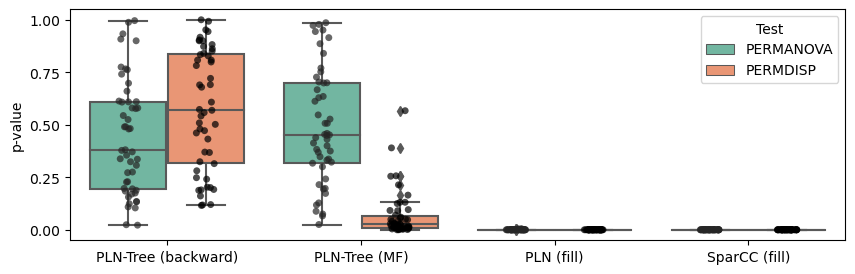

In [37]:
layer = 0
plot_test_pvalues(
    [permanova_pvalues_layers[layer], permdisp_pvalues_layers[layer]], 
    ['PERMANOVA', 'PERMDISP'], logscale=False, figsize=(10, 3)
)
savefig(f'{prefix}_pvalues_distrib_layer{layer+selected_layers[0]}')

#### Encoding benchmark

In [58]:
Z_meanfield_enc, O_meanfield_enc = meanfield.encode(X_test, seed=seed)
X_meanfield_enc = meanfield.decode(Z_meanfield_enc, O_meanfield_enc, seed=seed)

Z_plntree_enc, O_plntree_enc = plntree.encode(X_test, seed=seed)
X_plntree_enc = plntree.decode(Z_plntree_enc, O_plntree_enc, seed=seed)

Correlation against PLN-Tree(backward):
  * layer = 1: 0.9951570626142154 ± 0.061532265619794885
  * layer = 2: 0.9888861575423211 ± 0.06530227770930919
  * layer = 3: 0.9867155758939504 ± 0.07486735832167289
Correlation against PLN-Tree (MF):
  * layer = 1: 0.9673464833196904 ± 0.10272475590874282
  * layer = 2: 0.968112840945511 ± 0.07816808117042932
  * layer = 3: 0.9734312988206141 ± 0.08687217841291892


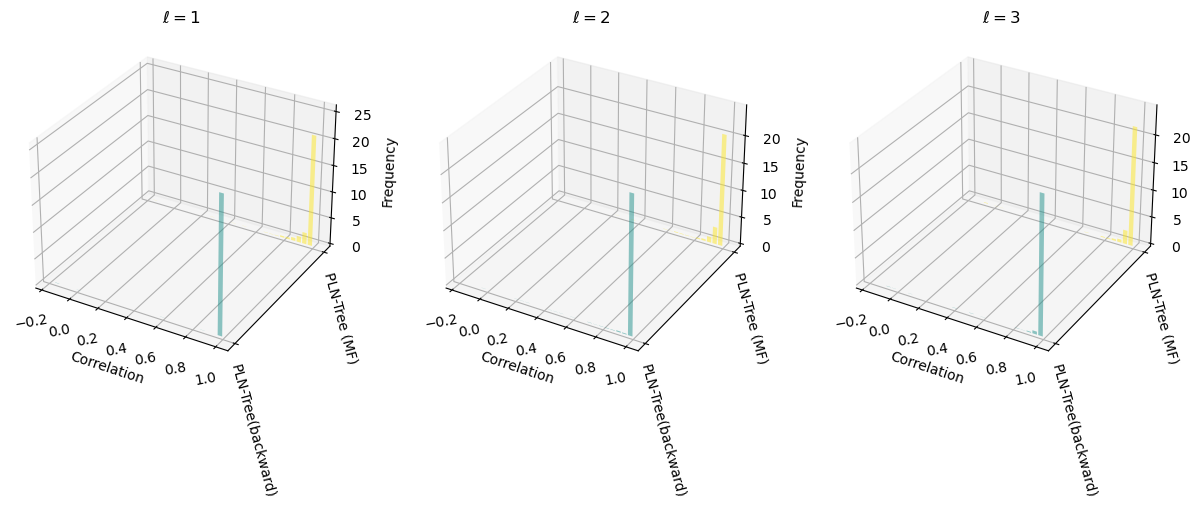

MAE against PLN-Tree(backward): tensor(48.5354) (± nan)
MAE against PLN-Tree (MF): tensor(158.6844) (± nan)


In [59]:
X_comp = (X_plntree_enc, X_meanfield_enc)
groups = ['PLN-Tree(backward)', 'PLN-Tree (MF)']
for group, X_c in zip(groups, X_comp):
    print(f'Correlation against {group}:')
    correlations = correlation(X_test, X_c, meanfield)
    for layer, corr in enumerate(correlations):
        print(f'  * layer = {layer+selected_layers[0]}:', corr[~torch.isnan(corr)].mean().item(), '±', corr[~torch.isnan(corr)].std().item())
correlation_3d_plot(X_test, X_comp, groups, meanfield, saveName='')
for group, X_c in zip(groups, X_comp):
    m = mae(X_test, X_c)
    print(f'MAE against {group}:', m.mean(), f'(± {m.std()})')

In [60]:
for group, X_c in zip(groups, X_comp):
    m = mae_tree(to_proportion(X_test, K), to_proportion(X_c, K), K)
    print(f'MAE against {group}:', m.mean(), f'(± {m.std()})')

MAE against PLN-Tree(backward): tensor(0.0047) (± nan)
MAE against PLN-Tree (MF): tensor(0.0153) (± nan)


<h1 style="color:#333333; font-family:Arial, sans-serif; font-size:28px; font-weight:bold; text-align:center;">Medical data: microbiota exploration</h1>

## Dataset import

In [17]:
seed = 0
prefix = f'metagenomics_diseases_s{seed}'

seed_all(seed)

In [18]:
from plntree.data import metagenomics_loader

raw_abundances, metadata = metagenomics_loader.load_raw_data(directory='./plntree/data/metagenomics')

In [19]:
metadata

Feature                    dataset_name            sampleID subjectID  \
P1                       Candela_Africa                 H10       h10   
P2                       Candela_Africa                 H11       h11   
P3                       Candela_Africa                 H12       h12   
P4                       Candela_Africa                 H13       h13   
P5                       Candela_Africa                 H14       h14   
...                                 ...                 ...       ...   
P3606    Zeller_fecal_colorectal_cancer  CCIS95409808ST-4-0    fr-152   
P3607    Zeller_fecal_colorectal_cancer  CCIS96387239ST-4-0    fr-626   
P3608    Zeller_fecal_colorectal_cancer  CCIS98482370ST-3-0    fr-052   
P3609    Zeller_fecal_colorectal_cancer  CCIS98512455ST-4-0    fr-459   
P3610    Zeller_fecal_colorectal_cancer  CCIS98832363ST-4-0    fr-552   

Feature bodysite        disease age  gender   country sequencing_technology  \
P1         stool              n  40  female  tanzania              Illumina   
P2         stool              n  29  female  tanzania              Illumina   
P3         stool              n   8  female  tanzania              Illumina   
P4         stool              n  34    male  tanzania              Illumina   
P5         stool              n  30    male  tanzania              Illumina   
...          ...            ...  ..     ...       ...                   ...   
P3606      stool              n  63  female    france              Illumina   
P3607      stool  small_adenoma  66    male    france              Illumina   
P3608      stool              n  53  female    france              Illumina   
P3609      stool         cancer  63    male    france              Illumina   
P3610      stool         cancer  55  female    france              Illumina   

Feature  pubmedid  ... cd163 statins insulin oral_anti-diabetic_medication  \
P1       25981789  ...    nd      nd      nd                            nd   
P2       25981789  ...    nd      nd      nd                            nd   
P3       25981789  ...    nd      nd      nd                            nd   
P4       25981789  ...    nd      nd      nd                            nd   
P5       25981789  ...    nd      nd      nd                            nd   
...           ...  ...   ...     ...     ...                           ...   
P3606    25432777  ...    nd      nd      nd                            nd   
P3607    25432777  ...    nd      nd      nd                            nd   
P3608    25432777  ...    nd      nd      nd                            nd   
P3609    25432777  ...    nd      nd      nd                            nd   
P3610    25432777  ...    nd      nd      nd                            nd   

Feature years_in_sweden tnm_stage ajcc_stage localization      fobt  \
P1                   nd        nd         nd           nd        nd   
P2                   nd        nd         nd           nd        nd   
P3                   nd        nd         nd           nd        nd   
P4                   nd        nd         nd           nd        nd   
P5                   nd        nd         nd           nd        nd   
...                 ...       ...        ...          ...       ...   
P3606                nd        na         na           na  negative   
P3607                nd        na         na           lc  negative   
P3608                nd        na         na           na  negative   
P3609                nd    t4n1m1         iv           rc  negative   
P3610                nd    t3n1m0        iii           lc  positive   

Feature wif-1_gene_methylation_test  
P1                               nd  
P2                               nd  
P3                               nd  
P4                               nd  
P5                               nd  
...                             ...  
P3606                      negative  
P3607                      negative  
P3608                      negative  
P360

In [20]:
metadata['disease'].value_counts()

n                             2054
nd                             475
t2d                            223
obesity                        164
ibd_ulcerative_colitis         148
cirrhosis                      118
leaness                         89
stec2-positive                  52
impaired_glucose_tolerance      49
cancer                          48
n_relative                      47
y                               36
small_adenoma                   26
ibd_crohn_disease               25
 -                              20
large_adenoma                   13
overweight                      10
-                                7
obese                            5
underweight                      1
Name: disease, dtype: int64

In [21]:
diseases = ['t2d', 'ibd_ulcerative_colitis', 'cirrhosis', 'ibd_crohn_disease', 'cancer', 'obesity', 'leaness']
raw_abundances, metadata = metagenomics_loader.filter_diseases(raw_abundances, metadata, diseases)

In [22]:
# Shuffling the dataset to prevent selection biases
indexes = metadata.index.tolist()
indexes = pd.Series(indexes).sample(frac=1, random_state=seed).tolist()
metadata = metadata.loc[indexes]

In [23]:
undersampling_rate = 0.8
max_sampling = 200
train_index = []
test_index = []
for disease in diseases:
    ind = metadata[metadata['disease'] == disease].index
    min_index = min(max_sampling, int(np.floor(len(ind) * undersampling_rate)))
    train_index += list(ind[:min_index])
    test_index +=list(ind[min_index:])
    print(f'{disease}', len(ind[:min_index]), len(ind[min_index:]), len(ind[:min_index])+len(ind[min_index:]))
print(len(train_index), len(test_index), len(train_index)+len(test_index))
train_raw_abundances = raw_abundances[['Feature']+train_index]
train_metadata = metadata.loc[train_index]
test_raw_abundances = raw_abundances[['Feature']+test_index]
test_metadata = metadata.loc[test_index]

t2d 178 45 223
ibd_ulcerative_colitis 118 30 148
cirrhosis 94 24 118
ibd_crohn_disease 20 5 25
cancer 38 10 48
obesity 131 33 164
leaness 71 18 89
650 165 815


In [24]:
train_raw_abundances

Feature P3178 P3186 P3428  \
211                                          k__Archaea     0     0     0   
212                         k__Archaea|p__Euryarchaeota     0     0     0   
213      k__Archaea|p__Euryarchaeota|c__Methanobacteria     0     0     0   
214   k__Archaea|p__Euryarchaeota|c__Methanobacteria...     0     0     0   
215   k__Archaea|p__Euryarchaeota|c__Methanobacteria...     0     0     0   
...                                                 ...   ...   ...   ...   
3508  k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...     0     0     0   
3509  k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...     0     0     0   
3510  k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...     0     0     0   
3511  k__Bacteria|p__Firmicutes|c__Negativicutes|o__...     0     0     0   
3512  k__Bacteria|p__Firmicutes|c__Negativicutes|o__...     0     0     0   

     P3139    P3414 P3243    P3396 P3140   P3265  ... P278     P297 P66  \
211      0  1.02974     0  3.12524     0       0  ...    0  0.08795   0   
212      0  1.02974     0  3.12524     0       0  ...    0  0.08795   0   
213      0  1.02974     0  3.12524     0       0  ...    0  0.08795   0   
214      0  1.02974     0  3.12524     0       0  ...    0  0.08795   0   
215      0  1.02974     0  3.12524     0       0  ...    0  0.08795   0   
...    ...      ...   ...      ...   ...     ...  ...  ...      ...  ..   
3508     0        0     0        0     0 0.00000  ...    0        0   0   
3509     0        0     0        0     0 0.00000  ...    0        0   0   
3510     0        0     0        0     0 0.00000  ...    0        0   0   
3511     0        0     0        0     0 0.00000  ...    0        0   0   
3512     0        0     0        0     0 0.00000  ...    0        0   0   

         P277     P267 P290 P67     P212 P199     P311  
211   0.00742  0.27642    0   0  0.48402    0  0.42025  
212   0.00742  0.27642    0   0  0.48402    0  0.42025  
213   0.00742  0.27642    0   0  0.48402    0  0.42025  
214   0.00742  0.27642    0   0  0.48402    0  0.42025  
215   0.00742  0.27642    0   0  0.48402    0  0.42025  
...       ...      ...  ...  ..      ...  ...      ...  
3508        0        0    0   0        0    0        0  
3509        0        0    0   0        0    0        0  
3510        0        0    0   0        0    0        0  
3511        0        0    0   0        0    0        0  
3512        0        0    0   0        0    0        0  

[3302 rows x 651 columns]

In [25]:
test_raw_abundances

Feature P3144    P3450 P3274  \
211                                          k__Archaea     0  0.06899     0   
212                         k__Archaea|p__Euryarchaeota     0  0.06899     0   
213      k__Archaea|p__Euryarchaeota|c__Methanobacteria     0  0.06899     0   
214   k__Archaea|p__Euryarchaeota|c__Methanobacteria...     0  0.06899     0   
215   k__Archaea|p__Euryarchaeota|c__Methanobacteria...     0  0.06899     0   
...                                                 ...   ...      ...   ...   
3508  k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...     0        0     0   
3509  k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...     0        0     0   
3510  k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...     0        0     0   
3511  k__Bacteria|p__Firmicutes|c__Negativicutes|o__...     0        0     0   
3512  k__Bacteria|p__Firmicutes|c__Negativicutes|o__...     0        0     0   

     P3454   P3081 P3149 P3093    P3262 P3271  ...     P257 P263     P135  \
211      0       0     0     0  0.00478     0  ...  0.58825    0  0.01347   
212      0       0     0     0  0.00478     0  ...  0.58825    0  0.01347   
213      0       0     0     0        0     0  ...  0.58825    0  0.01347   
214      0       0     0     0        0     0  ...  0.58825    0  0.01347   
215      0       0     0     0        0     0  ...  0.58825    0  0.01347   
...    ...     ...   ...   ...      ...   ...  ...      ...  ...      ...   
3508     0 0.00000     0     0        0     0  ...        0    0        0   
3509     0 0.00000     0     0        0     0  ...        0    0        0   
3510     0 0.00000     0     0        0     0  ...        0    0        0   
3511     0 0.00000     0     0        0     0  ...        0    0        0   
3512     0 0.00000     0     0        0     0  ...        0    0        0   

         P105 P87 P71     P243 P237     P121     P252  
211   0.18194   0   0  0.00133    0  0.03771  0.01311  
212   0.18194   0   0  0.00133    0  0.03771  0.01311  
213   0.18194   0   0  0.00133    0  0.03771  0.01311  
214   0.18194   0   0  0.00133    0  0.03771  0.01311  
215   0.18194   0   0  0.00133    0  0.03771  0.01311  
...       ...  ..  ..      ...  ...      ...      ...  
3508        0   0   0        0    0        0        0  
3509        0   0   0        0    0        0        0  
3510        0   0   0        0    0        0        0  
3511        0   0   0        0    0        0        0  
3512        0   0   0        0    0        0        0  

[3302 rows x 166 columns]

In [26]:
# Select the taxonomic precision
precision = 'f'
# Filter out some taxa
filtered_taxa = ['k__Archaea', 'k__Eukaryota']
# Select the rarefaction offset
rarefaction_offset = 12
# Select the prevalence threshold (-1 for none)
prevalence = 1 / np.exp(rarefaction_offset)

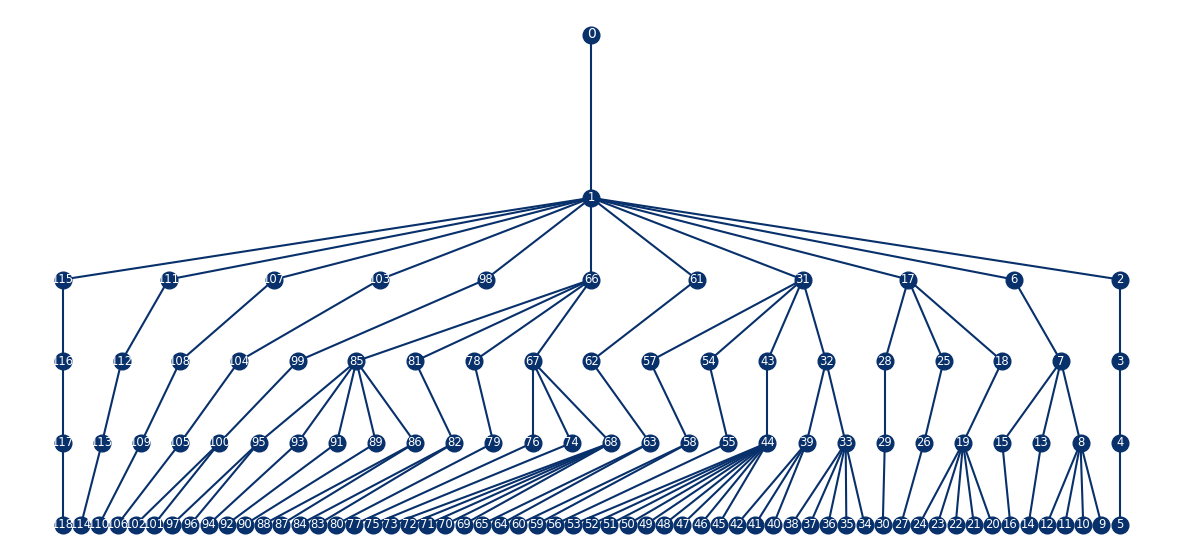

In [27]:
abundances = metagenomics_loader.raw_abundance_filter(train_raw_abundances, precision)
for taxon in filtered_taxa:
    abundances = metagenomics_loader.exclude_taxon(abundances, taxon)
if prevalence > 0:
    abundances = metagenomics_loader.prevalence_filter(abundances, threshold=prevalence)
abundances = metagenomics_loader.rarefy(abundances, rarefaction_offset, seed=seed)

taxonomy = metagenomics_loader.get_taxonomy(abundances)
taxonomy.plot(legend=False, title='')
savefig('taxonomy_metagenomics_dataset_filtered')

In [28]:
taxonomy.nodes[0].name

'root'

In [29]:
abundances.head()

P3178  P3186  P3428  \
Feature                                                                   
k__Bacteria|p__Acidobacteria|c__Acidobacteriia|...      0      0      0   
k__Bacteria|p__Actinobacteria|c__Actinobacteria...      0      3      1   
k__Bacteria|p__Actinobacteria|c__Actinobacteria...      0      5      0   
k__Bacteria|p__Actinobacteria|c__Actinobacteria...    969  68174    939   
k__Bacteria|p__Actinobacteria|c__Actinobacteria...    280    386   2092   

                                                    P3139  P3414  P3243  \
Feature                                                                   
k__Bacteria|p__Acidobacteria|c__Acidobacteriia|...      0      0      0   
k__Bacteria|p__Actinobacteria|c__Actinobacteria...      0     15      0   
k__Bacteria|p__Actinobacteria|c__Actinobacteria...      0      0      0   
k__Bacteria|p__Actinobacteria|c__Actinobacteria...      2      0      0   
k__Bacteria|p__Actinobacteria|c__Actinobacteria...    301    341    901   

                                                    P3396  P3140  P3265  \
Feature                                                                   
k__Bacteria|p__Acidobacteria|c__Acidobacteriia|...      0      0      0   
k__Bacteria|p__Actinobacteria|c__Actinobacteria...      0      0      0   
k__Bacteria|p__Actinobacteria|c__Actinobacteria...      0      0      0   
k__Bacteria|p__Actinobacteria|c__Actinobacteria...    874    388  27360   
k__Bacteria|p__Actinobacteria|c__Actinobacteria...    413    122      0   

                                                    P3092  ...  P278  P297  \
Feature                                                    ...               
k__Bacteria|p__Acidobacteria|c__Acidobacteriia|...      0  ...     0     0   
k__Bacteria|p__Actinobacteria|c__Actinobacteria...      0  ...     5     0   
k__Bacteria|p__Actinobacteria|c__Actinobacteria...      2  ...     2     0   
k__Bacteria|p__Actinobacteria|c__Actinobacteria...     25  ...    17  6178   
k__Bacteria|p__Actinobacteria|c__Actinobacteria...   1304  ...  1244   732   

                                                     P66  P277  P267   P290  \
Feature                                                                       
k__Bacteria|p__Acidobacteria|c__Acidobacteriia|...    19     6     0      0   
k__Bacteria|p__Actinobacteria|c__Actinobacteria...     0     0     0      0   
k__Bacteria|p__Actinobacteria|c__Actinobacteria...     4     0     0      0   
k__Bacteria|p__Actinobacteria|c__Actinobacteria...  1208  3493   661  13831   
k__Bacteria|p__Actinobacteria|c__Actinobacteria...   178   440   509   2396   

                                                     P67  P212  P199  P311  
Feature                                                                     
k__Bacteria|p__Acidobacteria|c__Acidobacteriia|...    11     0     3     0  
k__Bacteria|p__Actinobacteria|c__Actinobacteria...     0     0     0     0  
k__Bacteria|p__Actinobacteria|c__Actinobacteria...     0     0     0     0  
k__Bacteria|p__Actinobacteria|c__Actinobacteria...  1114  3748   217  8786  
k__Bacteria|p__Actinobacteria|c__Actinobacteria...   175   417   327  1620  

[5 rows x 650 columns]

In [30]:
test_raw_abundances = test_raw_abundances[test_raw_abundances['Feature'].isin(abundances.index)]
test_abundances = metagenomics_loader.raw_abundance_filter(test_raw_abundances, precision)
test_abundances = metagenomics_loader.rarefy(test_abundances, rarefaction_offset, seed=seed)

In [31]:
from torch.utils.data import DataLoader, TensorDataset
# Select the offset layer
selected_layers = [2, -1]
K = list(taxonomy.getLayersWidth().values())[selected_layers[0]:]
X_base, patient_ids = metagenomics_loader.hierarchical_dataset(abundances, taxonomy, offset_layer=selected_layers[0])

# Select the batch size
batch_size = len(X_base)
seed_all(seed)
dataset = TensorDataset(X_base.to(dtype=torch.float64), X_base.to(dtype=torch.float64))
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [32]:
X_metagenomics = X_base

In [17]:
X_test, test_patient_ids = metagenomics_loader.hierarchical_dataset(test_abundances, taxonomy, offset_layer=selected_layers[0])
X_test = X_test.to(dtype=torch.float64)

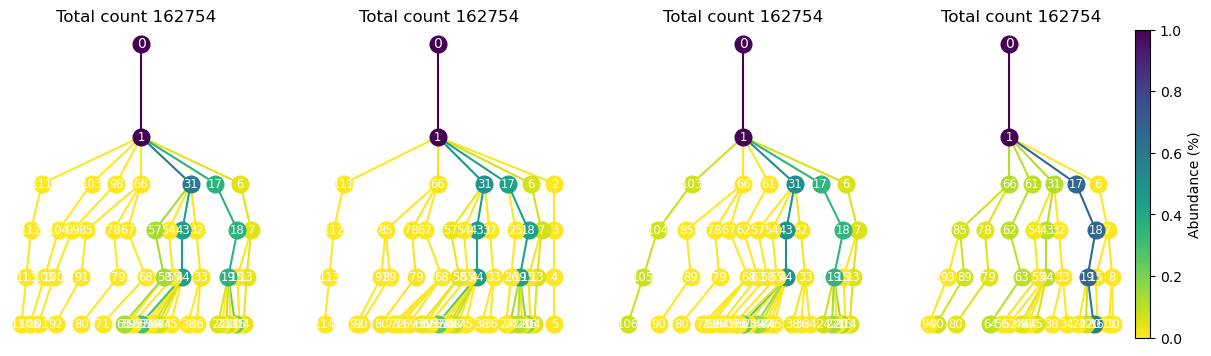

In [18]:
vizualize_samples(dataloader, taxonomy, autofill=True, seed=seed)
savefig('metagenomics_samples')

## Comparison of datasets

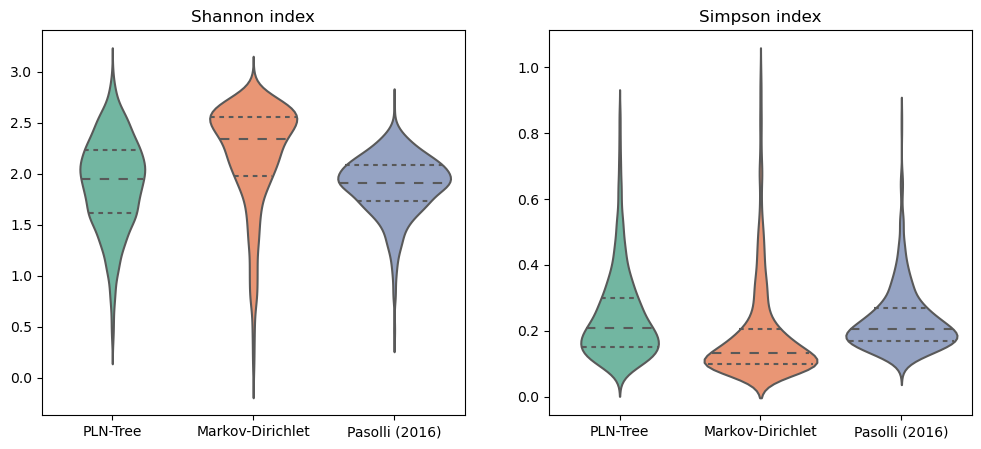

In [74]:
def shannon_index(counts):
    proportions = counts / counts.sum(axis=-1, keepdims=True)
    log = np.log
    if type(counts) == torch.Tensor:
        log = torch.log
        proportions[proportions.isnan()] = 0.
    else:
        proportions[np.isnan(proportions)] = 0.
    return -(proportions * log(proportions + 1e-36)).sum(axis=-1)


def simpson_index(counts):
    proportions = counts / counts.sum(axis=-1, keepdims=True)
    return (proportions ** 2).sum(axis=-1)

def metric(X, metric_index):
    if type(X) == list:
        values = []
        for X_ in X:
            values += [metric(X_, metric_index)]
        return values
    return metric_index(X).numpy()

def plot_distributions(data, plot_type="boxplot", labels=None, title="Distribution Comparison", ylabel='',
                       figsize=(4, 4), rotation=0, axs=None):
    if labels is None:
        labels = [f"Vector {i + 1}" for i in range(len(data))]

    # Create a DataFrame suitable for seaborn by concatenating data with labels
    df = pd.DataFrame({
        "Vector": [labels[i] for i in range(len(data)) for _ in range(len(data[i]))],
        "Value": [value for sublist in data for value in sublist]
    })

    # Create the plot
    if plot_type == "boxplot":
        sns.boxplot(data=df, x="Vector", y="Value", ax=axs, showfliers=False, palette='Set2')
    elif plot_type == "violin":
        sns.violinplot(data=df, x="Vector", y="Value", inner="quart", ax=axs, palette='Set2')
    else:
        raise ValueError("Invalid plot_type. Choose either 'boxplot' or 'violin'.")

    # Add titles and labels
    axs.set_title(title)
    axs.set_xlabel("")
    axs.set_ylabel(ylabel)

X_list = {
    'PLN-Tree': X_synthetic_plntree[:, -1],
    'Markov-Dirichlet': X_synthetic_markovdirichlet[:, -1],
    'Pasolli (2016)': X_metagenomics[:, -1]
}

shannon_metrics = [
    shannon_index(X).numpy() for X in X_list.values()
]
simpson_metrics = [
    metric(X, simpson_index) for X in X_list.values()
]
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
plot_distributions(shannon_metrics, labels=list(X_list.keys()), title="Shannon index", axs=axs[0], plot_type='violin')
plot_distributions(simpson_metrics, labels=list(X_list.keys()), title="Simpson index", axs=axs[1], plot_type='violin')
savefig('comparison_alpha_diversity_datasets')

## Models training

### Benchmark models

#### PLN

Setting the offsets as the log of the sum of endog
Fitting a Pln model with full covariance model.
Initialization ...
Initialization finished
Tolerance 1e-08 reached in 898 iterations
Setting the offsets as the log of the sum of endog
Fitting a Pln model with full covariance model.
Initialization ...
Initialization finished
Tolerance 1e-08 reached in 904 iterations
Setting the offsets as the log of the sum of endog
Fitting a Pln model with full covariance model.
Initialization ...
Initialization finished
Tolerance 1e-08 reached in 901 iterations
Setting the offsets as the log of the sum of endog
Fitting a Pln model with full covariance model.
Initialization ...
Initialization finished
Tolerance 1e-08 reached in 860 iterations
Likelihood: -36324.04648125172


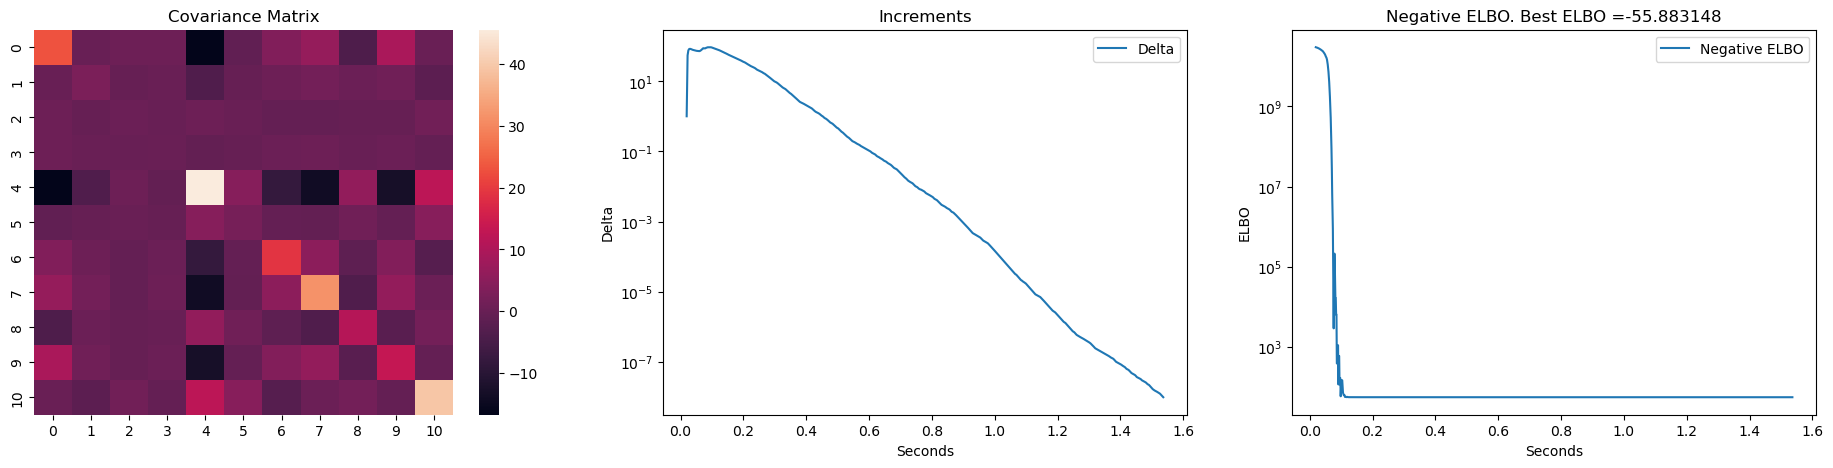

Likelihood: -64583.106482625015


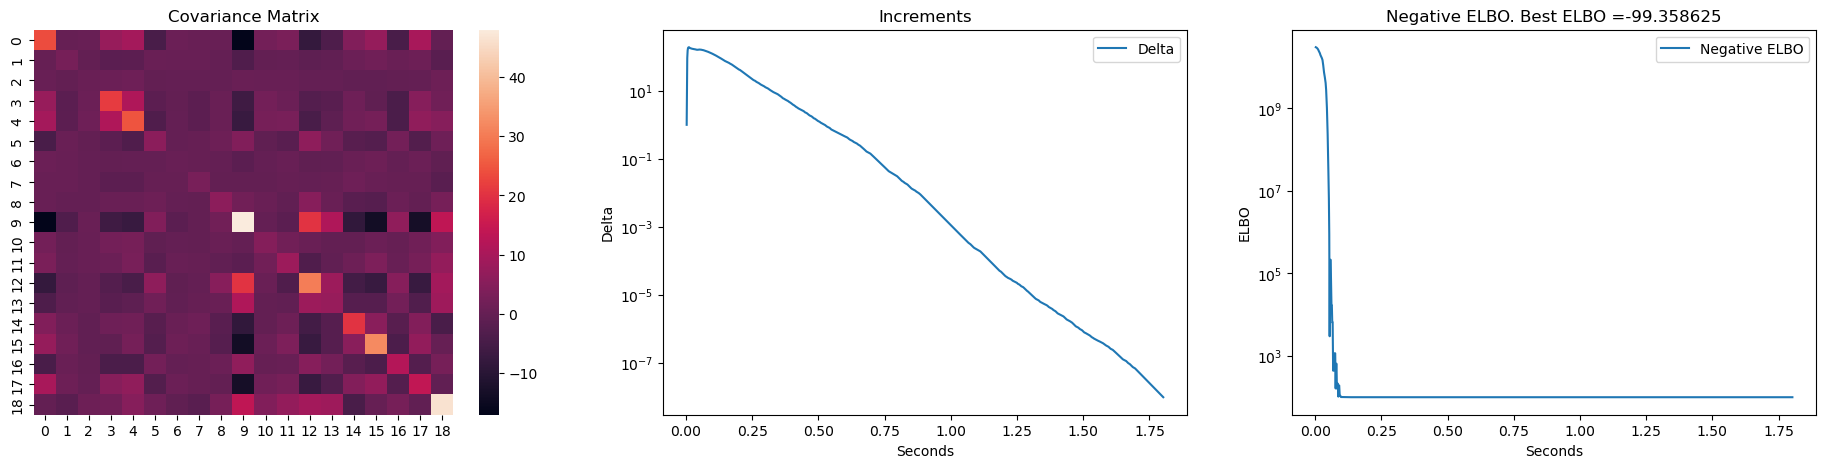

Likelihood: -76536.66733026505


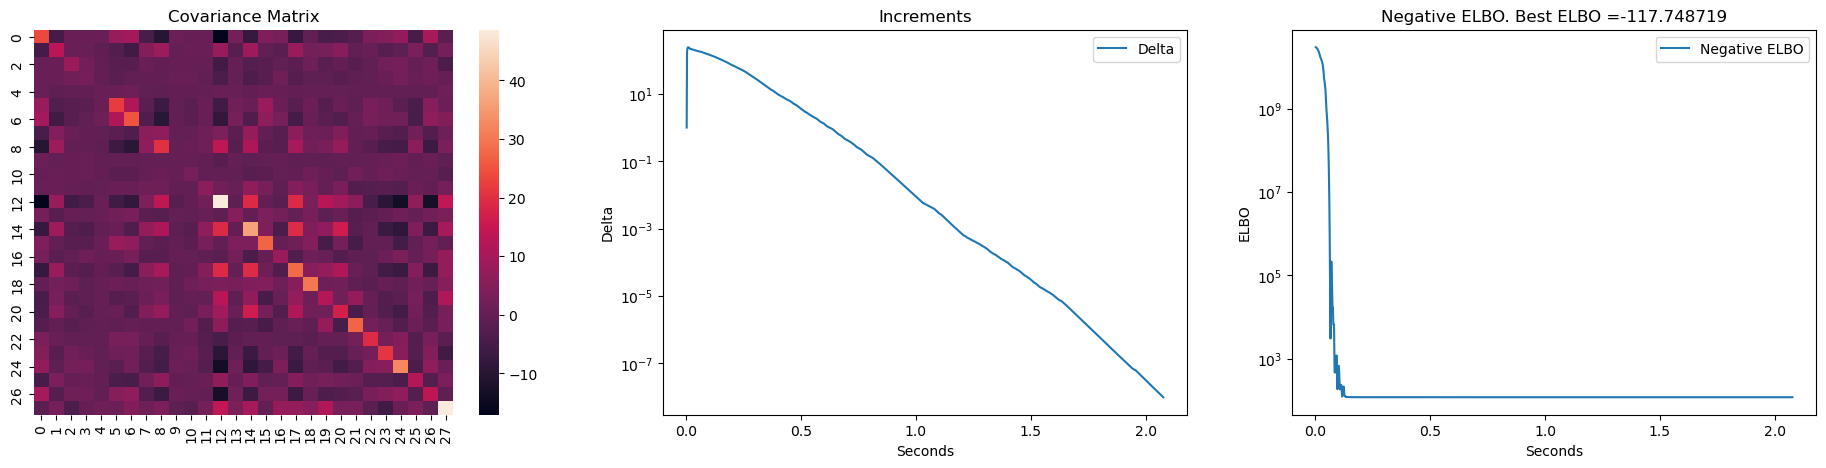

Likelihood: -145353.40320777893


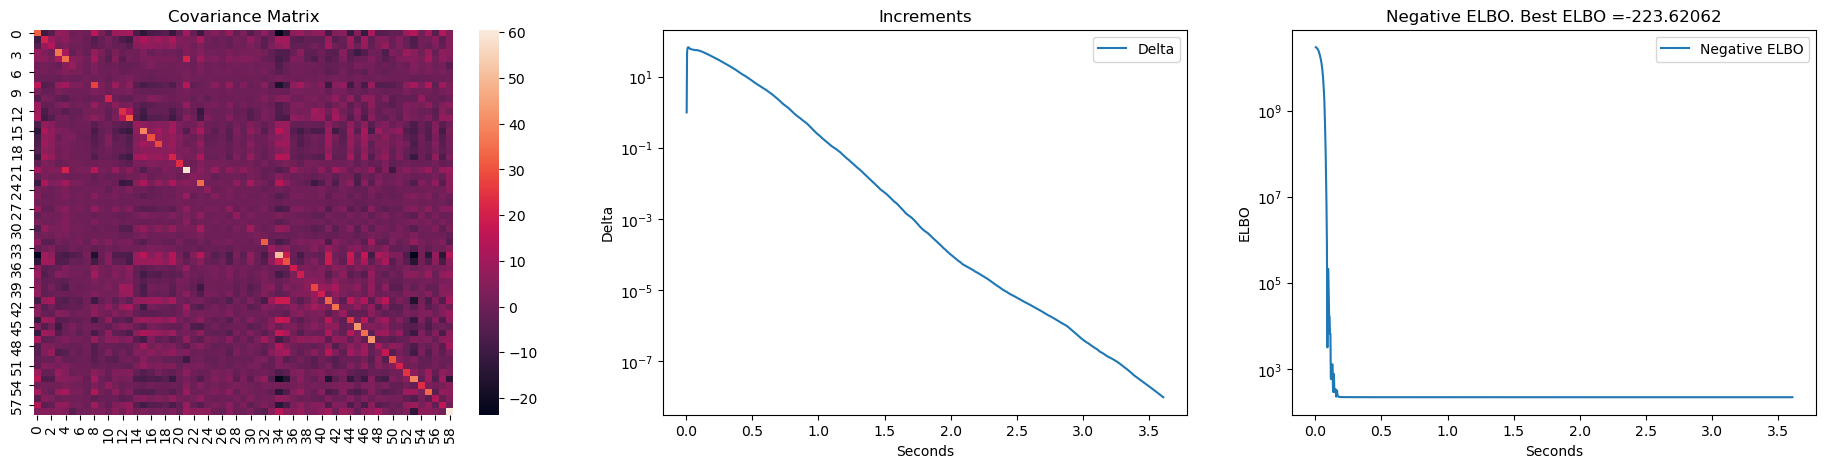

In [19]:
pln_layers = learn_pln(X_base, K, seed=seed)

In [20]:
n_samples = 20_000
X_pln, Z_pln, X_pln_fill, X_pln_enc, Z_pln_enc, X_pln_enc_fill = generate_pln_data(pln_layers, n_samples, K, selected_layers, X_base, taxonomy, seed=seed)

#### SparCC

In [21]:
# SparCC
sparCC_layers = learn_per_layer_sparCC(to_proportion(X_base, K), K)
X_sparCC, X_sparCC_fill = sample_model_layers(sparCC_layers, n_samples, K, selected_layers, taxonomy, seed=seed)

#### SPiEC-Easi

In [22]:
# SPiEC-Easi
spiec_layers = learn_per_layer_spiec_easi(
    to_proportion(X_base, K), K, {'alpha':0.07, 'max_iter':10_000, 'mode':'cd'}, seed=seed
)
X_spiec, X_spiec_fill = sample_model_layers(spiec_layers, n_samples, K, selected_layers, taxonomy, seed=seed)

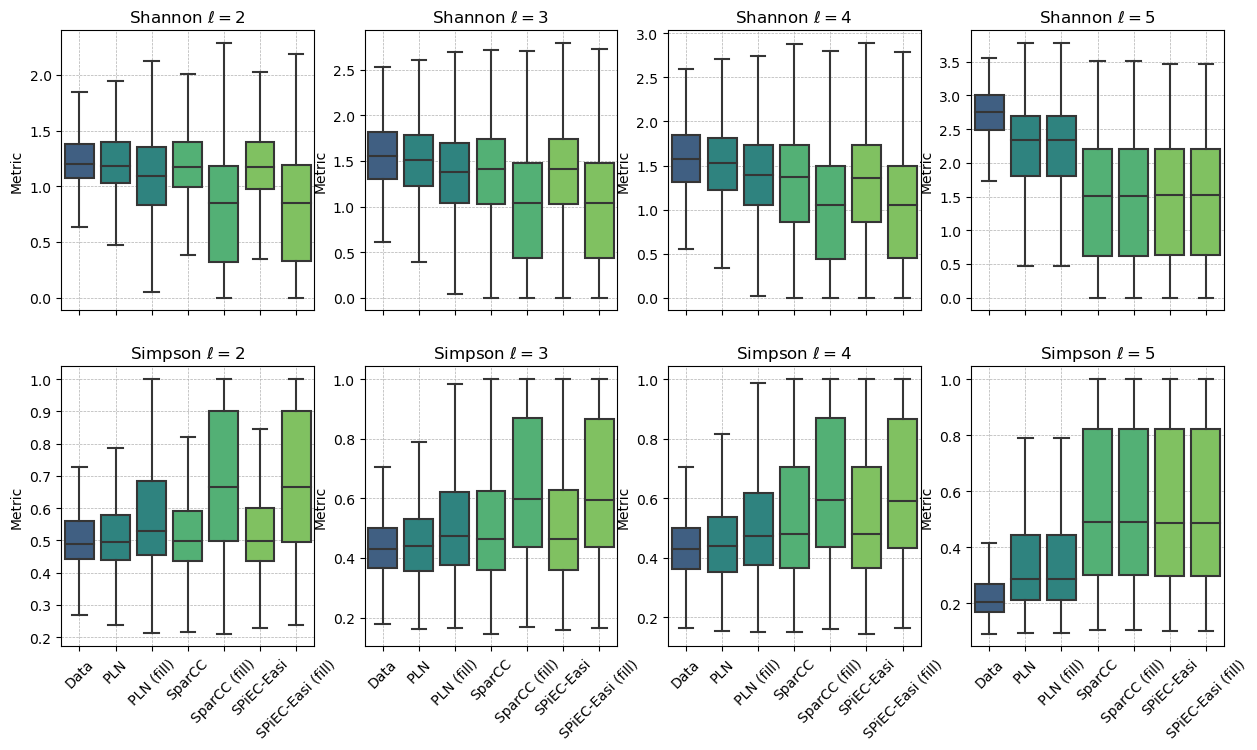

In [23]:
X_list = (X_base, X_pln, X_pln_fill, X_sparCC, X_sparCC_fill, X_spiec, X_spiec_fill)
groups = ['Data', 'PLN', 'PLN (fill)', 'SparCC', 'SparCC (fill)', 'SPiEC-Easi', 'SPiEC-Easi (fill)']
colors = [viridis(0.3), viridis(0.5), viridis(0.5), viridis(0.7), viridis(0.7), viridis(0.8), viridis(0.8)]

plot_alpha_diversity(
    X_list,
    taxonomy,
    offset_layer=selected_layers[0],
    groups_name=groups,
    colors=colors,
    style='boxplot',
)

### PLN-Tree (Mean Field)

#### Model selection

In [24]:
def get_plntree_params_and_suffix(n_latent_layers, variational_approx, variational_approx_params):
    params = {
        'tree':taxonomy,
        'selected_layers':selected_layers,
        'diagonal_model':False,
        'variational_approx':variational_approx,
        'positive_fun':'softplus',
        'offset_method':'constant',
        'variational_approx_params':variational_approx_params,
        'n_latent_layers':n_latent_layers,
        'diag_smoothing_factor':1e-4
    }
    placeholder = variational_approx_params
    if variational_approx == 'mean_field':
        placeholder = variational_approx_params['n_variational_layers']
    suffix = f'latentlayers-{n_latent_layers}_varlayers-{placeholder}'
    return params, suffix

In [25]:
def learn_plntree_mean_field(params):
    estimator = PLNTree(**params, seed=seed)

    optimizer = optim.Adam(
        estimator.parameters(),
        lr=1e-3,
    )
    n_epoch = 25_000
    return estimator.fit(optimizer, dataloader, n_epoch=n_epoch, verbose=100, max_grad_norm=10.)

In [26]:
n_variational_layers_list = [1, 2, 3]
n_latent_layers_list = [1, 2, 3]
meanfields = {}
preprocessing = 'proportion'

for n_latent_layers in n_latent_layers_list:
    for n_variational_layers in n_variational_layers_list:
        print('Latents size', n_latent_layers)
        print('Variational size', n_variational_layers)
        variational_approx_params = {
            'n_variational_layers':n_variational_layers,
            'preprocessing': [preprocessing]
        }
        params, suffix = get_plntree_params_and_suffix(n_latent_layers, 'mean_field', variational_approx_params)
        try:
            meanfield, meanfield_losses = load_pkl(prefix, f'mean_field_{preprocessing}_{suffix}')
        except:
            meanfield, meanfield_losses = learn_plntree_mean_field(params)
            save_pkl((meanfield, meanfield_losses), prefix, f'mean_field_{preprocessing}_{suffix}')
        meanfields[f'{n_latent_layers}:{n_variational_layers}'] = (meanfield, meanfield_losses)

Latents size 1
Variational size 1
Loading file ./experiments/saves/metagenomics_diseases_s0_mean_field_proportion_latentlayers-1_varlayers-1.pkl
Latents size 1
Variational size 2
Loading file ./experiments/saves/metagenomics_diseases_s0_mean_field_proportion_latentlayers-1_varlayers-2.pkl
Latents size 1
Variational size 3
Loading file ./experiments/saves/metagenomics_diseases_s0_mean_field_proportion_latentlayers-1_varlayers-3.pkl
Latents size 2
Variational size 1
Loading file ./experiments/saves/metagenomics_diseases_s0_mean_field_proportion_latentlayers-2_varlayers-1.pkl
Latents size 2
Variational size 2
Loading file ./experiments/saves/metagenomics_diseases_s0_mean_field_proportion_latentlayers-2_varlayers-2.pkl
Latents size 2
Variational size 3
Loading file ./experiments/saves/metagenomics_diseases_s0_mean_field_proportion_latentlayers-2_varlayers-3.pkl
Latents size 3
Variational size 1
Loading file ./experiments/saves/metagenomics_diseases_s0_mean_field_proportion_latentlayers-3_v

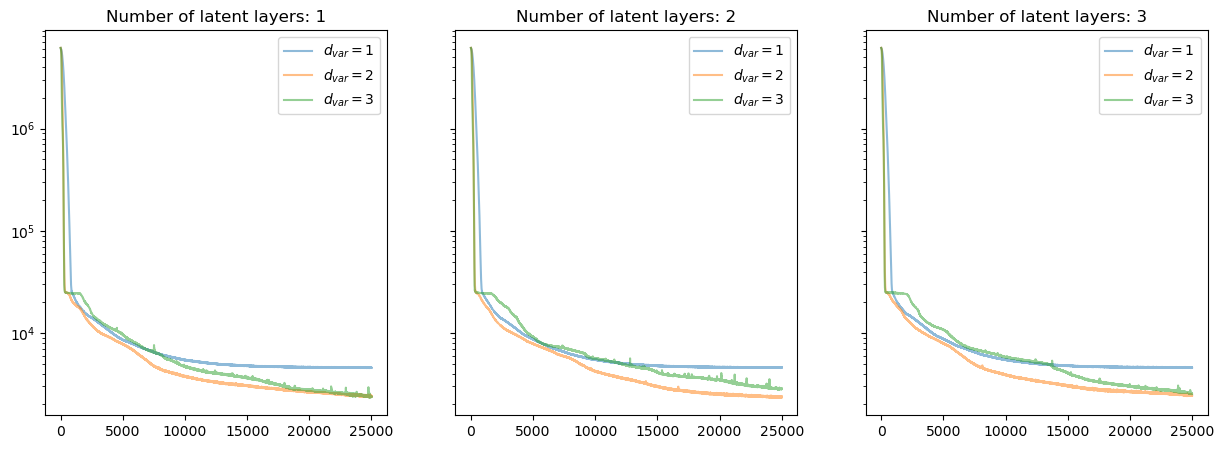

In [27]:
fig, axs = plt.subplots(1, len(n_latent_layers_list), figsize=(15, 5), sharey=True)
for key, (meanfield, meanfield_losses) in meanfields.items():
    n_latent_layers, n_variational_layers = key.split(':')
    i = int(n_latent_layers) - 1
    axs[i].set_title(f'Number of latent layers: {n_latent_layers}')
    axs[i].plot(meanfield_losses, label='$d_{var}=$' + f'{n_variational_layers}', alpha=0.5)
    axs[i].set_yscale('log')
    axs[i].legend()

In [28]:
n_samples = 20_000

meanfield_samples = {}
for key, (meanfield, meanfield_losses) in meanfields.items():
    X_meanfield, Z_meanfield, O_meanfield = meanfield.sample(n_samples, seed=seed)
    meanfield_samples[key] = X_meanfield

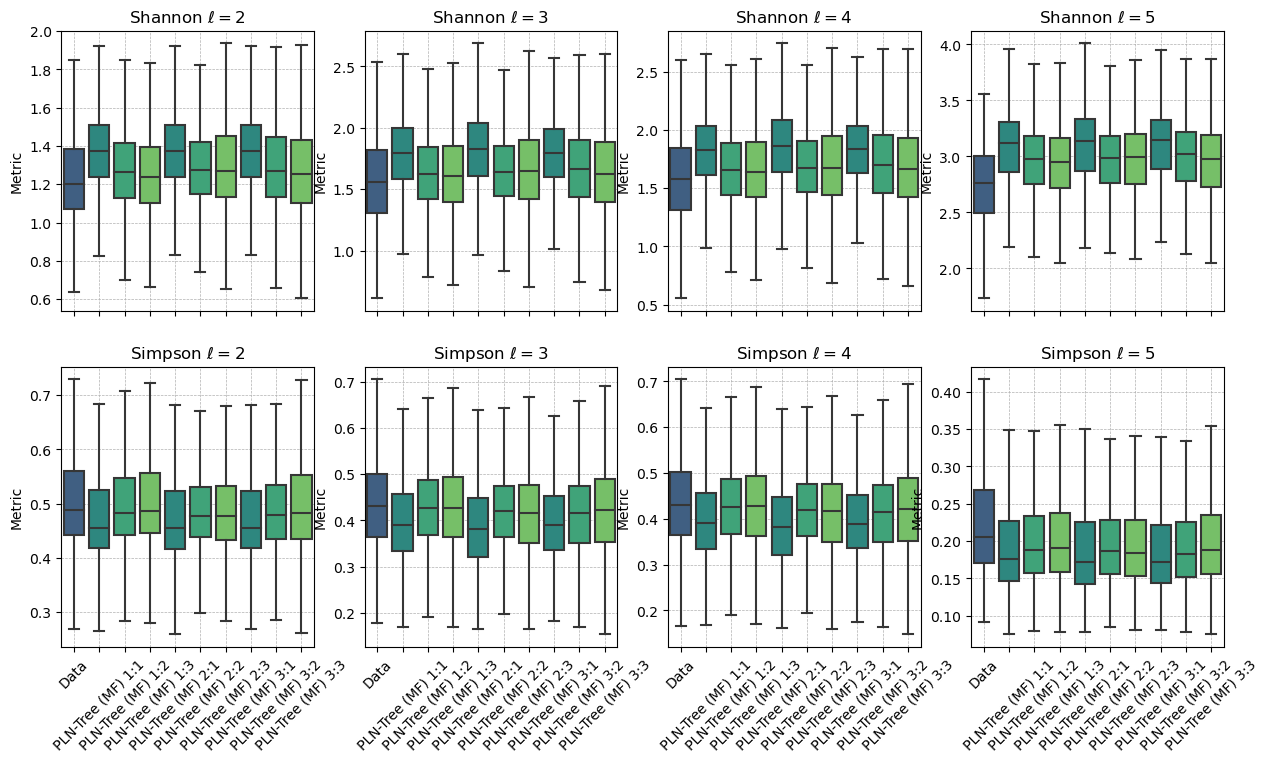

In [29]:
X_list = [X_base] + [X_meanfield for key, X_meanfield in meanfield_samples.items()]
groups = ['Data'] + ['PLN-Tree (MF) ' + key for key, X_meanfield in meanfield_samples.items()]
mf_colors = [viridis(0.4 + int(key.split(':')[1])/8) for key in meanfield_samples.keys()]
colors = [viridis(0.3)] + mf_colors

plot_alpha_diversity(
    X_list,
    taxonomy,
    offset_layer=selected_layers[0],
    groups_name=groups,
    colors=colors,
    style='boxplot',
)

In [30]:
print('Wasserstein Distance')
repeated_metric_compute(
    taxonomy, X_base,  X_list[1:], groups[1:], 
    n_split=10, distance=wasserstein_distance, offset_layer=selected_layers[0], order=True
)

Wasserstein Distance


In [31]:
print('KL divergence')
repeated_metric_compute(
    taxonomy, X_base,  X_list[1:], groups[1:], 
    n_split=10, distance=kl_divergence, offset_layer=selected_layers[0], order=True
)

KL divergence


In [32]:
print('Kolmogorov Smirnov')
repeated_metric_compute(
    taxonomy, X_base,  X_list[1:], groups[1:], 
    n_split=10, distance=kolmogorov_smirnov, offset_layer=selected_layers[0], order=True
)

Kolmogorov Smirnov


In [33]:
print('Total variation')
repeated_metric_compute(
    taxonomy, X_base,  X_list[1:], groups[1:], 
    n_split=10, distance=total_variation, offset_layer=selected_layers[0], order=True
)

Total variation


#### Selected model training

In [28]:
meanfield, meanfield_losses = meanfields['1:3']

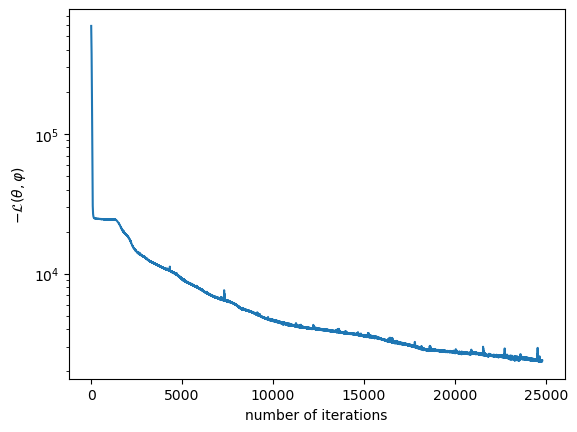

In [29]:
fig, axs = plt.subplots()
axs.plot(meanfield_losses[200:])
axs.set_yscale('log')
axs.set_ylabel('$-\mathcal{L}(\\theta, \\varphi)$')
axs.set_xlabel('number of iterations')
savefig(f"{prefix}_MF_ELBO")

In [30]:
n_samples = 20_000

X_meanfield, Z_meanfield, O_meanfield = meanfield.sample(n_samples, seed=seed)
Z_meanfield_enc, O_meanfield_enc = meanfield.encode(X_base, seed=seed)
X_meanfield_enc = meanfield.decode(Z_meanfield_enc, O_meanfield_enc, seed=seed)

### PLN-Tree (Backward)

#### Model selection

In [31]:
preprocessing = 'proportion'
def learn_plntree(n_latent_layers, variational_approx, variational_approx_params):
    estimator = PLNTree(
        tree=taxonomy,
        selected_layers=selected_layers,
        diag_smoothing_factor=1e-4,
        positive_fun='softplus',
        offset_method='constant',
        identifiable=True,
        variational_approx=variational_approx,
        variational_approx_params=variational_approx_params,
        n_latent_layers=n_latent_layers,
        seed=seed
    )
    optimizer = optim.Adam(
        estimator.parameters(),
        lr=1e-3,
    )
    estimator.to(dtype=torch.float64)
    n_epoch = 30_000
    return estimator.fit(optimizer, dataloader, n_epoch=n_epoch, verbose=100, max_grad_norm=5.)

In [32]:
def load_plntree_weaks():
    # learning rate 1e-2
    # 25_000 iterations
    n_latents_list = [1, 2]
    n_layers_list = [1, 2, 3]
    variational_approx_params = {'n_layers': 2, 'preprocessing': [preprocessing]}

    backwards = {}
    for n_latents in n_latents_list:
        for n_layers in n_layers_list:
            key = f'{n_latents}:{n_layers}'
            variational_approx_params = {'n_layers': n_layers, 'preprocessing': [preprocessing]}
            try:
                plntree_weak, plntree_weak_losses = load_pkl(prefix, f'weak_plntree_{preprocessing}_{n_latents}-{variational_approx_params}')
            except:
                plntree_weak, plntree_weak_losses = learn_plntree(n_latents, 'weak_backward', variational_approx_params)
                save_pkl((plntree_weak, plntree_weak_losses), prefix, f'weak_plntree_{preprocessing}_{n_latents}-{variational_approx_params}')
            backwards[key] = (plntree_weak, plntree_weak_losses)
    return backwards

In [33]:
def embedder_params(embedder_type='GRU', embedding_size=16, n_embedding_layers=2, n_embedding_neurons=32, n_after_layers=2):
    params = {
        'embedder_type': embedder_type,
        'embedding_size': embedding_size,
        'n_embedding_layers': n_embedding_layers,
        'n_embedding_neurons': n_embedding_neurons,
        'n_after_layers': n_after_layers,
        'preprocessing': ['proportion']
    }
    name = f'Emb{embedder_type}-{n_embedding_layers}x{n_embedding_neurons}to{embedding_size}-{n_after_layers}'
    return name, params

embedder_params_list = [
    embedder_params(
        embedder_type='GRU', 
        embedding_size=16, 
        n_embedding_layers=2, 
        n_embedding_neurons=32, 
        n_after_layers=2
    ),
    embedder_params(
        embedder_type='GRU', 
        embedding_size=32, 
        n_embedding_layers=2, 
        n_embedding_neurons=32, 
        n_after_layers=2
    ),
    embedder_params(
        embedder_type='GRU', 
        embedding_size=32, 
        n_embedding_layers=3, 
        n_embedding_neurons=32, 
        n_after_layers=2
    ),
    embedder_params(
        embedder_type='GRU', 
        embedding_size=32, 
        n_embedding_layers=2, 
        n_embedding_neurons=64, 
        n_after_layers=2
    ),
    embedder_params(
        embedder_type='GRU', 
        embedding_size=32, 
        n_embedding_layers=3, 
        n_embedding_neurons=64, 
        n_after_layers=2
    ),
    embedder_params(
        embedder_type='GRU', 
        embedding_size=32, 
        n_embedding_layers=3, 
        n_embedding_neurons=64, 
        n_after_layers=3
    ),
    embedder_params(
        embedder_type='GRU', 
        embedding_size=60, 
        n_embedding_layers=2, 
        n_embedding_neurons=64, 
        n_after_layers=2
    ),
    embedder_params(
        embedder_type='GRU', 
        embedding_size=60, 
        n_embedding_layers=3, 
        n_embedding_neurons=64, 
        n_after_layers=2
    ),
    embedder_params(
        embedder_type='GRU', 
        embedding_size=60, 
        n_embedding_layers=3, 
        n_embedding_neurons=64, 
        n_after_layers=3
    ),
    embedder_params(
        embedder_type='GRU', 
        embedding_size=60, 
        n_embedding_layers=3, 
        n_embedding_neurons=120, 
        n_after_layers=2
    ),
    embedder_params(
        embedder_type='GRU', 
        embedding_size=60, 
        n_embedding_layers=3, 
        n_embedding_neurons=120, 
        n_after_layers=3
    ),
]

latent_prior_sizes = [1, 2]

variational_approx_params_dict = {}
for n_latent_layers in latent_prior_sizes:
    for name, embedder_params in embedder_params_list:
        variational_approx_params_dict[f'{n_latent_layers}-{name}'] = (n_latent_layers, embedder_params)

In [34]:
def load_res_backwards():
    backwards = {}
    i = 0
    for emb_name, (n_latent_layers, variational_approx_params) in variational_approx_params_dict.items():
        i += 1
        key = f'{n_latent_layers}-{emb_name}'
        try:
            backward, backward_losses = load_pkl(prefix, f'residual_backward_{preprocessing}_{emb_name}')
        except:
            print('Learning PLN-Tree (residual backward), n latents', n_latent_layers, ' ', i, '/', len(variational_approx_params_dict.items()))
            print(variational_approx_params)
            backward, backward_losses = learn_plntree(n_latent_layers, 'residual_backward', variational_approx_params)
            save_pkl((backward, backward_losses), prefix, f'residual_backward_{preprocessing}_{emb_name}')
        backwards[key] = [backward, backward_losses]
    return backwards
backwards = load_res_backwards()

Loading file ./experiments/saves/metagenomics_diseases_s0_residual_backward_proportion_1-EmbGRU-2x32to16-2.pkl
Loading file ./experiments/saves/metagenomics_diseases_s0_residual_backward_proportion_1-EmbGRU-2x32to32-2.pkl
Loading file ./experiments/saves/metagenomics_diseases_s0_residual_backward_proportion_1-EmbGRU-3x32to32-2.pkl
Loading file ./experiments/saves/metagenomics_diseases_s0_residual_backward_proportion_1-EmbGRU-2x64to32-2.pkl
Loading file ./experiments/saves/metagenomics_diseases_s0_residual_backward_proportion_1-EmbGRU-3x64to32-2.pkl
Loading file ./experiments/saves/metagenomics_diseases_s0_residual_backward_proportion_1-EmbGRU-3x64to32-3.pkl
Loading file ./experiments/saves/metagenomics_diseases_s0_residual_backward_proportion_1-EmbGRU-2x64to60-2.pkl
Loading file ./experiments/saves/metagenomics_diseases_s0_residual_backward_proportion_1-EmbGRU-3x64to60-2.pkl
Loading file ./experiments/saves/metagenomics_diseases_s0_residual_backward_proportion_1-EmbGRU-3x64to60-3.pkl
L

In [35]:
def load_amortized_backwards():
    backwards = {}
    i = 0
    for k, (n_latent_layers, variational_approx_params) in variational_approx_params_dict.items():
        key = f'{k}'
        try:
            backward, backward_losses = load_pkl(prefix, f'backward_nlatent-{n_latent_layers}-nvar-{k}')
        except:
            i += 1
            print('Learning PLN-Tree (backward), n latents', n_latent_layers, ' ', i, '/', len(variational_approx_params_dict.items()))
            print(variational_approx_params)
            backward, backward_losses = learn_plntree(n_latent_layers, 'amortized_backward', variational_approx_params)
            save_pkl((backward, backward_losses), prefix, f'{k}')
        backwards[key] = [backward, backward_losses]
    return backwards

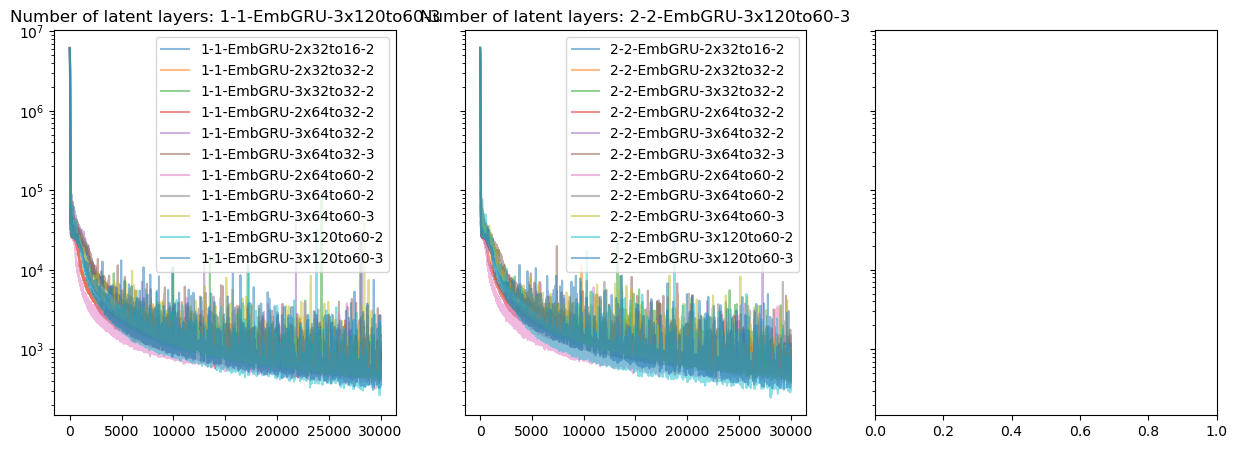

In [36]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
for key, (estimator, losses) in backwards.items():
    i = int(key.split('-')[0]) - 1
    axs[i].set_title(f'Number of latent layers: {key}')
    axs[i].plot(losses, label=f'{key}', alpha=0.5)
    axs[i].set_yscale('log')
    axs[i].legend()

In [43]:
backwards_samples = {}
for key, (estimator, losses) in backwards.items():
    X_estimator, Z_estimator, O_estimator = estimator.sample(n_samples, seed=seed)
    backwards_samples[key] = X_estimator

In [43]:
X_list = [X_base] + [X_meanfield] + [X_estimator for key, X_estimator in backwards_samples.items()]
groups = ['Data'] + ['MF'] + [f'{i} PLN-Tree ' + str(key) for i, (key, X_estimator) in enumerate(backwards_samples.items())]
groups_colors = [viridis(0.4 + 0.6 * (i+1)/len(backwards_samples)) for i, key in enumerate(backwards_samples.keys())]
colors = [viridis(0.3)] + [viridis(0.99)] + groups_colors

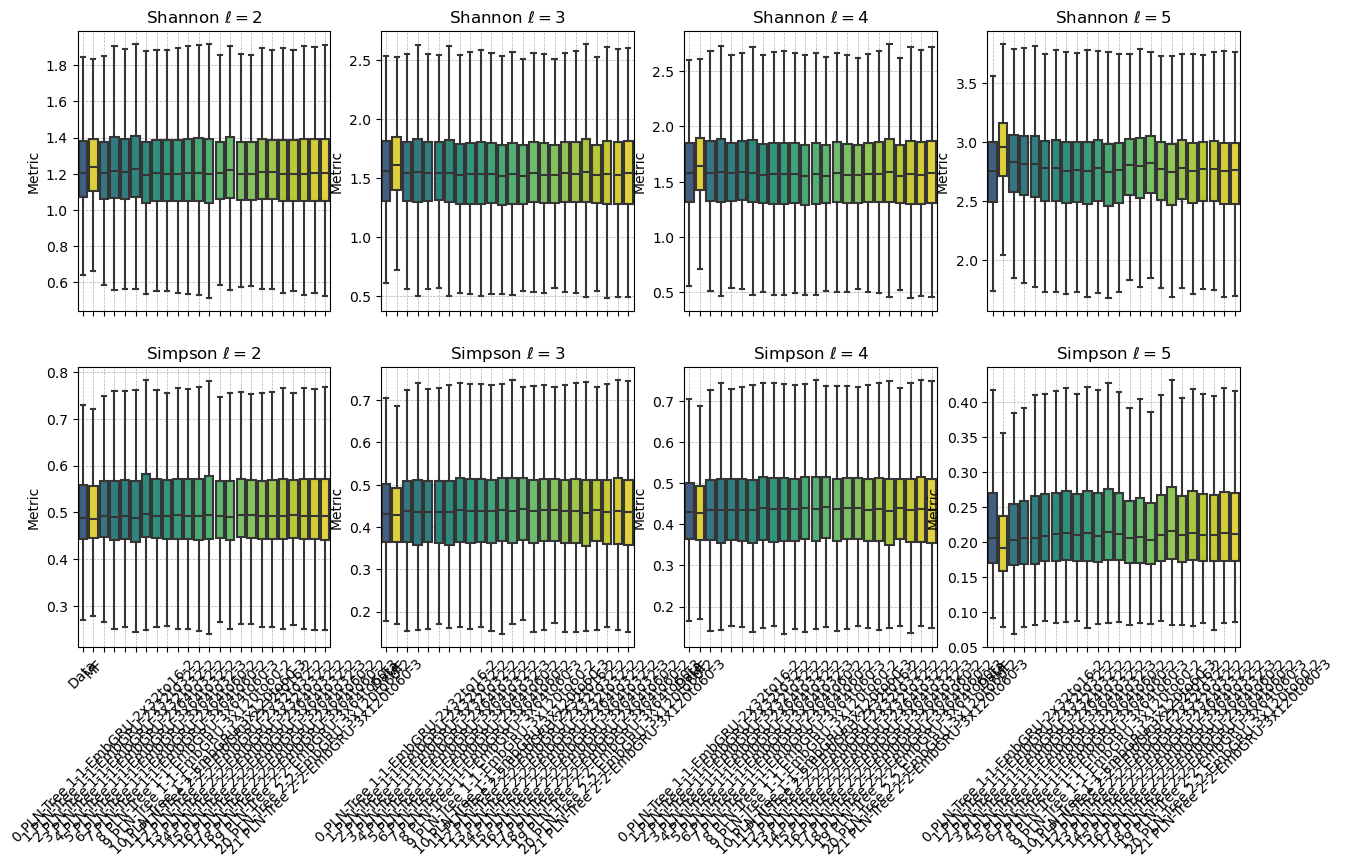

In [44]:
plot_alpha_diversity(
    X_list,
    taxonomy,
    offset_layer=selected_layers[0],
    groups_name=groups,
    colors=colors,
    style='boxplot',
)

In [45]:
print('Wasserstein Distance')
repeated_metric_compute(
    taxonomy, X_base,  X_list[1:], groups[1:], 
    n_split=10, distance=wasserstein_distance, offset_layer=selected_layers[0], order=True
)

Wasserstein Distance


In [46]:
print('KL-Divergence')
repeated_metric_compute(
    taxonomy, X_base,  X_list[1:], groups[1:], 
    n_split=10, distance=kl_divergence, offset_layer=selected_layers[0], order=True
)

KL-Divergence


In [47]:
print('Total Variation')
repeated_metric_compute(
    taxonomy, X_base,  X_list[1:], groups[1:], 
    n_split=10, distance=total_variation, offset_layer=selected_layers[0], order=True
)

Total Variation


In [48]:
print('Kolmogorov-Smirnov')
repeated_metric_compute(
    taxonomy, X_base,  X_list[1:], groups[1:], 
    n_split=10, distance=kolmogorov_smirnov, offset_layer=selected_layers[0], order=True
)

Kolmogorov-Smirnov


#### Selected model training

In [37]:
plntree, plntree_losses = backwards['1-1-EmbGRU-2x64to32-2']

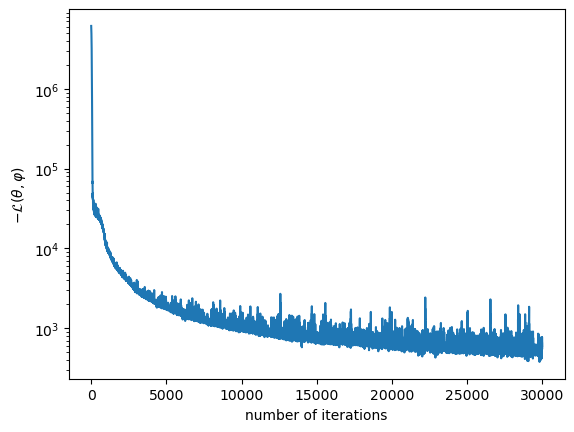

In [38]:
fig, axs = plt.subplots()
axs.plot(plntree_losses)
axs.set_ylabel('$-\mathcal{L}(\\theta, \\varphi)$')
axs.set_xlabel('number of iterations')
axs.set_yscale('log')
savefig(f"metagenomics_plntree_ELBO")

In [39]:
n_samples = 20_000 

X_plntree, Z_plntree, O_plntree = plntree.sample(n_samples, seed=seed)

## Benchmark

### Generative Benchmark

#### Choice of variational approximation

In [ ]:
X_list = (X_base, X_plntree_amortized, X_plntree_res, X_plntree_weak, X_meanfield, X_pln, X_pln_fill)
groups = ['Data', 'PLN-Tree', 'PLN-Tree (res)', 'PLN-Tree (weak)', 'PLN-Tree (MF)', 'PLN', 'PLN (fill)']
colors = [viridis(0.3), viridis(0.4), viridis(0.4), viridis(0.4), viridis(0.6), viridis(0.7), viridis(0.8)]

plot_alpha_diversity(
    X_list,
    taxonomy,
    offset_layer=selected_layers[0],
    groups_name=groups,
    colors=colors,
    style='boxplot'
)

In [ ]:
print('Wasserstein Distance')
repeated_metric_compute(
    taxonomy, X_base, X_list[1:], groups[1:], 
    n_split=20, distance=wasserstein_distance, offset_layer=selected_layers[0], order=True
)

In [ ]:
print('Kolmogorov Smirnov')
repeated_metric_compute(
    taxonomy, X_base, X_list[1:], groups[1:], 
    n_split=20, distance=kolmogorov_smirnov, offset_layer=selected_layers[0], order=True
)

In [ ]:
print('Total variation')
repeated_metric_compute(
    taxonomy, X_base, X_list[1:], groups[1:], 
    n_split=20, distance=total_variation, offset_layer=selected_layers[0], order=True
)

In [ ]:
print('KL Divergence')
repeated_metric_compute(
    taxonomy, X_base, X_list[1:], groups[1:], 
    n_split=20, distance=kl_divergence, offset_layer=selected_layers[0], order=True
)

In [ ]:
X_plntree = X_plntree_res

#### Benchmark

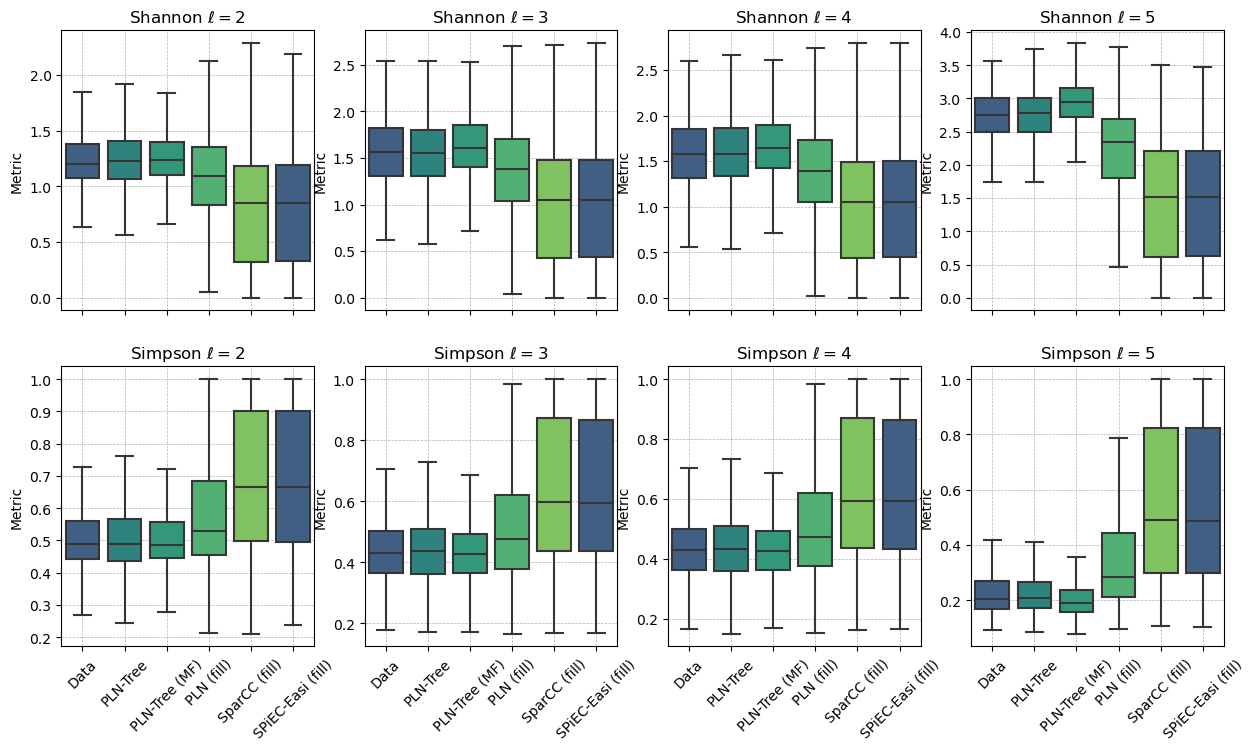

In [41]:
X_list = (X_base, X_plntree, X_meanfield, X_pln_fill, X_sparCC_fill, X_spiec_fill)
groups = ['Data', 'PLN-Tree', 'PLN-Tree (MF)', 'PLN (fill)', 'SparCC (fill)', 'SPiEC-Easi (fill)']
colors = [viridis(0.3), viridis(0.5), viridis(0.6), viridis(0.7), viridis(0.8)]

plot_alpha_diversity(
    X_list,
    taxonomy,
    offset_layer=selected_layers[0],
    groups_name=groups,
    colors=colors,
    style='boxplot',
    saveName=f'{prefix}_alpha_diversities',
)

In [39]:
X_comp = (X_plntree, X_meanfield, X_pln_fill, X_sparCC_fill, X_spiec_fill)
comp_names = ['PLN-Tree', 'PLN-Tree (MF)', 'PLN (fill)', 'SparCC (fill)', 'SPiEC-Easi (fill)']

In [46]:
print('Wasserstein Distance')
repeated_metric_compute(
    taxonomy, X_base, X_comp, comp_names, 
    n_split=20, distance=wasserstein_distance, offset_layer=selected_layers[0]
)

Wasserstein Distance


In [47]:
print('KL divergence')
repeated_metric_compute(
    taxonomy, X_base, X_comp, comp_names, 
    n_split=20, distance=kl_divergence, offset_layer=selected_layers[0]
)

KL divergence


In [48]:
print('Kolmogorov-Smirnov')
repeated_metric_compute(
    taxonomy, X_base, X_comp, comp_names, 
    n_split=20, distance=kolmogorov_smirnov, offset_layer=selected_layers[0]
)

Kolmogorov-Smirnov


In [49]:
print('Total variation')
repeated_metric_compute(
    taxonomy, X_base, X_comp, comp_names, 
    n_split=20, distance=total_variation, offset_layer=selected_layers[0]
)

Total variation


In [50]:
print('Distribution of samples distance: Wasserstein')
compute_distribution_distance(to_proportion(X_base, K), [to_proportion(X_c, K) for X_c in X_comp], 10, comp_names, K, distance=emd)

Distribution of samples distance: Wasserstein


In [51]:
print("PERMANOVA")
try:
    permanova_mean, permanova_pvalues_layers = load_pkl(prefix, 'pvalues_PERMANOVA')
except:
    permanova_mean, permanova_pvalues_layers = bootstrap_pvalues_braycurtis(
        K, "permanova",
        X_base, X_list[1:-1], groups[1:-1],
        n_samples=100, n_repeat=50, seed=seed, replacement=True
    )
    save_pkl((permanova_mean, permanova_pvalues_layers), prefix, 'pvalues_PERMANOVA')
permanova_mean

PERMANOVA


l = 0          l = 1          l = 2          l = 3
PLN-Tree        0.747 (0.27)   0.569 (0.33)  0.586 (0.337)  0.148 (0.176)
PLN-Tree (MF)  0.497 (0.342)  0.409 (0.335)  0.366 (0.311)   0.095 (0.12)
PLN (fill)     0.035 (0.068)  0.004 (0.009)  0.005 (0.007)    0.001 (0.0)
SparCC (fill)  0.001 (0.001)    0.001 (0.0)    0.001 (0.0)    0.001 (0.0)

In [69]:
permanova_pvalues_layers[3].apply(lambda x: x > 0.05).mean(0)

PLN-Tree        0.64000
PLN-Tree (MF)   0.52000
PLN (fill)      0.00000
SparCC (fill)   0.00000
dtype: float64

In [52]:
print("PERMDISP")
try:
    permdisp_mean, permdisp_pvalues_layers = load_pkl(prefix, 'pvalues_PERMDISP')
except:
    permdisp_mean, permdisp_pvalues_layers = bootstrap_pvalues_braycurtis(
        K, "permdisp",
        X_base, X_list[1:-1], groups[1:-1],
        n_samples=100, n_repeat=50, seed=seed, replacement=True
    )
    save_pkl((permdisp_mean, permdisp_pvalues_layers), prefix, 'pvalues_PERMDISP')
permdisp_mean

PERMDISP


l = 0          l = 1          l = 2          l = 3
PLN-Tree       0.313 (0.267)  0.199 (0.231)   0.25 (0.281)  0.323 (0.309)
PLN-Tree (MF)  0.493 (0.293)  0.481 (0.297)  0.387 (0.306)  0.144 (0.172)
PLN (fill)       0.001 (0.0)    0.001 (0.0)    0.001 (0.0)    0.001 (0.0)
SparCC (fill)    0.001 (0.0)    0.001 (0.0)    0.001 (0.0)    0.001 (0.0)

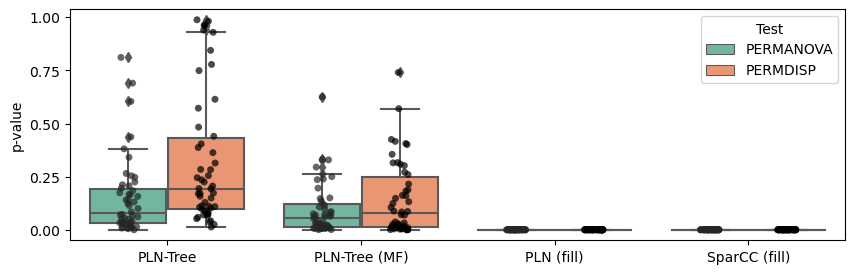

In [58]:
layer = 3
plot_test_pvalues(
    [permanova_pvalues_layers[layer], permdisp_pvalues_layers[layer]], 
    ['PERMANOVA', 'PERMDISP'], logscale=False, figsize=(10, 3)
)
savefig(f'{prefix}_pvalues_distrib_layer{layer+selected_layers[0]}')

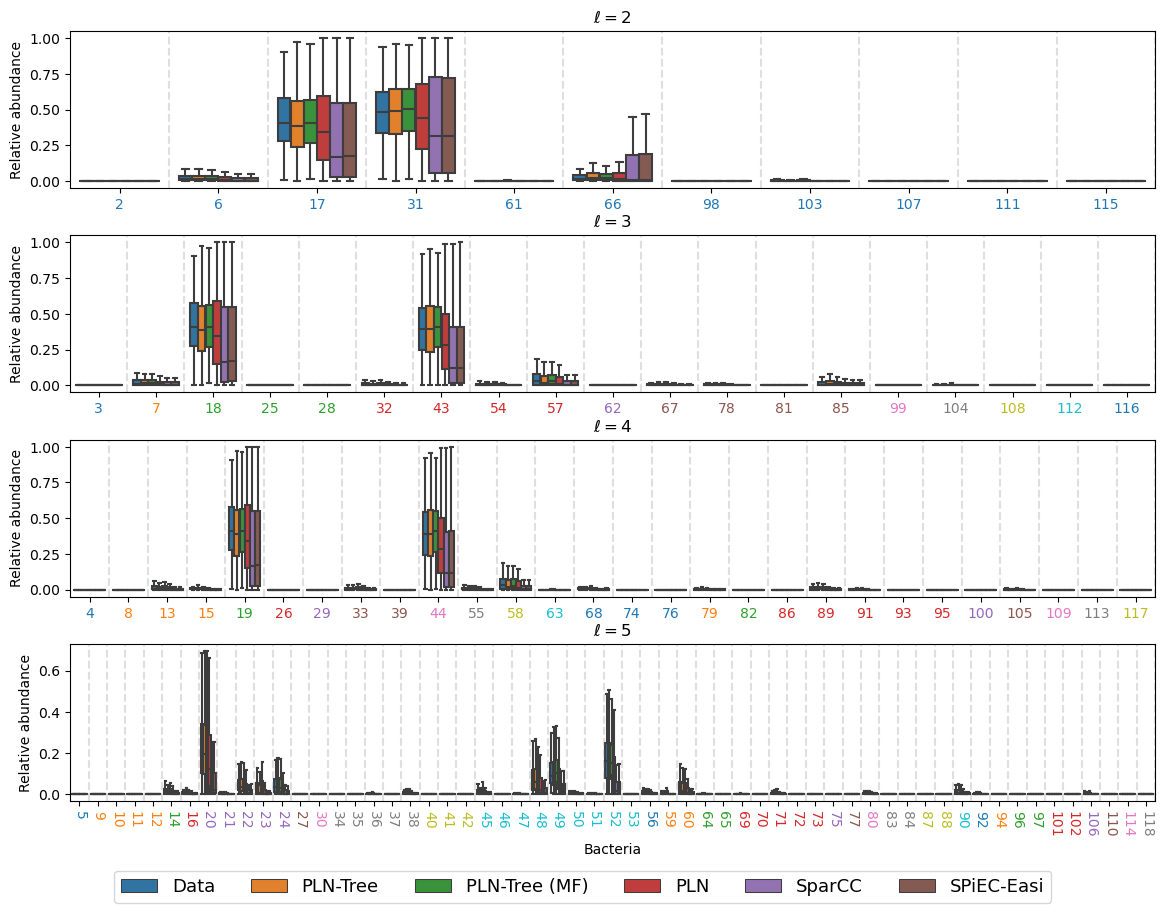

In [56]:
X_list = (X_base, X_plntree, X_meanfield, X_pln_fill, X_sparCC_fill, X_spiec_fill)
groups = ['Data', 'PLN-Tree', 'PLN-Tree (MF)', 'PLN', 'SparCC', 'SPiEC-Easi']

vizualize_entities_distributions(plntree, [to_proportion(X_, K) for X_ in X_list], groups, title='Relative abundance', figsize=(14, 10))
savefig(f'{prefix}_abundances_benchmark_boxplot')

### Encoding Benchmark

Correlation against PLN-Tree:
  * layer = 2: 0.970628268638031 ± 0.1127138848089819
  * layer = 3: 0.9707176527747813 ± 0.08391225731332587
  * layer = 4: 0.8263391378949836 ± 0.24346061670387964
  * layer = 5: 0.9169122722268763 ± 0.165353672835701
Correlation against PLN-Tree (MF):
  * layer = 2: 0.8503815984026584 ± 0.18435188062009986
  * layer = 3: 0.8426562301674239 ± 0.18500055328720627
  * layer = 4: 0.8035549329864466 ± 0.2584719004315274
  * layer = 5: 0.7362815958885892 ± 0.2118749094109529


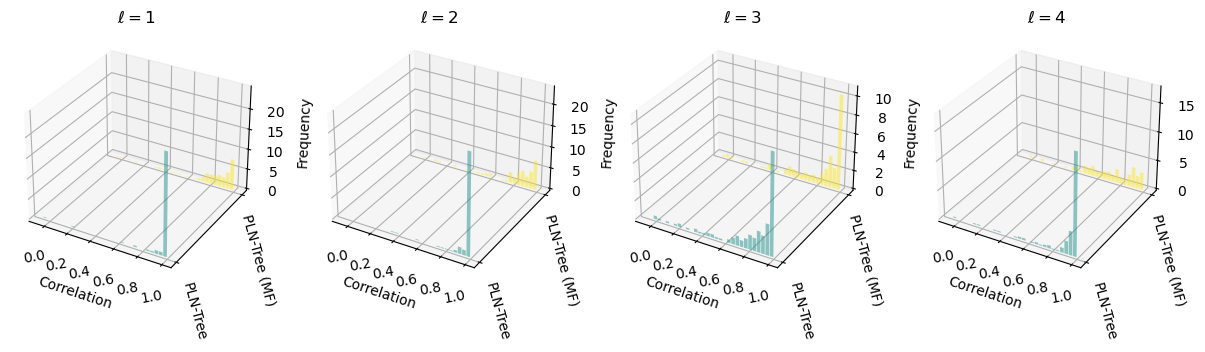

In [52]:
Z_test_plntree_enc, O_test_plntree_enc = plntree.encode(X_test, seed=seed)
X_test_plntree_enc = plntree.decode(Z_test_plntree_enc, O_test_plntree_enc, seed=seed)
Z_test_meanfield_enc, O_test_meanfield_enc = meanfield.encode(X_test, seed=seed)
X_test_meanfield_enc = meanfield.decode(Z_test_meanfield_enc, O_test_meanfield_enc, seed=seed)

X_comp = (X_test_plntree_enc, X_test_meanfield_enc)
groups = ['PLN-Tree', 'PLN-Tree (MF)']
for group, X_c in zip(groups, X_comp):
    print(f'Correlation against {group}:')
    correlations = correlation(X_test, X_c, meanfield)
    for layer, corr in enumerate(correlations):
        print(f'  * layer = {layer+selected_layers[0]}:', corr[~torch.isnan(corr)].mean().item(), '±', corr[~torch.isnan(corr)].std().item())
correlation_3d_plot(X_test, X_comp, groups, meanfield, saveName='')

In [53]:
for group, X_c in zip(groups, X_comp):
    m = mae_tree(to_proportion(X_test, K), to_proportion(X_c, K), K)
    print(f'MAE against {group}:', m.mean(), f'(± {m.std()})')

MAE against PLN-Tree: tensor(0.0131) (± nan)
MAE against PLN-Tree (MF): tensor(0.0410) (± nan)
